
## Tuyere model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD tuyere data with 894 samples

## Web application 6 inputs and 2 outputs

Run interactively on the web at: https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/2023/july2023/XGBoost/deployment/tuyere/



## Inputs

(1, 'i_h2_inj_kg_thm')

(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

(9, 'i_hot_blast_temp_k')

## Outputs

(14, 'o_tuyere_exit_velo_m_s')





## Installs


In [1]:

## !pip install xgboost
## !pip install onnxmltools
## !pip install onnxruntime



## Imports


In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [4]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt


In [5]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [6]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [7]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [8]:

PDFshapingOBJ.initializeImpulseGaussian()



## Run checks


In [9]:

# print(PDFshapingOBJ.x_range_impulse_func )
## print(PDFshapingOBJ.impulse_func_vector_vals )
## print(PDFshapingOBJ.quadratic_weights)
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
print(PDFshapingOBJ.quadratic_weights.shape)
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
tensor(100.0000)


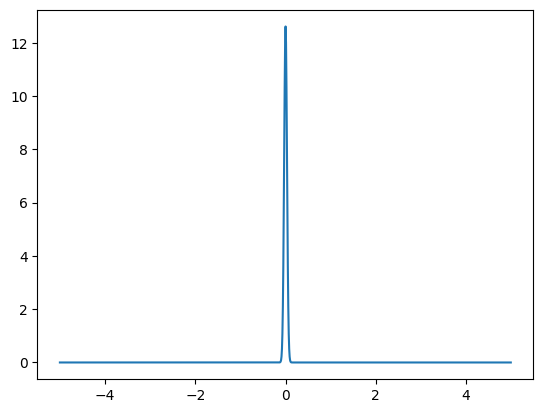

In [10]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()



## RUN KDE test


In [11]:

## PDFshapingOBJ.test_torchKDE_with_fake_data()



## Load Data


In [12]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.11.2023.csv')


In [13]:

PDFshapingOBJ.CFD_raw_data


index  i_h2_inj_kg_thm  i_pul_coal_inj_kg_thm  i_nat_gas_inj_kg_thm  \
0        1                0                      0                  37.9   
1        2                0                      0                  37.9   
2        3                0                      0                  37.9   
3        4                0                      0                  37.9   
4        5                0                      0                  70.0   
..     ...              ...                    ...                   ...   
889    890               20                      0                  70.0   
890    891               30                      0                  60.0   
891    892               10                      0                 100.0   
892    893               20                      0                  90.0   
893    894               30                      0                  80.0   

     i_nat_gas_t_k  i_o2_vol_perce  i_bf_windrate_nm3_hr  i_hb_moist_g_nm3  \
0              300              21            308750.365            12.154   
1              300              24            308750.365            12.154   
2              300              27            308750.365            12.154   
3              300              30            308750.365            12.154   
4              300              21            308750.365            12.154   
..             ...             ...                   ...               ...   
889            300              27            308750.365            12.154   
890            300              27            308750.365            12.154   
891            300              27            308750.365            12.154   
892            300              27            308750.365            12.154   
893            300              27            308750.365            12.154   

     i_hot_blast_press_pa  i_hot_blast_temp_k  ...  o_shaft_co_utiliz  \
0                359906.3            1459.817  ...           47.20085   
1                359906.3            1459.817  ...           49.15851   
2                359906.3            1459.817  ...           49.30602   
3                359906.3            1459.817  ...           47.22992   
4                359906.3            1459.817  ...           46.66340   
..                    ...                 ...  ...                ...   
889              359906.3            1459.817  ...           48.11546   
890              359906.3            1459.817  ...           47.40511   
891              359906.3            1459.817  ...           48.24004   
892              359906.3            1459.817  ...           47.21544   
893              359906.3            1459.817  ...           46.50030   

     o_shaft_h2_utiliz  o_shaft_top_gas_temp_c  o_shaft_press_drop_pa  \
0             42.99392                118.8785              108434.33   
1             44.99764                 95.7563              108381.02   
2             44.48147                 84.8519              112232.83   
3             46.37194                 66.3779              118634.40   
4             41.83302                130.4139              106947.64   
..                 ...                     ...                    ...   
889           42.78430                122.0079              137423.80   
890           41.99833                132.4238              146622.00   
891           41.11932                121.1668              128838.00   
892           39.43614                129.2255              129115.30   
893           41.24624                149.5792              157703.10   

     o_shaft_coke_rate_kg_thm  o_shaft_cohesive_zone_tip_height_m  \
0                   462.73655                            31.83963   
1                   480.82105                            31.83963   
2                   500.10050                            31.75963   
3                   521.58650                            31.55962   
4                   422.57185                           

In [14]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
30
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_bf_windrate_nm3_hr')
(7, 'i_hb_moist_g_nm3')
(8, 'i_hot_blast_press_pa')
(9, 'i_hot_blast_temp_k')
(10, 'i_ore_moisture_weight_perce')
(11, 'i_coke_weight_kg')
(12, 

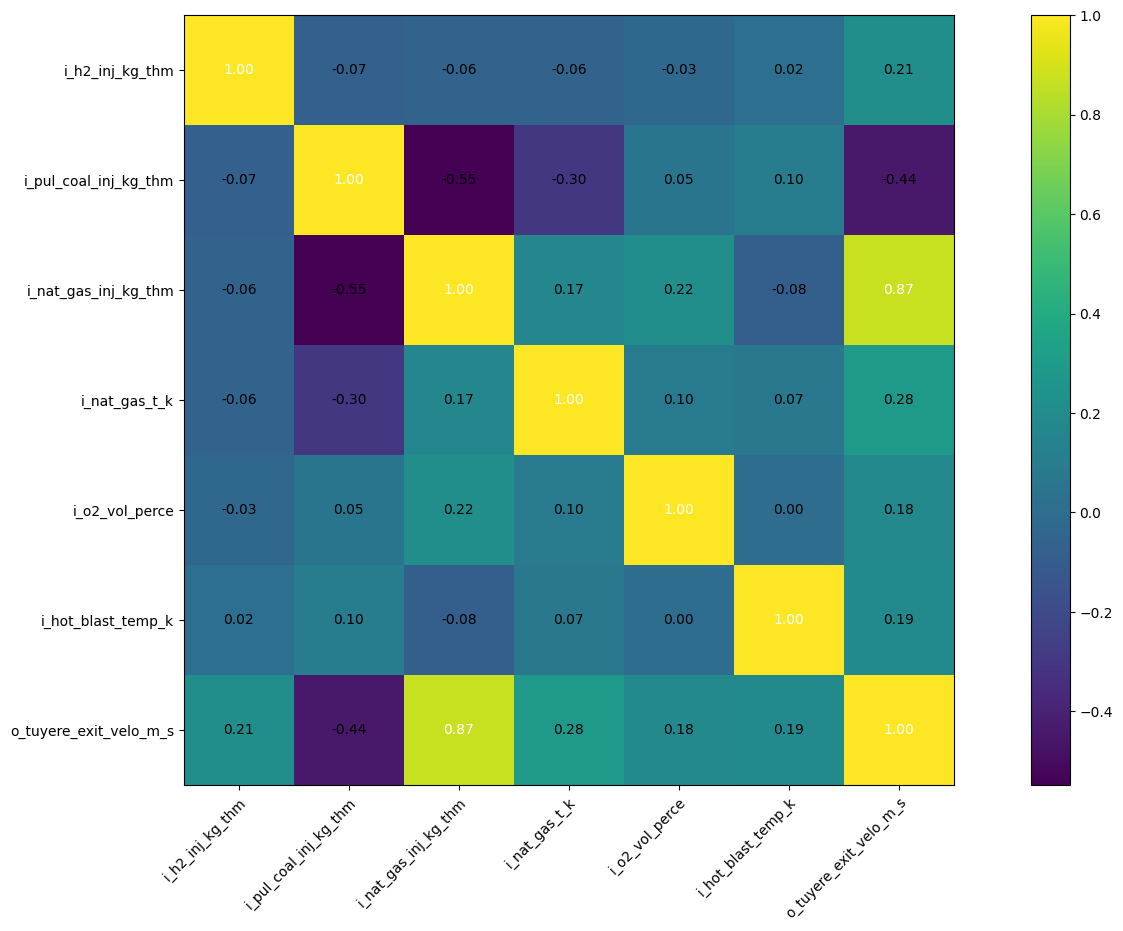

In [15]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 
                    'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k', 
                    'o_tuyere_exit_velo_m_s']

PDFshapingOBJ.print_correlation_coefficients()


In [16]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.          10.           0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.          20.           0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.          30.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 30)



## Select inputs and outputs


In [17]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 1, 2, 3, 4, 5, 9 ] , 
                   outputs= [ 14 ]   
)


6
1


In [18]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(894, 6)
(894, 1)


In [19]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [20]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 6)
(179, 6)
(715, 1)
(179, 1)


In [21]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [22]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [23]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl



## NN architectures


In [24]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled


In [25]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear


In [26]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [27]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "tuyere_exit_velo_m_s"


0  loss=  tensor(2.3587, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.2208, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0193, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0318, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0085, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0053, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0268, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0195, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0054, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0140, grad_fn=<MseLossBackward0>)


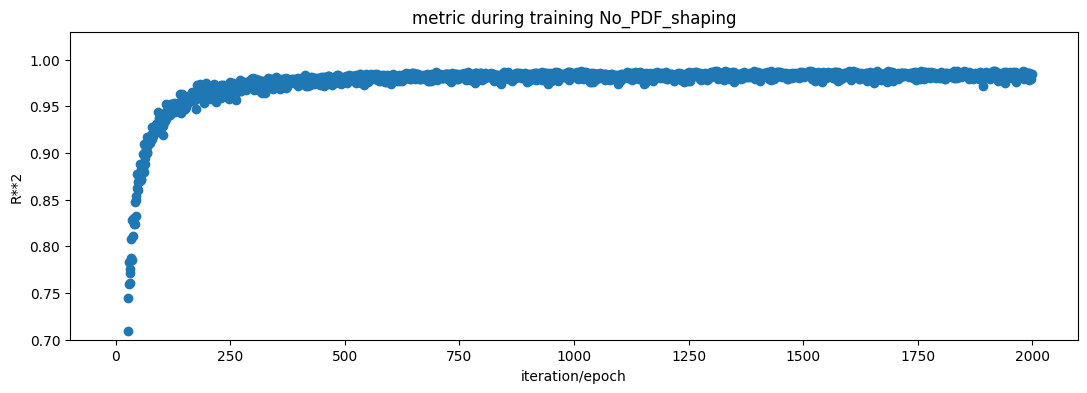

Training loss: tensor(0.0149, grad_fn=<MseLossBackward0>)
Training R**2: 0.98464484770879
Test loss - scaled: tensor(0.0148, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.9004, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9837348463778328
Testing R**2 - descaled: 0.9837348429592685
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.9837348429592685


In [28]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [29]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(149.72653, 150.8996)
**************************************************
preds, real
(143.2722, 143.5706)
**************************************************
preds, real
(134.91109, 134.7298)
**************************************************
preds, real
(131.99786, 132.48782)
**************************************************
preds, real
(127.673386, 129.11511)
**************************************************
preds, real
(129.78642, 129.21054)
**************************************************
preds, real
(135.36842, 135.0968)
**************************************************
preds, real
(135.3597, 135.0968)
**************************************************
preds, real
(148.90007, 148.57646)
**************************************************
preds, real
(129.13545, 129.84276)
**************************************************
preds, real
(143.4976, 143.62637)
**************************************************
preds, rea

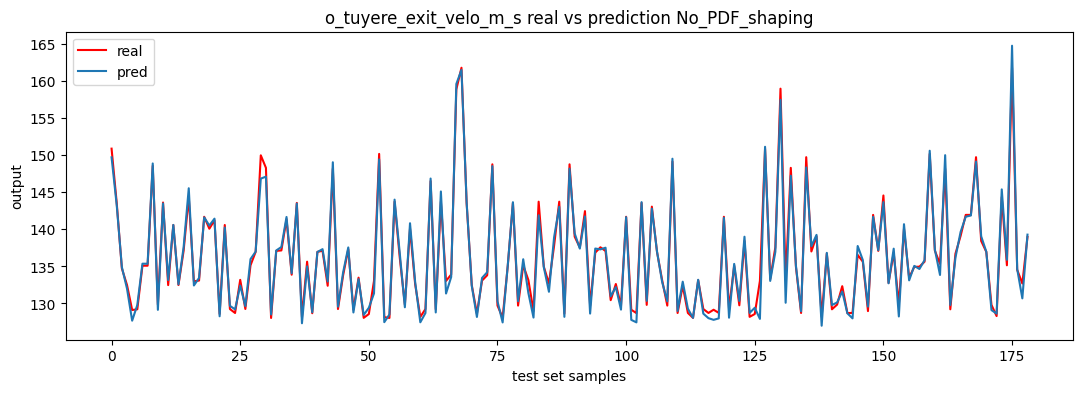

/Users/user/Desktop/DOE_CIVS/experiments/2023july/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


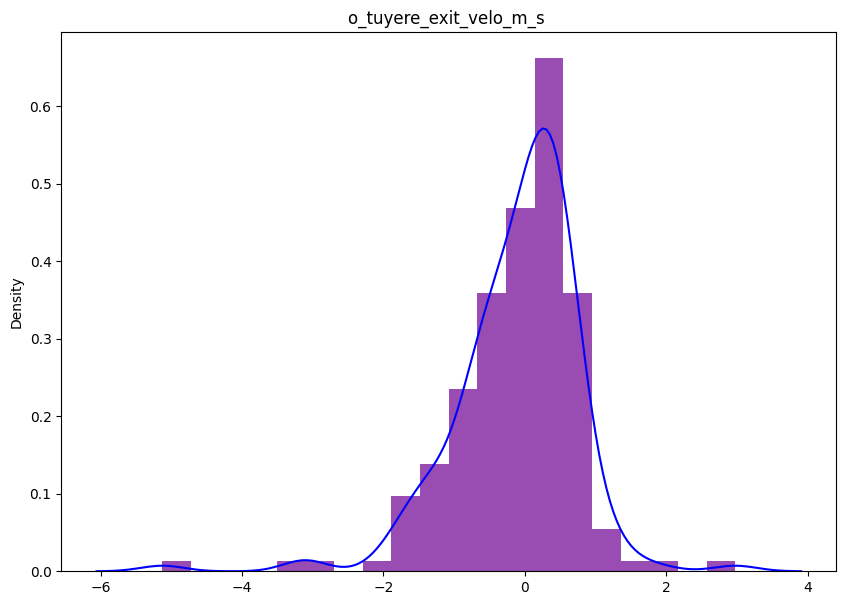

In [30]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## Export ONNX model


In [31]:



model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/F1plusF2NNs_Tuyere_exit_velo_m_s.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)





## To compare NNs to XGBoost


In [32]:

##      y_pred = regressor.predict(PDFshapingOBJ.X_test )

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)


In [33]:

pred_descaled


tensor([[150.6375],
        [143.6163],
        [134.9022],
        [132.4980],
        [129.1068],
        [129.0741],
        [135.3082],
        [135.3082],
        [147.6725],
        [129.4719],
        [143.5873],
        [133.0251],
        [140.7049],
        [132.4980],
        [137.3446],
        [144.6178],
        [132.7473],
        [132.8422],
        [141.6399],
        [140.6225],
        [141.6423],
        [128.5855],
        [140.7049],
        [129.0343],
        [128.4783],
        [132.5983],
        [129.0113],
        [135.9742],
        [136.9868],
        [149.9859],
        [147.6615],
        [127.9472],
        [137.2434],
        [137.7246],
        [141.6865],
        [134.1333],
        [143.6163],
        [128.0210],
        [135.1641],
        [128.4873],
        [136.9868],
        [137.3446],
        [133.1979],
        [148.4382],
        [129.0153],
        [134.1998],
        [137.3166],
        [129.1114],
        [133.4554],
        [127.9395],


In [34]:

## r2_score( PDFshapingOBJ.y_test, y_pred )

print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))


Testing R**2 - scaled: 0.9940930149186898
Testing R**2 - descaled: 0.9940930032218521



## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear


In [35]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt, kl_loss, scheduler):
    
    PDFshapingOBJ.list_metric = []
      
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate_pdfcontrol  )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
       
        error =   pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()          ## 715  x 1
        
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )             ## 1000 x 1
        
        p_pred = basisFunc.float() 
        q_real = PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() 
        
        
        diff = ( p_pred - q_real )**2              ## 1000 x 1
        diff = diff * PDFshapingOBJ.quadratic_weights.unsqueeze(1)      
          
        
        loss = torch.mean( diff  ) 
        

        ## loss_diff = loss_fn(p_pred, q_real)
        ## input_kl  = F.log_softmax(p_pred, dim=0) # F.log_softmax(p_kl)
        ## target_kl = F.softmax(    q_real, dim=0) # F.softmax(q_kl)
        ## loss =  loss_diff   ## kl_loss(input_kl, target_kl)  ##   +  torch.std(p_pred)
        
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        ## scheduler.step()
        
        ## if epoch % 7000 == 0 and epoch != 0:
        ##     decay_lr = opt.param_groups[0]['lr'] / 100
        ##     opt = torch.optim.Adam(   model.parameters(), lr=decay_lr  ) 
        
        
        ## PDFshapingOBJ.updateImpulseGaussian_with_new_standard_deviation(decay_impulse_std )
        

        print(epoch, " loss= ", loss)
        if epoch % 50 == 0:
            print(PDFshapingOBJ.impulse_func_vector_vals.shape )
            print(PDFshapingOBJ.quadratic_weights.shape)
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
            print('Epoch-{0} lr: {1}'.format(epoch, opt.param_groups[0]['lr']))
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    


In [36]:

PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "tuyere_exit_velo_m_s"

PDFshapingOBJ.learning_rate_pdfcontrol  = 0.001       ## 0.001
PDFshapingOBJ.N_EPOCHS_PDF              = 20000
PDFshapingOBJ.N_EPOCHS                  = 0

decay_impulse_std                       = PDFshapingOBJ.std_impulse / PDFshapingOBJ.N_EPOCHS_PDF 


6666
0  loss=  tensor(0.0097, grad_fn=<MeanBackward0>)
torch.Size([1000])
torch.Size([1000])
torch.Size([715, 1])
torch.Size([1000, 1])


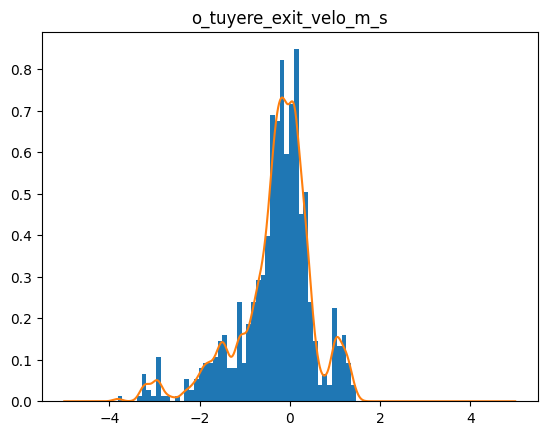

torch.Size([1000])
Epoch-0 lr: 0.001
1  loss=  tensor(0.0094, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.0097, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.0095, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.0091, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.0093, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.0091, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.0088, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.0090, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.0088, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.0088, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.0087, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.0087, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.0090, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.0084, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.0083, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.0086, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.0087, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.0081, grad_fn=<MeanBackward0>)
19  loss=  tensor(0.0083, grad_fn=<MeanBackward0>)
20 

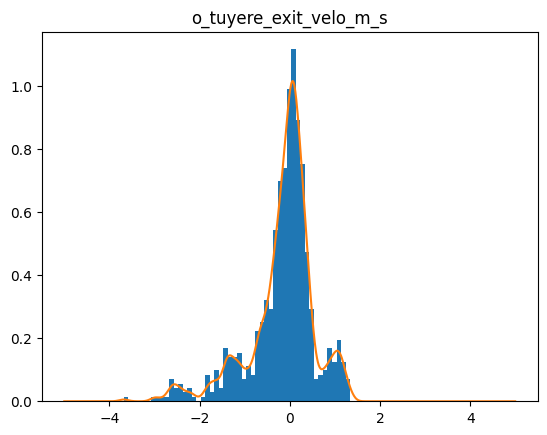

torch.Size([1000])
Epoch-50 lr: 0.001
51  loss=  tensor(0.0076, grad_fn=<MeanBackward0>)
52  loss=  tensor(0.0071, grad_fn=<MeanBackward0>)
53  loss=  tensor(0.0070, grad_fn=<MeanBackward0>)
54  loss=  tensor(0.0072, grad_fn=<MeanBackward0>)
55  loss=  tensor(0.0072, grad_fn=<MeanBackward0>)
56  loss=  tensor(0.0069, grad_fn=<MeanBackward0>)
57  loss=  tensor(0.0069, grad_fn=<MeanBackward0>)
58  loss=  tensor(0.0070, grad_fn=<MeanBackward0>)
59  loss=  tensor(0.0069, grad_fn=<MeanBackward0>)
60  loss=  tensor(0.0070, grad_fn=<MeanBackward0>)
61  loss=  tensor(0.0067, grad_fn=<MeanBackward0>)
62  loss=  tensor(0.0070, grad_fn=<MeanBackward0>)
63  loss=  tensor(0.0069, grad_fn=<MeanBackward0>)
64  loss=  tensor(0.0070, grad_fn=<MeanBackward0>)
65  loss=  tensor(0.0066, grad_fn=<MeanBackward0>)
66  loss=  tensor(0.0067, grad_fn=<MeanBackward0>)
67  loss=  tensor(0.0064, grad_fn=<MeanBackward0>)
68  loss=  tensor(0.0067, grad_fn=<MeanBackward0>)
69  loss=  tensor(0.0071, grad_fn=<MeanBackw

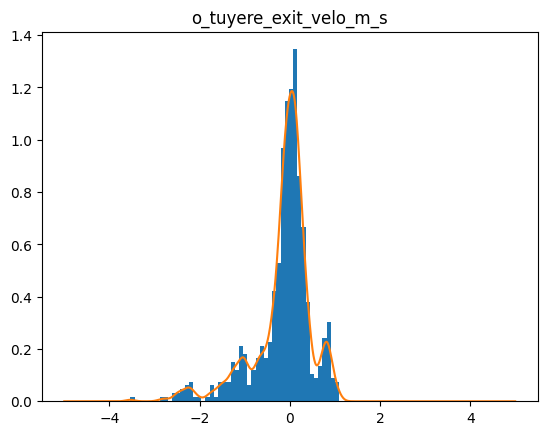

torch.Size([1000])
Epoch-100 lr: 0.001
101  loss=  tensor(0.0063, grad_fn=<MeanBackward0>)
102  loss=  tensor(0.0058, grad_fn=<MeanBackward0>)
103  loss=  tensor(0.0061, grad_fn=<MeanBackward0>)
104  loss=  tensor(0.0057, grad_fn=<MeanBackward0>)
105  loss=  tensor(0.0060, grad_fn=<MeanBackward0>)
106  loss=  tensor(0.0058, grad_fn=<MeanBackward0>)
107  loss=  tensor(0.0060, grad_fn=<MeanBackward0>)
108  loss=  tensor(0.0060, grad_fn=<MeanBackward0>)
109  loss=  tensor(0.0058, grad_fn=<MeanBackward0>)
110  loss=  tensor(0.0056, grad_fn=<MeanBackward0>)
111  loss=  tensor(0.0057, grad_fn=<MeanBackward0>)
112  loss=  tensor(0.0058, grad_fn=<MeanBackward0>)
113  loss=  tensor(0.0057, grad_fn=<MeanBackward0>)
114  loss=  tensor(0.0055, grad_fn=<MeanBackward0>)
115  loss=  tensor(0.0055, grad_fn=<MeanBackward0>)
116  loss=  tensor(0.0056, grad_fn=<MeanBackward0>)
117  loss=  tensor(0.0055, grad_fn=<MeanBackward0>)
118  loss=  tensor(0.0054, grad_fn=<MeanBackward0>)
119  loss=  tensor(0.0053

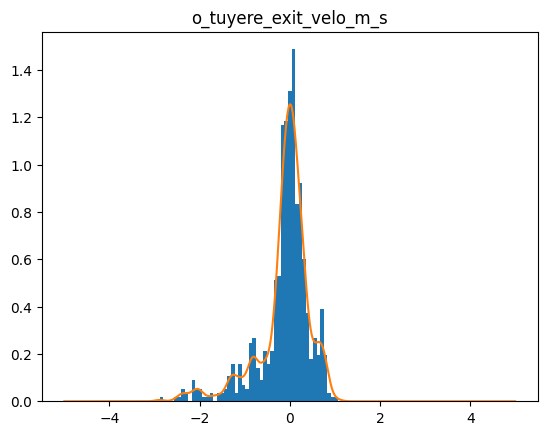

torch.Size([1000])
Epoch-150 lr: 0.001
151  loss=  tensor(0.0053, grad_fn=<MeanBackward0>)
152  loss=  tensor(0.0051, grad_fn=<MeanBackward0>)
153  loss=  tensor(0.0050, grad_fn=<MeanBackward0>)
154  loss=  tensor(0.0047, grad_fn=<MeanBackward0>)
155  loss=  tensor(0.0051, grad_fn=<MeanBackward0>)
156  loss=  tensor(0.0048, grad_fn=<MeanBackward0>)
157  loss=  tensor(0.0050, grad_fn=<MeanBackward0>)
158  loss=  tensor(0.0051, grad_fn=<MeanBackward0>)
159  loss=  tensor(0.0050, grad_fn=<MeanBackward0>)
160  loss=  tensor(0.0049, grad_fn=<MeanBackward0>)
161  loss=  tensor(0.0047, grad_fn=<MeanBackward0>)
162  loss=  tensor(0.0049, grad_fn=<MeanBackward0>)
163  loss=  tensor(0.0048, grad_fn=<MeanBackward0>)
164  loss=  tensor(0.0048, grad_fn=<MeanBackward0>)
165  loss=  tensor(0.0045, grad_fn=<MeanBackward0>)
166  loss=  tensor(0.0048, grad_fn=<MeanBackward0>)
167  loss=  tensor(0.0049, grad_fn=<MeanBackward0>)
168  loss=  tensor(0.0046, grad_fn=<MeanBackward0>)
169  loss=  tensor(0.0048

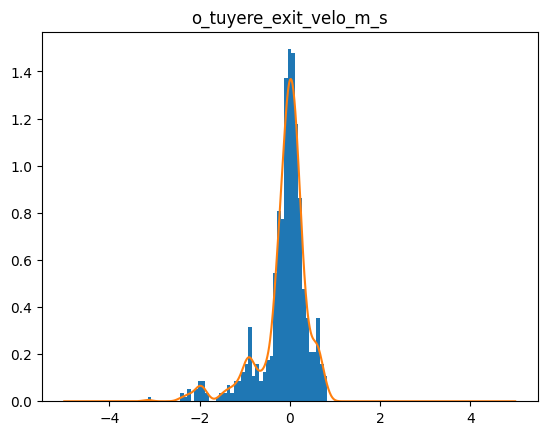

torch.Size([1000])
Epoch-200 lr: 0.001
201  loss=  tensor(0.0046, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.0045, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.0042, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.0043, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.0044, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.0042, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.0043, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.0046, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.0044, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.0046, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.0043, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.0042, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.0045, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.0044, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.0042, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.0043, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.0044, grad_fn=<MeanBackward0>)
219  loss=  tensor(0.0042

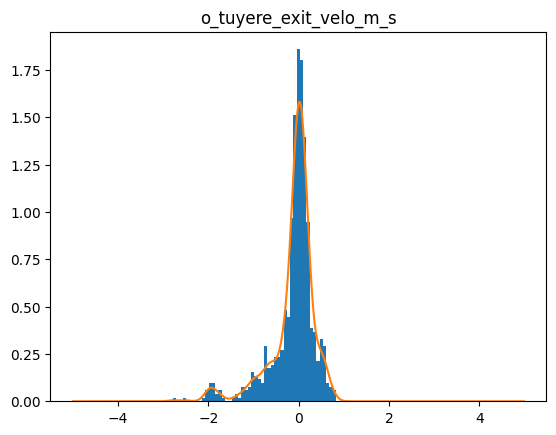

torch.Size([1000])
Epoch-250 lr: 0.001
251  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
252  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
253  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
254  loss=  tensor(0.0038, grad_fn=<MeanBackward0>)
255  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
256  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
257  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
258  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
259  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
260  loss=  tensor(0.0038, grad_fn=<MeanBackward0>)
261  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
262  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
263  loss=  tensor(0.0038, grad_fn=<MeanBackward0>)
264  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
265  loss=  tensor(0.0037, grad_fn=<MeanBackward0>)
266  loss=  tensor(0.0040, grad_fn=<MeanBackward0>)
267  loss=  tensor(0.0038, grad_fn=<MeanBackward0>)
268  loss=  tensor(0.0039, grad_fn=<MeanBackward0>)
269  loss=  tensor(0.0039

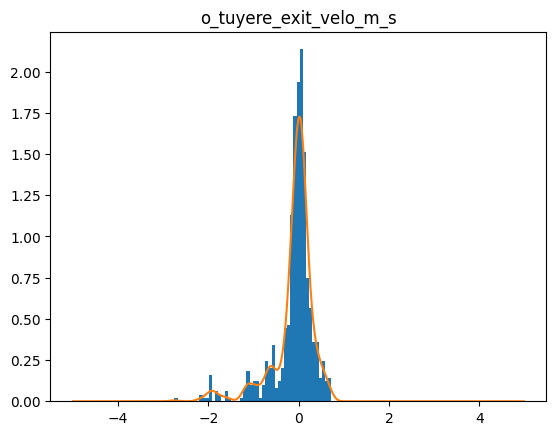

torch.Size([1000])
Epoch-300 lr: 0.001
301  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
302  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
303  loss=  tensor(0.0037, grad_fn=<MeanBackward0>)
304  loss=  tensor(0.0038, grad_fn=<MeanBackward0>)
305  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
306  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
307  loss=  tensor(0.0037, grad_fn=<MeanBackward0>)
308  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
309  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
310  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
311  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
312  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
313  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
314  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
315  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
316  loss=  tensor(0.0037, grad_fn=<MeanBackward0>)
317  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
318  loss=  tensor(0.0037, grad_fn=<MeanBackward0>)
319  loss=  tensor(0.0036

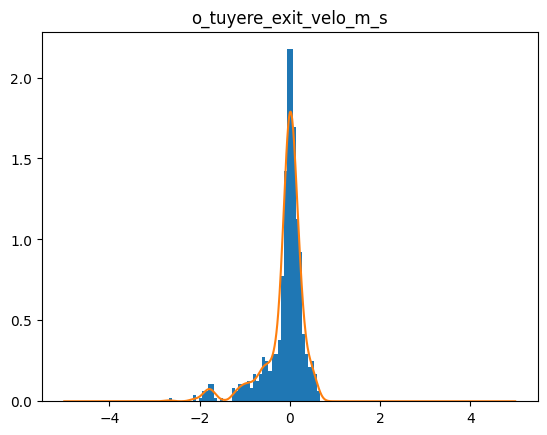

torch.Size([1000])
Epoch-350 lr: 0.001
351  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
352  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
353  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
354  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
355  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
356  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
357  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
358  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
359  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
360  loss=  tensor(0.0036, grad_fn=<MeanBackward0>)
361  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
362  loss=  tensor(0.0035, grad_fn=<MeanBackward0>)
363  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
364  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
365  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
366  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
367  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
368  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
369  loss=  tensor(0.0033

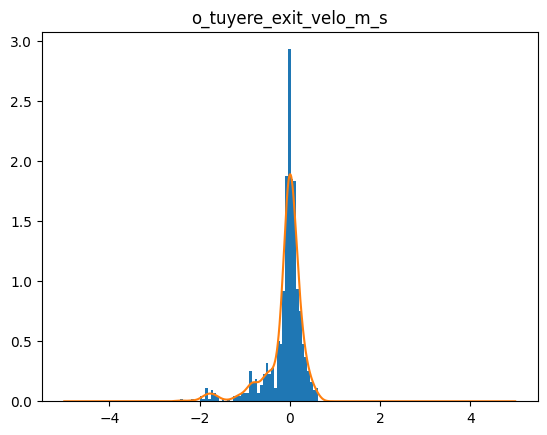

torch.Size([1000])
Epoch-400 lr: 0.001
401  loss=  tensor(0.0034, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
419  loss=  tensor(0.0032

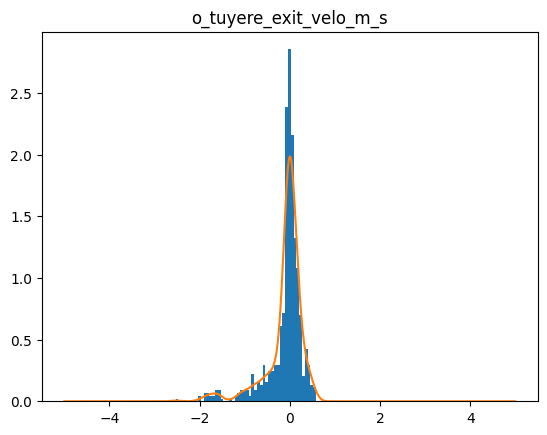

torch.Size([1000])
Epoch-450 lr: 0.001
451  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
452  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
453  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
454  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
455  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
456  loss=  tensor(0.0033, grad_fn=<MeanBackward0>)
457  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
458  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
459  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
460  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
461  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
462  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
463  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
464  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
465  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
466  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
467  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
468  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
469  loss=  tensor(0.0032

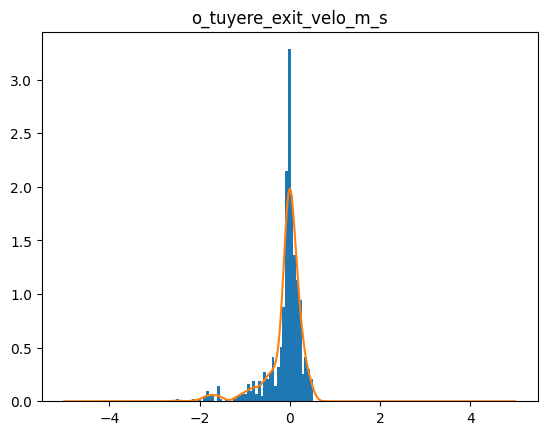

torch.Size([1000])
Epoch-500 lr: 0.001
501  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
502  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
503  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
504  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
505  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
506  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
507  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
508  loss=  tensor(0.0032, grad_fn=<MeanBackward0>)
509  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
510  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
511  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
512  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
513  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
514  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
515  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
516  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
517  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
518  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
519  loss=  tensor(0.0031

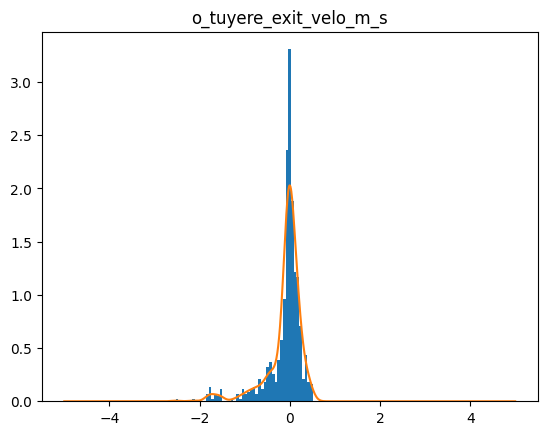

torch.Size([1000])
Epoch-550 lr: 0.001
551  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
552  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
553  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
554  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
555  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
556  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
557  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
558  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
559  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
560  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
569  loss=  tensor(0.0030

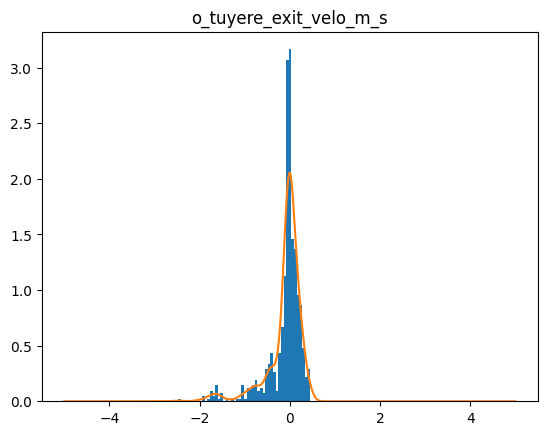

torch.Size([1000])
Epoch-600 lr: 0.001
601  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.0031, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
619  loss=  tensor(0.0031

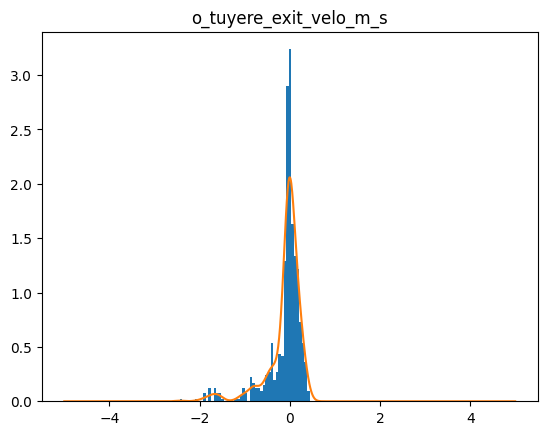

torch.Size([1000])
Epoch-650 lr: 0.001
651  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
652  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
653  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
654  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
655  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
656  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
657  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
658  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
659  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
660  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
661  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
662  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
663  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
664  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
665  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
666  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
667  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
668  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
669  loss=  tensor(0.0030

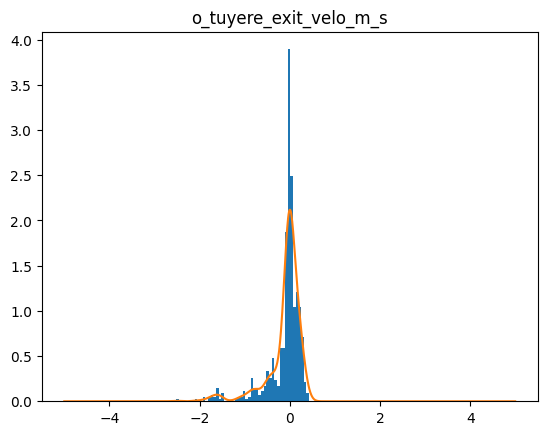

torch.Size([1000])
Epoch-700 lr: 0.001
701  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
702  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
703  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
704  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
705  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
706  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
707  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
708  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
709  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
710  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
711  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
712  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
713  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
714  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
715  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
716  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
717  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
718  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
719  loss=  tensor(0.0030

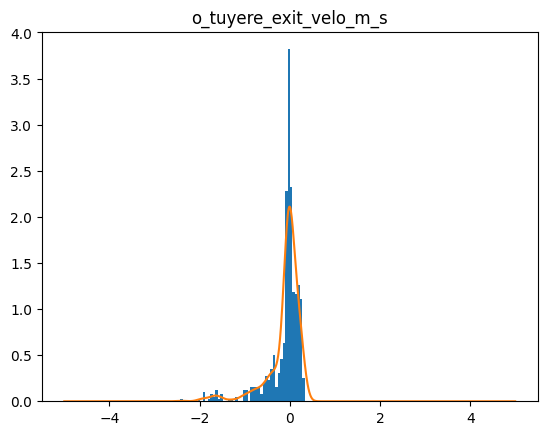

torch.Size([1000])
Epoch-750 lr: 0.001
751  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
752  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
753  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
754  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
755  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
756  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
757  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
758  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
759  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
760  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
761  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
762  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
763  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
764  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
765  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
766  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
769  loss=  tensor(0.0029

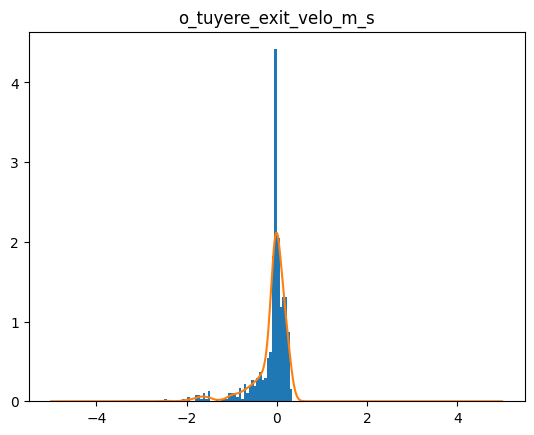

torch.Size([1000])
Epoch-800 lr: 0.001
801  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
819  loss=  tensor(0.0030

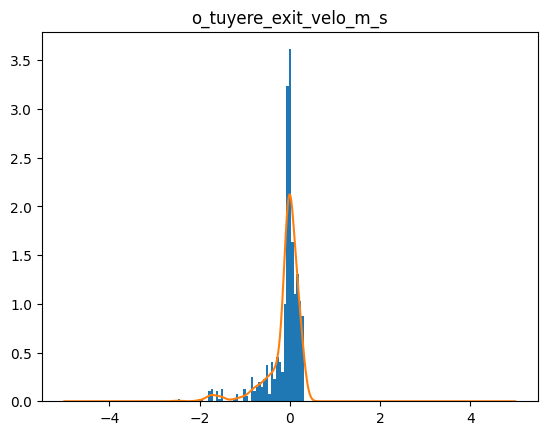

torch.Size([1000])
Epoch-850 lr: 0.001
851  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
852  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
853  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
854  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
855  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
856  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
857  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
858  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
859  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
860  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
861  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
862  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
863  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
864  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
865  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
866  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
867  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
868  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
869  loss=  tensor(0.0029

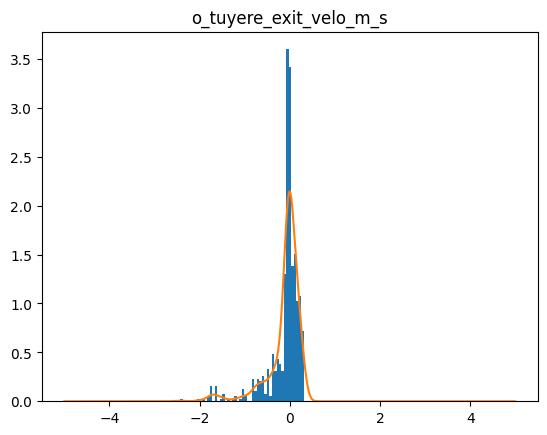

torch.Size([1000])
Epoch-900 lr: 0.001
901  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
902  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
903  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
904  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
905  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
906  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
907  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
908  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
909  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
910  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
911  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
912  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
913  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
914  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
915  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
916  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
917  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
918  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
919  loss=  tensor(0.0029

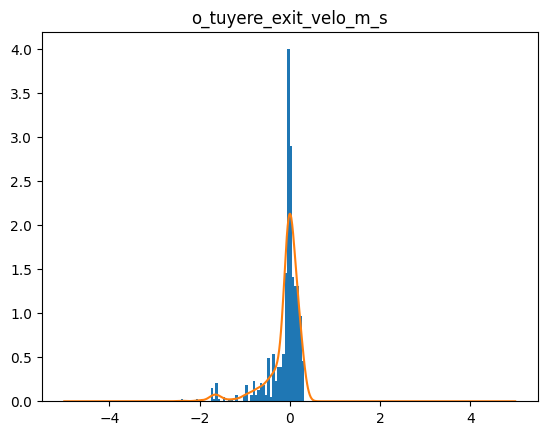

torch.Size([1000])
Epoch-950 lr: 0.001
951  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
952  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
953  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
954  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
955  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
956  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
957  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
958  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
959  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
960  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
969  loss=  tensor(0.0029

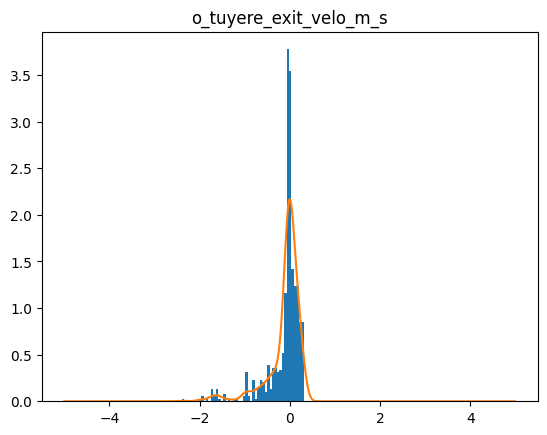

torch.Size([1000])
Epoch-1000 lr: 0.001
1001  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1002  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1003  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1004  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1005  loss=  tensor(0.0030, grad_fn=<MeanBackward0>)
1006  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1007  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1008  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1009  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1010  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1011  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1012  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1013  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1014  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1015  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1016  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1017  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1018  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1019  

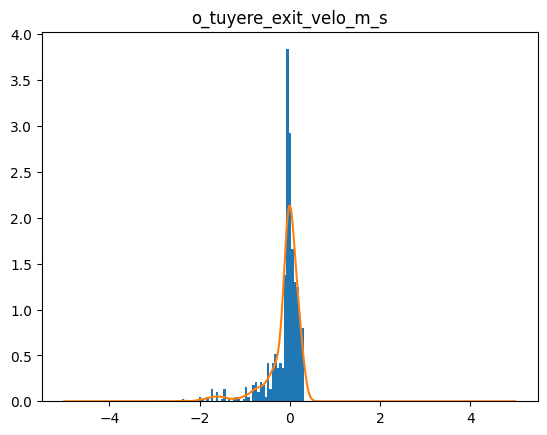

torch.Size([1000])
Epoch-1050 lr: 0.001
1051  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1052  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1053  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1054  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1055  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1056  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1057  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1058  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1059  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1060  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1061  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1062  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1063  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1064  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1065  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1066  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1067  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1068  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1069  

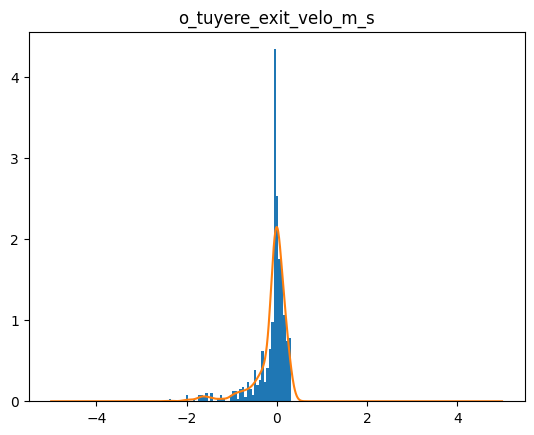

torch.Size([1000])
Epoch-1100 lr: 0.001
1101  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1102  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1103  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1104  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1105  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1106  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1107  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1108  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1109  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1110  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1111  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1112  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1113  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1114  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1115  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1116  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1117  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1118  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1119  

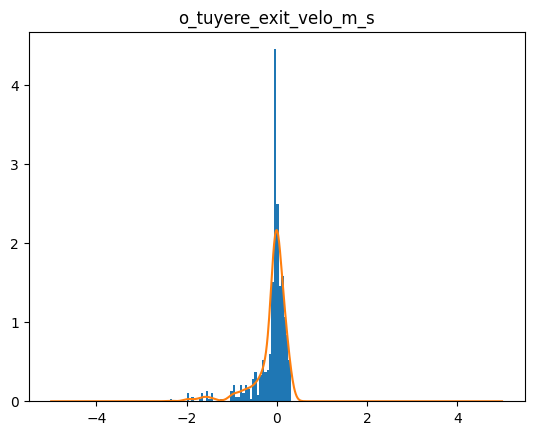

torch.Size([1000])
Epoch-1150 lr: 0.001
1151  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1152  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1153  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1154  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1155  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1156  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1157  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1158  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1159  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1160  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1161  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1162  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1163  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1164  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1165  loss=  tensor(0.0029, grad_fn=<MeanBackward0>)
1166  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1167  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1168  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1169  

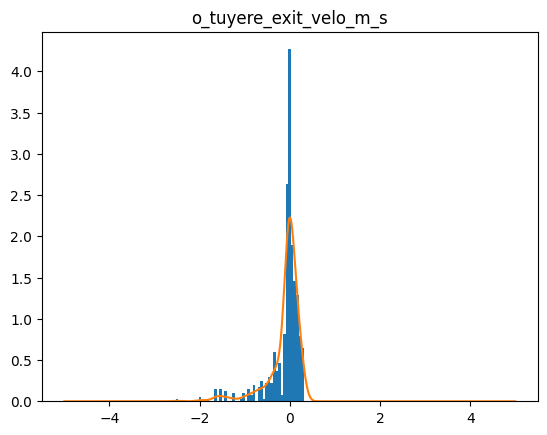

torch.Size([1000])
Epoch-1200 lr: 0.001
1201  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1202  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1203  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1204  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1205  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1206  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1207  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1208  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1209  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1210  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1211  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1212  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1213  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1214  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1215  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1216  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1217  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1218  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1219  

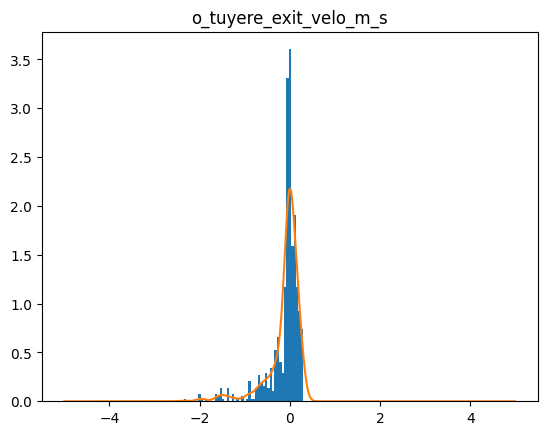

torch.Size([1000])
Epoch-1250 lr: 0.001
1251  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1252  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1253  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1254  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1255  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1256  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1257  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1258  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1259  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1260  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1261  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1262  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1263  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1264  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1265  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1266  loss=  tensor(0.0028, grad_fn=<MeanBackward0>)
1267  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1268  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1269  

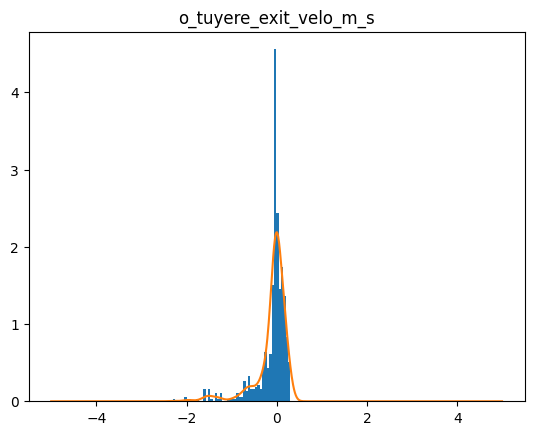

torch.Size([1000])
Epoch-1300 lr: 0.001
1301  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1302  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1303  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1304  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1305  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1306  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1307  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1308  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1309  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1310  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1311  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1312  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1313  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1314  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1315  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1316  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1317  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1318  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1319  

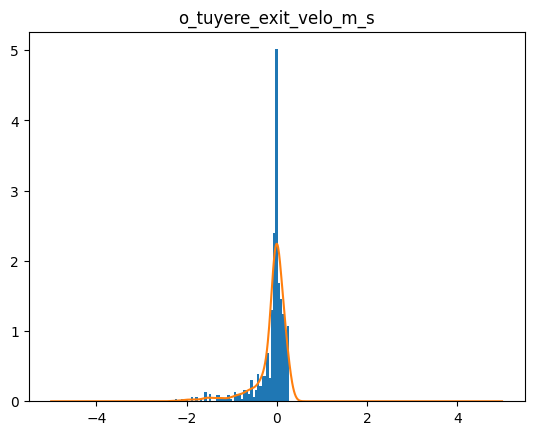

torch.Size([1000])
Epoch-1350 lr: 0.001
1351  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1352  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1353  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1354  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1355  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1356  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1357  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1358  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1359  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1360  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1361  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1362  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1363  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1364  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1365  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1366  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1367  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1368  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1369  

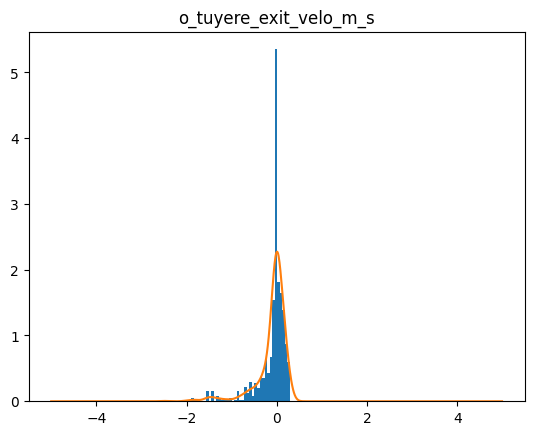

torch.Size([1000])
Epoch-1400 lr: 0.001
1401  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1402  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1403  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1404  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1405  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1406  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1407  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1408  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1409  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1410  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1411  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1412  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1413  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1414  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1415  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1416  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1417  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1418  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1419  

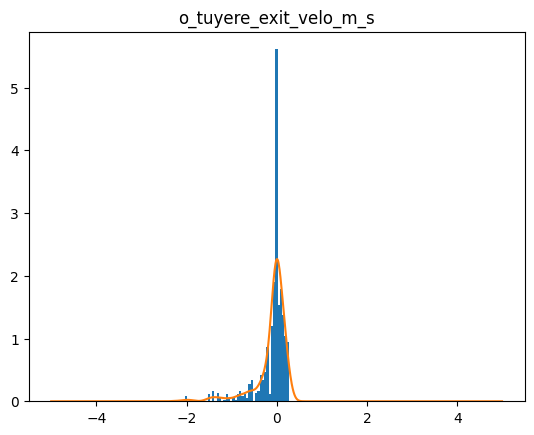

torch.Size([1000])
Epoch-1450 lr: 0.001
1451  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1452  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1453  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1454  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1455  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1456  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1457  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1458  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1459  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1460  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1461  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1462  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1463  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1464  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1465  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1466  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1467  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1468  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1469  

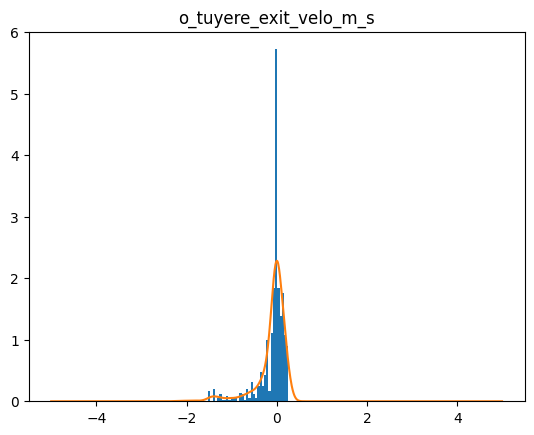

torch.Size([1000])
Epoch-1500 lr: 0.001
1501  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1502  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1503  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1504  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1505  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1506  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1507  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1508  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1509  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1510  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1511  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1512  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1513  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1514  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1515  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1516  loss=  tensor(0.0027, grad_fn=<MeanBackward0>)
1517  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1518  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1519  

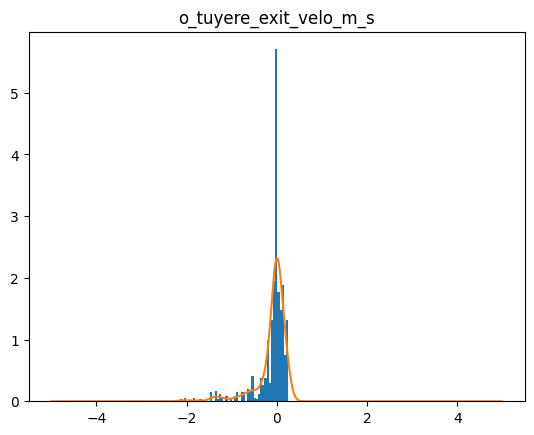

torch.Size([1000])
Epoch-1550 lr: 0.001
1551  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1552  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1553  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1554  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1555  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1556  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1557  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1558  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1559  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1560  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1561  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1562  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1563  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1564  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1565  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1566  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1567  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1568  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1569  

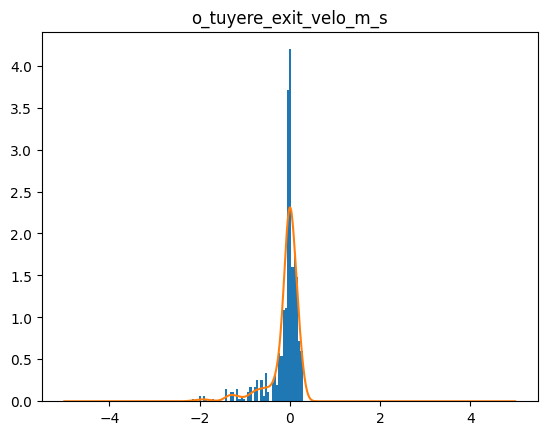

torch.Size([1000])
Epoch-1600 lr: 0.001
1601  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1602  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1603  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1604  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1605  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1606  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1607  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1608  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1609  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1610  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1611  loss=  tensor(0.0026, grad_fn=<MeanBackward0>)
1612  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1613  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1614  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1615  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1616  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1617  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1618  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1619  

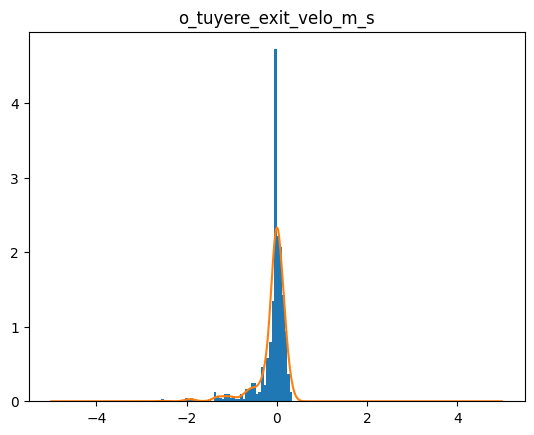

torch.Size([1000])
Epoch-1650 lr: 0.001
1651  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1652  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1653  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1654  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1655  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1656  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1657  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1658  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1659  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1660  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1661  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1662  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1663  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1664  loss=  tensor(0.0025, grad_fn=<MeanBackward0>)
1665  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1666  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1667  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1668  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1669  

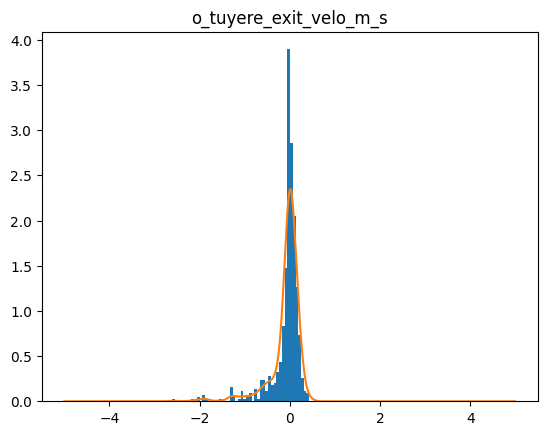

torch.Size([1000])
Epoch-1700 lr: 0.001
1701  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1702  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1703  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1704  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1705  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1706  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1707  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1708  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1709  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1710  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1711  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1712  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1713  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1714  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1715  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1716  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1717  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1718  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1719  

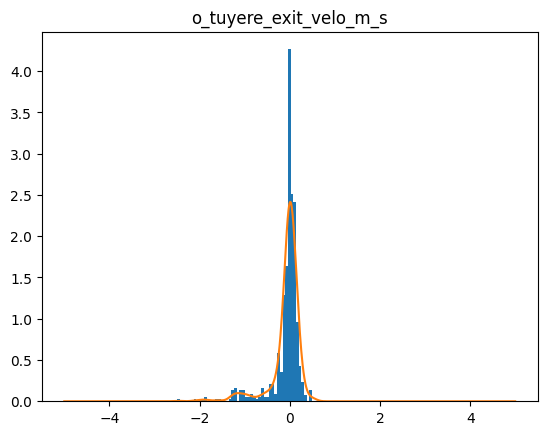

torch.Size([1000])
Epoch-1750 lr: 0.001
1751  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1752  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1753  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1754  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1755  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1756  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1757  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1758  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1759  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1760  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1761  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1762  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1763  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1764  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1765  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1766  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1767  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1768  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1769  

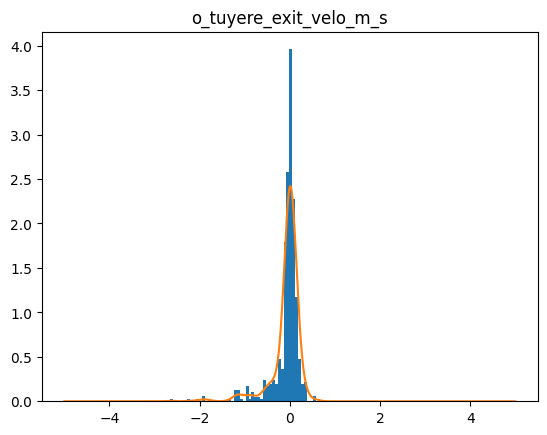

torch.Size([1000])
Epoch-1800 lr: 0.001
1801  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1802  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1803  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1804  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1805  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1806  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1807  loss=  tensor(0.0024, grad_fn=<MeanBackward0>)
1808  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1809  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1810  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1811  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1812  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1813  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1814  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1815  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1816  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1817  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1818  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1819  

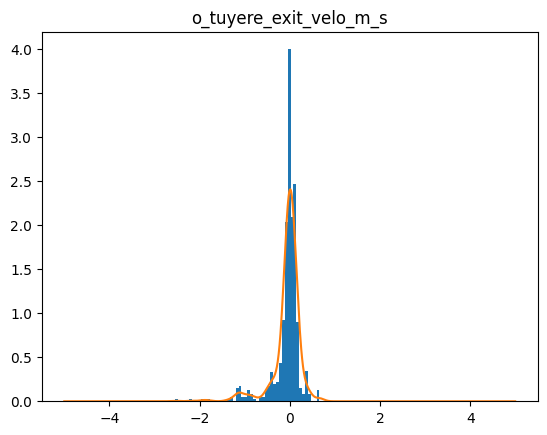

torch.Size([1000])
Epoch-1850 lr: 0.001
1851  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1852  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1853  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1854  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1855  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1856  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1857  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1858  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1859  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1860  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1861  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1862  loss=  tensor(0.0023, grad_fn=<MeanBackward0>)
1863  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1864  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1865  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1866  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1867  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1868  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1869  

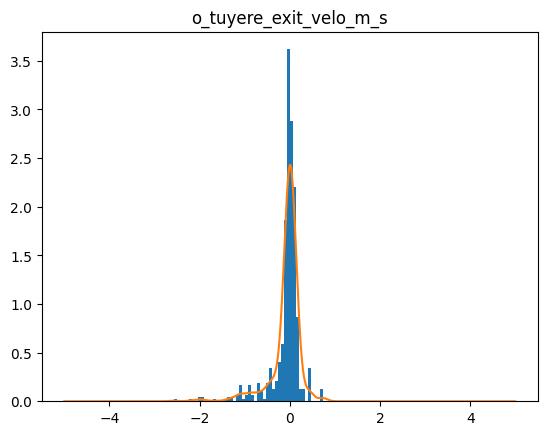

torch.Size([1000])
Epoch-1900 lr: 0.001
1901  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1902  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1903  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1904  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1905  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1906  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1907  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1908  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1909  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1910  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1911  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1912  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1913  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1914  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1915  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1916  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1917  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1918  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1919  

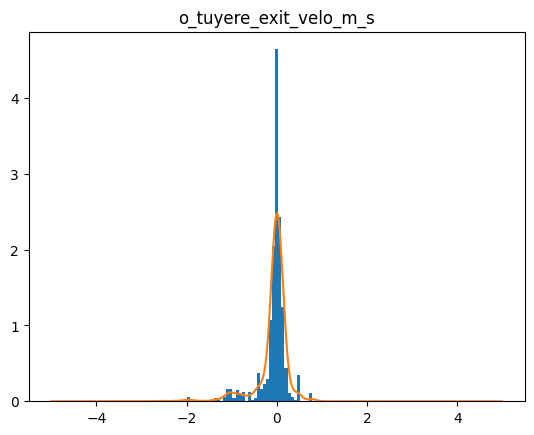

torch.Size([1000])
Epoch-1950 lr: 0.001
1951  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1952  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1953  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1954  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1955  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1956  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1957  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1958  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1959  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1960  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1961  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1962  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1963  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1964  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1965  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1966  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
1967  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1968  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
1969  

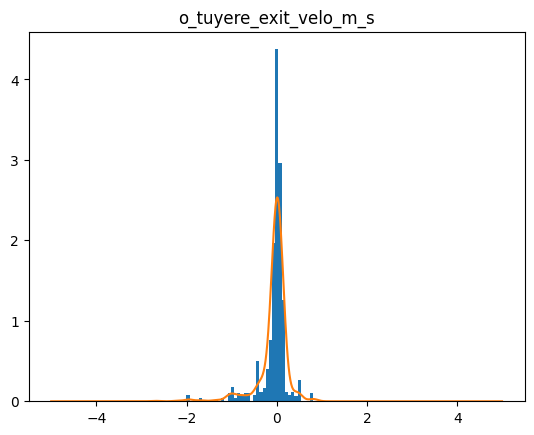

torch.Size([1000])
Epoch-2000 lr: 0.001
2001  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2002  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2003  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2004  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2005  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2006  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2007  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2008  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2009  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2010  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2011  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2012  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2013  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
2014  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2015  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2016  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2017  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2018  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2019  

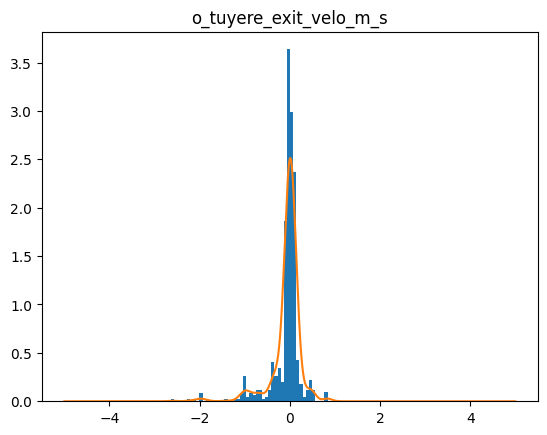

torch.Size([1000])
Epoch-2050 lr: 0.001
2051  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
2052  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2053  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2054  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2055  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2056  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2057  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2058  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2059  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2060  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2061  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2062  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2063  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2064  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2065  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2066  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2067  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2068  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2069  

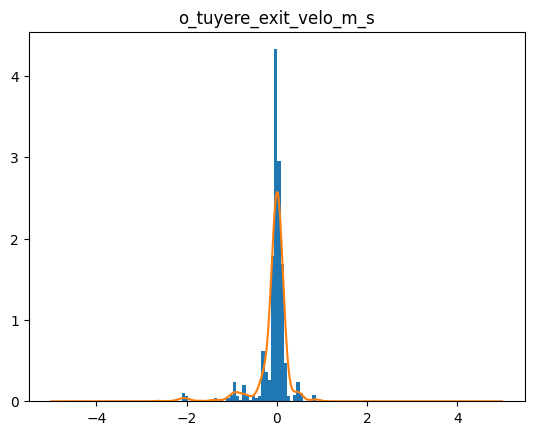

torch.Size([1000])
Epoch-2100 lr: 0.001
2101  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2102  loss=  tensor(0.0022, grad_fn=<MeanBackward0>)
2103  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2104  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2105  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2106  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2107  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2108  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2109  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2110  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2111  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2112  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2113  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2114  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2115  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2116  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2117  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2118  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2119  

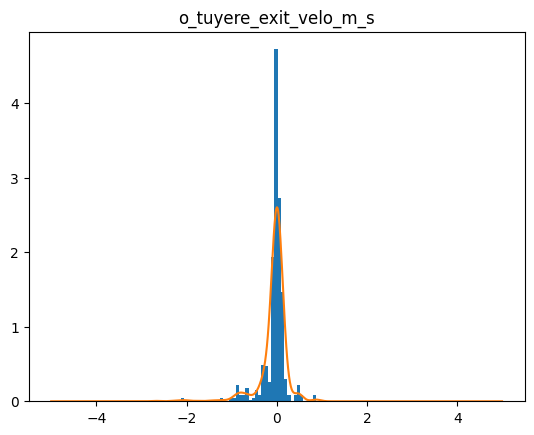

torch.Size([1000])
Epoch-2150 lr: 0.001
2151  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2152  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2153  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2154  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2155  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2156  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2157  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2158  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2159  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2160  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2161  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2162  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2163  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2164  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2165  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2166  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2167  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2168  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2169  

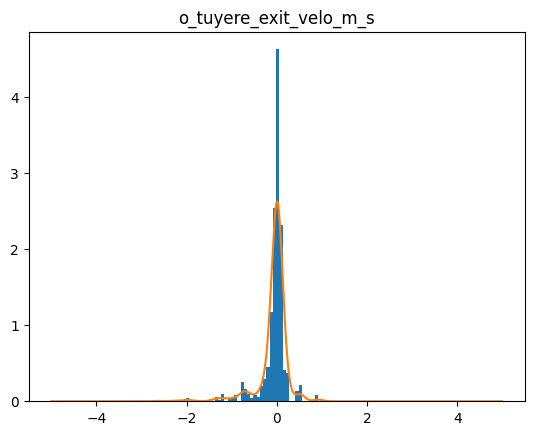

torch.Size([1000])
Epoch-2200 lr: 0.001
2201  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2202  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2203  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2204  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2205  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2206  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2207  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2208  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2209  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2210  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2211  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2212  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2213  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2214  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2215  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2216  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2217  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2218  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2219  

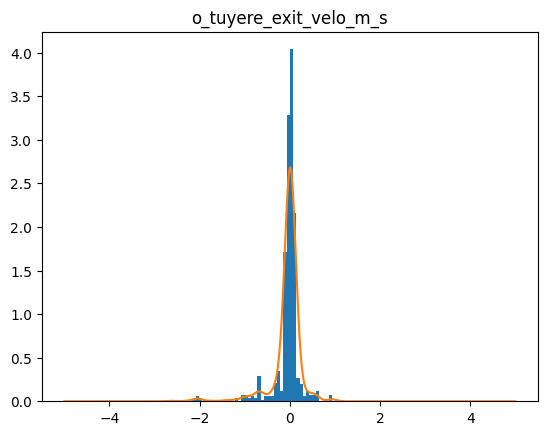

torch.Size([1000])
Epoch-2250 lr: 0.001
2251  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2252  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2253  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2254  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2255  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2256  loss=  tensor(0.0021, grad_fn=<MeanBackward0>)
2257  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2258  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2259  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2260  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2261  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2262  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2263  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2264  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2265  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2266  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2267  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2268  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2269  

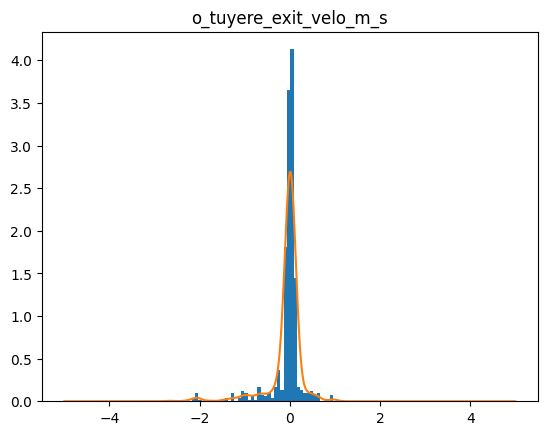

torch.Size([1000])
Epoch-2300 lr: 0.001
2301  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2302  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2303  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2304  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2305  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2306  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2307  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2308  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2309  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2310  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2311  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2313  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2314  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2315  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2316  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2317  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2318  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2319  

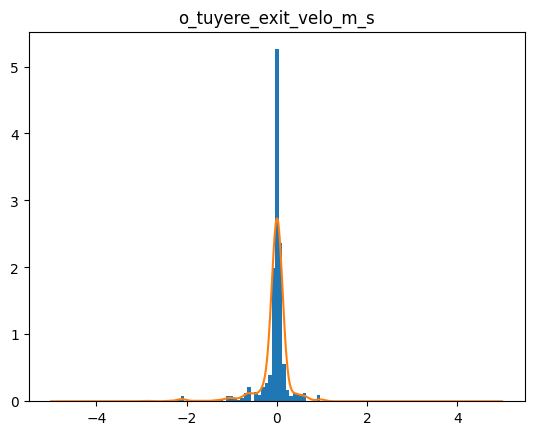

torch.Size([1000])
Epoch-2350 lr: 0.001
2351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2352  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2353  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2354  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2355  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2358  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2359  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2360  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2361  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2362  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2363  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2365  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2366  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2367  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2368  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2369  

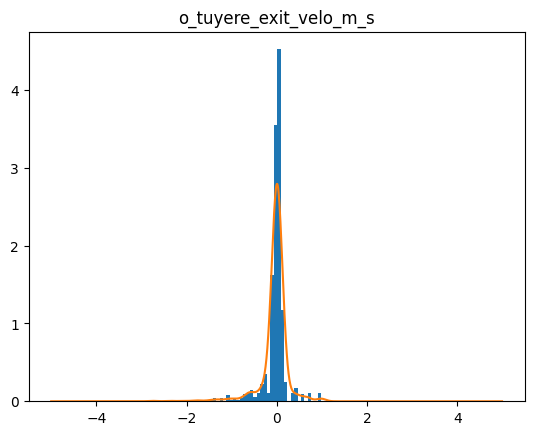

torch.Size([1000])
Epoch-2400 lr: 0.001
2401  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2402  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2403  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2404  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2405  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2406  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2408  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2409  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2410  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2411  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2412  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2413  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2415  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2416  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2417  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2419  

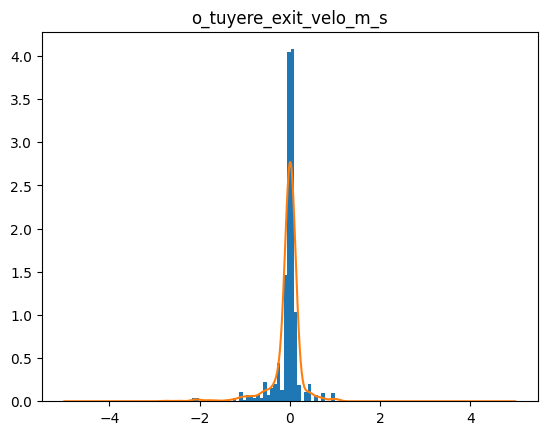

torch.Size([1000])
Epoch-2450 lr: 0.001
2451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2452  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2453  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2454  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2456  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2458  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2459  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2461  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2464  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2467  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2468  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2469  

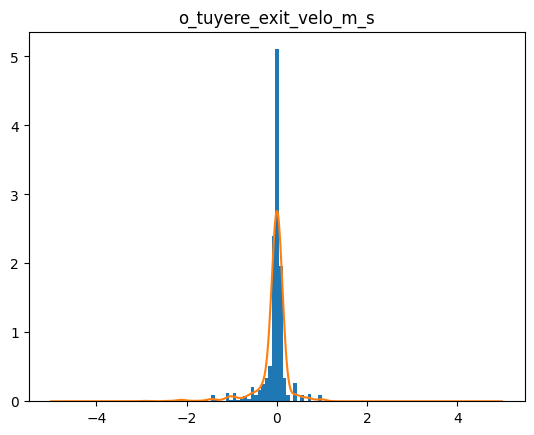

torch.Size([1000])
Epoch-2500 lr: 0.001
2501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2503  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2504  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2505  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2509  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2510  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2513  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2514  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2515  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2517  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2519  

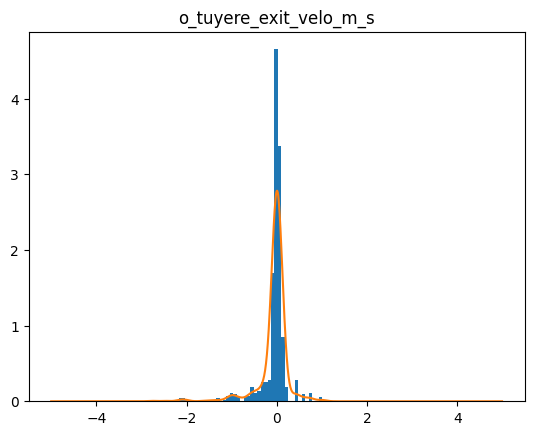

torch.Size([1000])
Epoch-2550 lr: 0.001
2551  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2552  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2554  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2556  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2557  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2558  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2561  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2563  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2564  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2565  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2566  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2568  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2569  

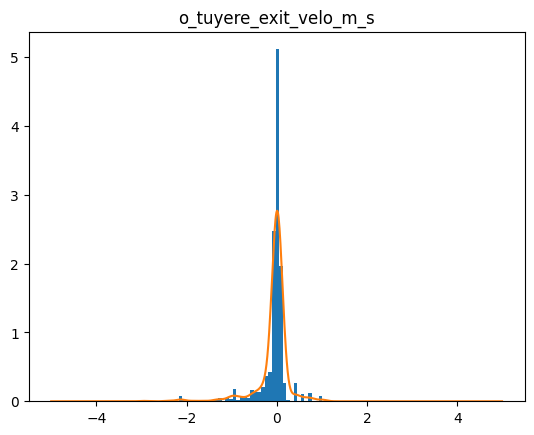

torch.Size([1000])
Epoch-2600 lr: 0.001
2601  loss=  tensor(0.0020, grad_fn=<MeanBackward0>)
2602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2604  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2606  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2607  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2608  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2609  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2610  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2611  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2612  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2614  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2616  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2617  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2618  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2619  

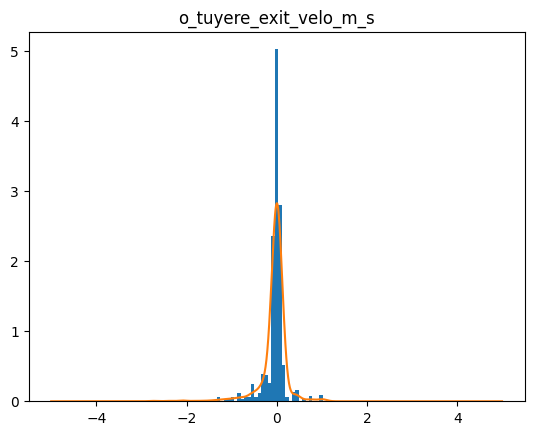

torch.Size([1000])
Epoch-2650 lr: 0.001
2651  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2654  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2655  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2656  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2657  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2658  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2659  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2661  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2662  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2665  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2666  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2667  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2668  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2669  

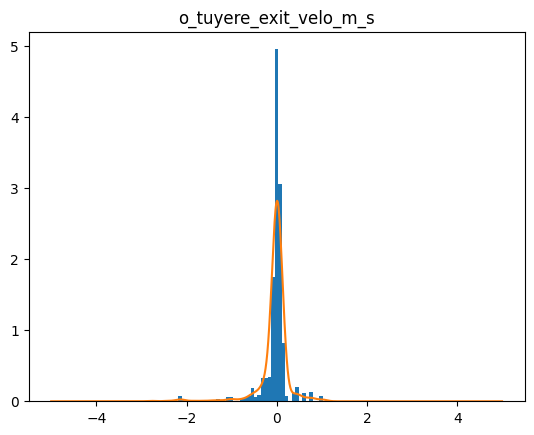

torch.Size([1000])
Epoch-2700 lr: 0.001
2701  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2702  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2703  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2704  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2705  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2706  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2707  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2709  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2710  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2714  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2715  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2716  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2717  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2719  

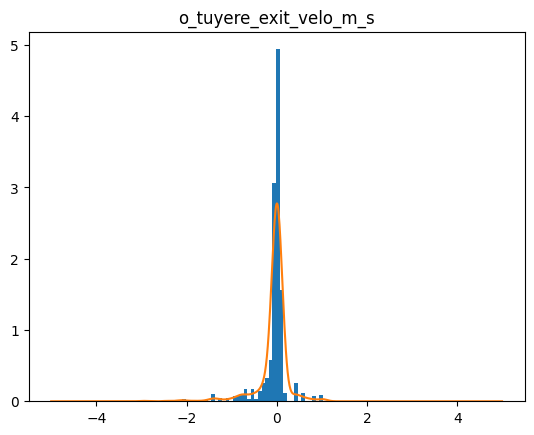

torch.Size([1000])
Epoch-2750 lr: 0.001
2751  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2752  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2753  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2754  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2756  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2760  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2761  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2762  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2764  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2765  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2768  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2769  

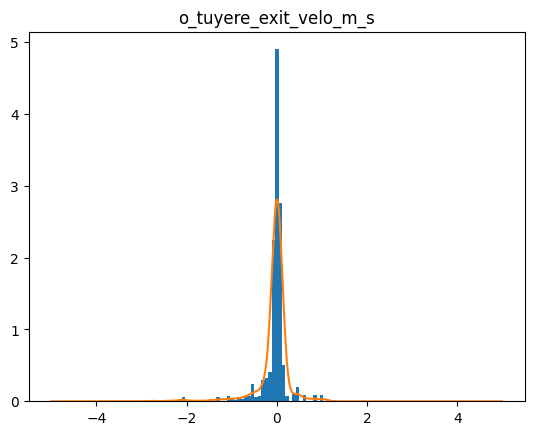

torch.Size([1000])
Epoch-2800 lr: 0.001
2801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2802  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2803  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2804  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2808  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2810  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2812  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2816  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2818  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2819  

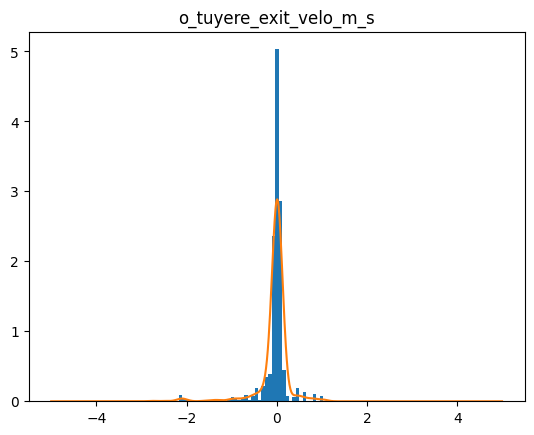

torch.Size([1000])
Epoch-2850 lr: 0.001
2851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2852  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2855  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2859  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2861  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2862  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2863  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2864  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2866  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2867  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2869  

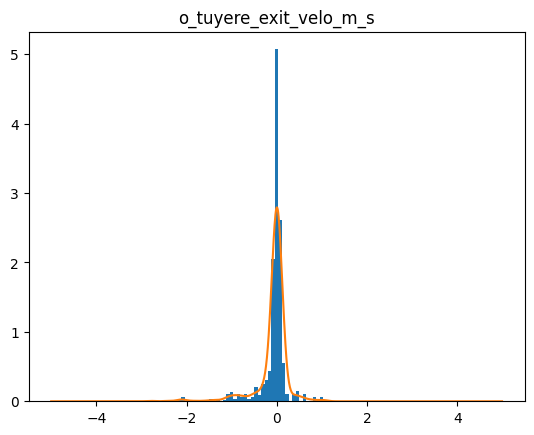

torch.Size([1000])
Epoch-2900 lr: 0.001
2901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2902  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2903  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2904  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2906  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
2907  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2908  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2909  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2910  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2912  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2913  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2918  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2919  

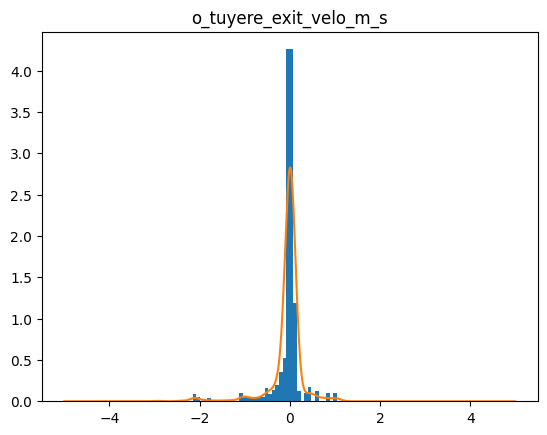

torch.Size([1000])
Epoch-2950 lr: 0.001
2951  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2953  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2956  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2957  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
2958  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2959  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2960  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2961  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2962  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2963  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2964  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2965  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2966  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2967  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
2968  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
2969  

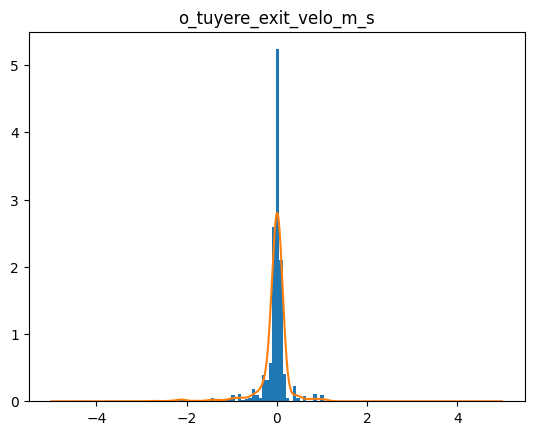

torch.Size([1000])
Epoch-3000 lr: 0.001
3001  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3002  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3004  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3005  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3006  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3007  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3008  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3009  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3013  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3015  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3016  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3017  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3018  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3019  

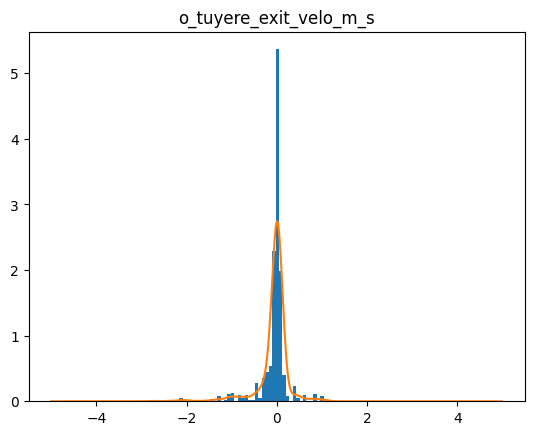

torch.Size([1000])
Epoch-3050 lr: 0.001
3051  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3052  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3054  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3055  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3057  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3059  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3061  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3066  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3067  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3068  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3069  

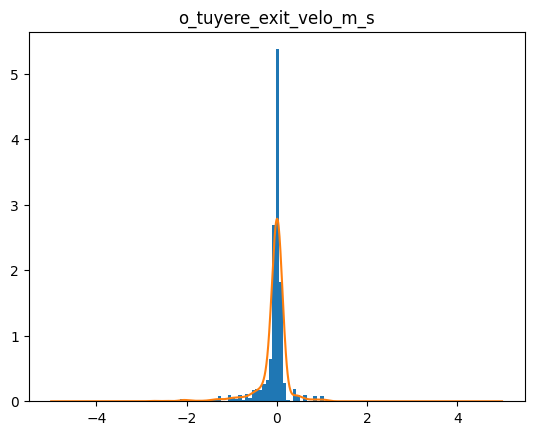

torch.Size([1000])
Epoch-3100 lr: 0.001
3101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3104  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3106  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3107  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3108  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3111  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3112  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3113  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3115  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3116  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3117  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
3118  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3119  

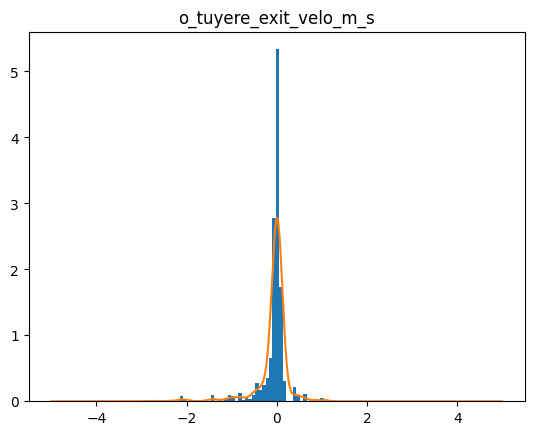

torch.Size([1000])
Epoch-3150 lr: 0.001
3151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3153  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3155  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3158  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3159  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3160  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3161  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3164  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3165  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3167  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3168  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3169  

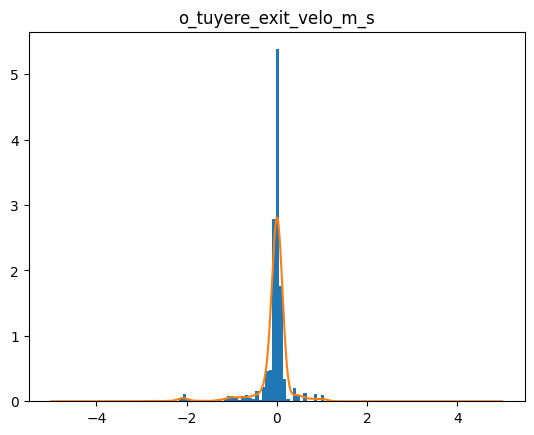

torch.Size([1000])
Epoch-3200 lr: 0.001
3201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3202  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3203  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3204  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3206  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3207  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3208  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3210  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3211  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3212  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3214  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3215  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
3216  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3217  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3218  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3219  

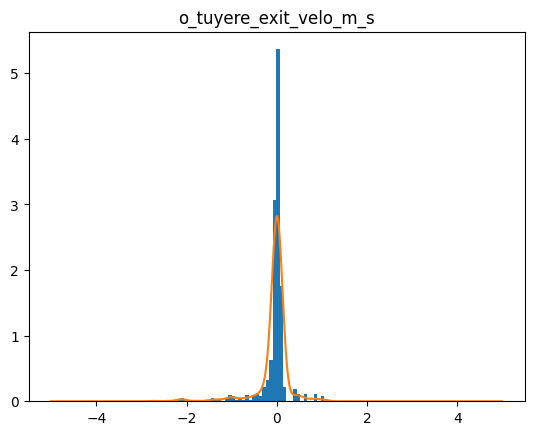

torch.Size([1000])
Epoch-3250 lr: 0.001
3251  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3254  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3256  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3257  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3258  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3260  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3261  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3262  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3265  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3266  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3268  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3269  

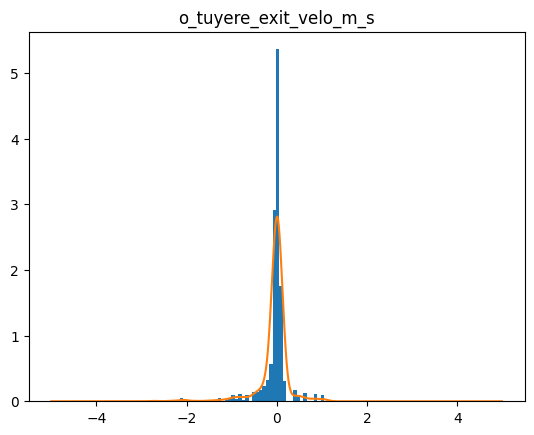

torch.Size([1000])
Epoch-3300 lr: 0.001
3301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3302  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3303  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3304  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3307  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3308  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3309  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3311  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3313  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3314  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3315  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3317  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3319  

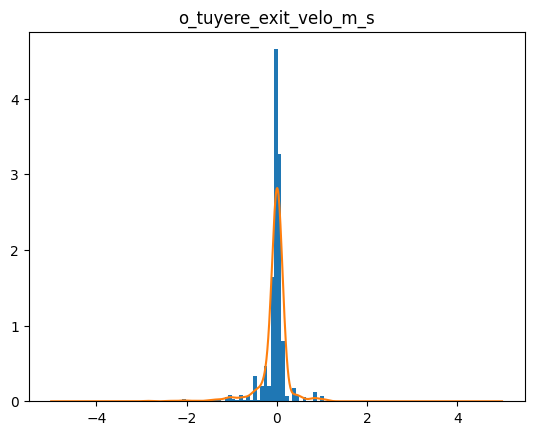

torch.Size([1000])
Epoch-3350 lr: 0.001
3351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3352  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3355  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3358  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3360  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3361  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3365  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3366  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3367  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3368  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3369  

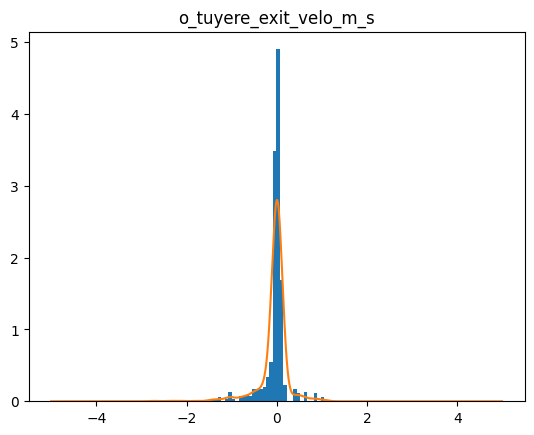

torch.Size([1000])
Epoch-3400 lr: 0.001
3401  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3402  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3403  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3404  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3406  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3408  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3409  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3410  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3411  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3412  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3415  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3416  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3417  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3419  

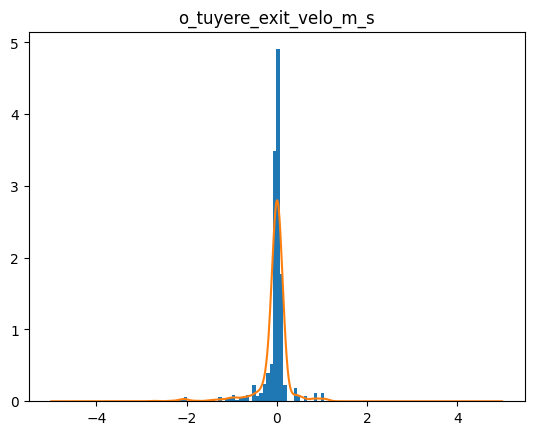

torch.Size([1000])
Epoch-3450 lr: 0.001
3451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3452  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3453  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3454  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3458  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3459  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3462  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3464  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3467  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3468  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3469  

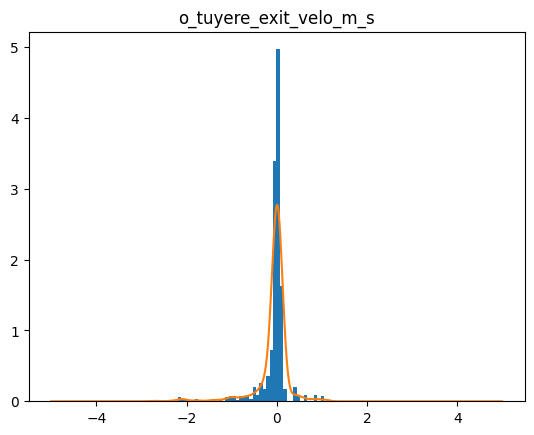

torch.Size([1000])
Epoch-3500 lr: 0.001
3501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3503  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3504  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3505  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3508  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3509  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3511  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3517  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3519  

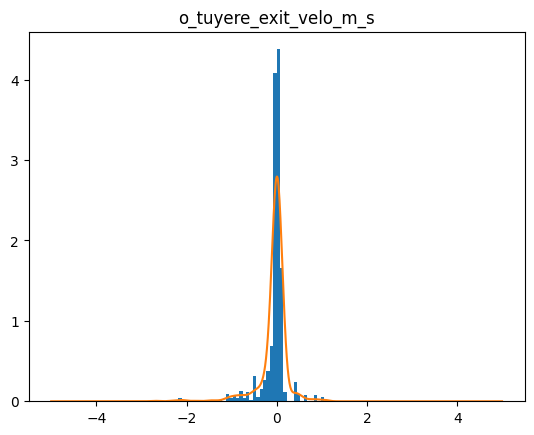

torch.Size([1000])
Epoch-3550 lr: 0.001
3551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3554  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3556  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3557  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3558  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3560  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3561  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3563  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3565  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3568  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3569  

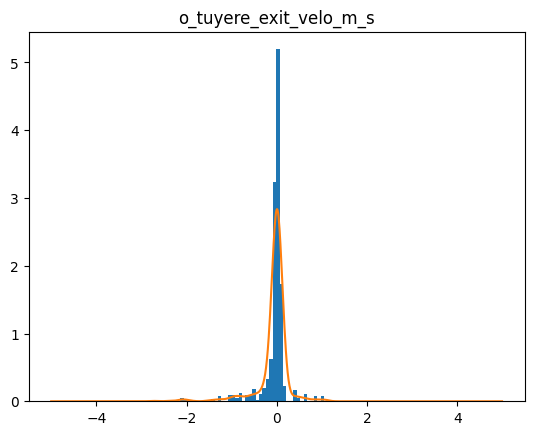

torch.Size([1000])
Epoch-3600 lr: 0.001
3601  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3602  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3603  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3604  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3606  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3608  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3609  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3612  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3614  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3617  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3618  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3619  

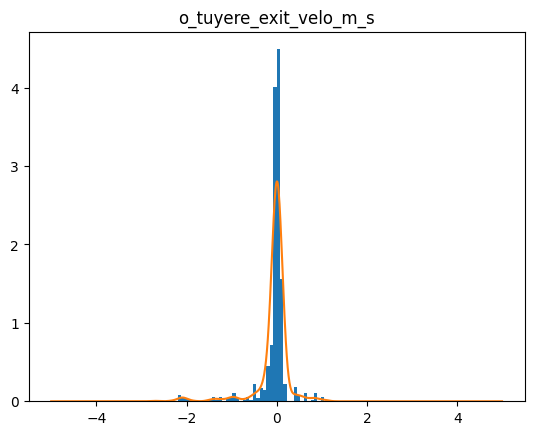

torch.Size([1000])
Epoch-3650 lr: 0.001
3651  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3654  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3655  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3656  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3657  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3658  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3659  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3661  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3665  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3667  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3668  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3669  

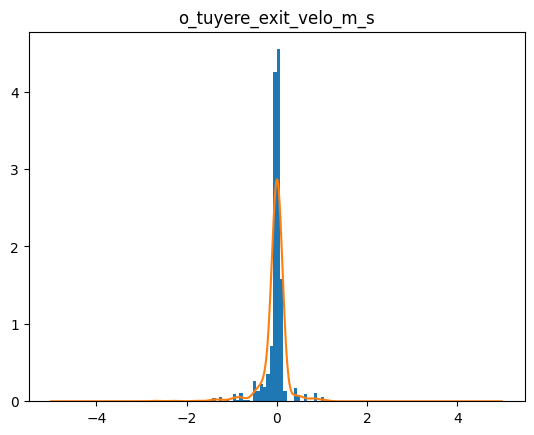

torch.Size([1000])
Epoch-3700 lr: 0.001
3701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3702  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3703  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3704  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3705  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3706  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3709  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3710  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3711  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3714  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3715  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3716  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3717  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3719  

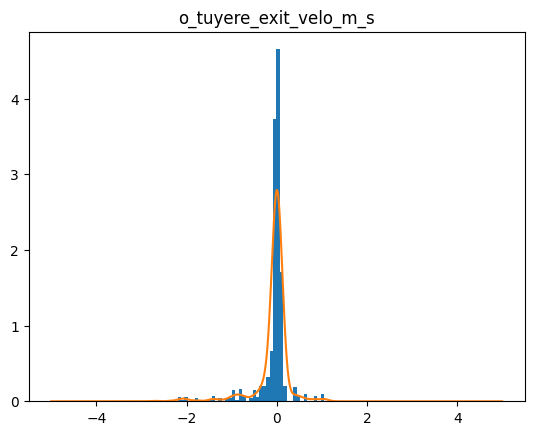

torch.Size([1000])
Epoch-3750 lr: 0.001
3751  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3760  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3761  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3764  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3767  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3768  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3769  

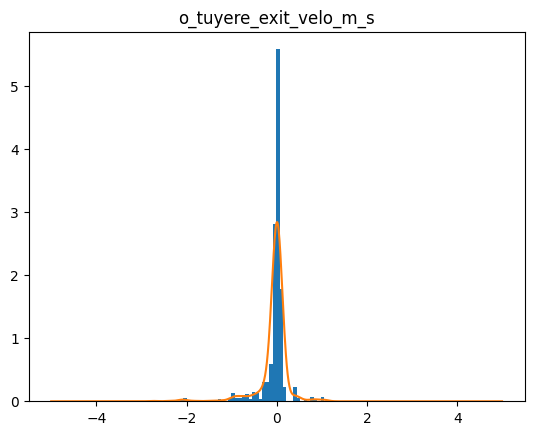

torch.Size([1000])
Epoch-3800 lr: 0.001
3801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3802  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3805  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3808  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3810  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3812  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3815  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3818  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3819  

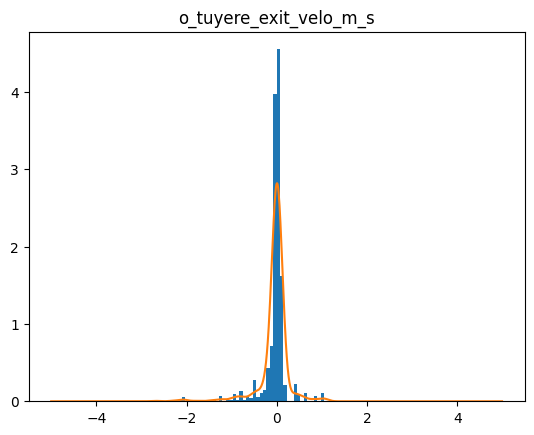

torch.Size([1000])
Epoch-3850 lr: 0.001
3851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3852  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3857  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3858  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3860  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3861  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3862  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3864  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3866  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3869  

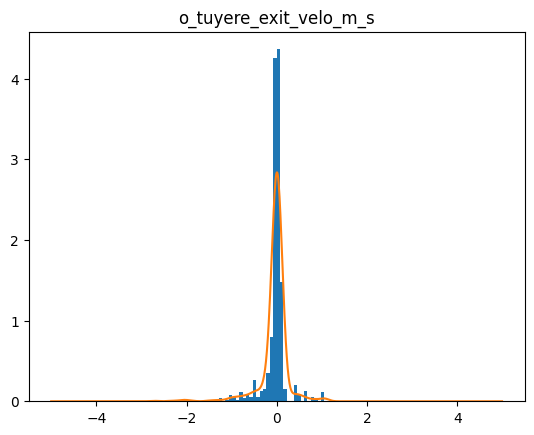

torch.Size([1000])
Epoch-3900 lr: 0.001
3901  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3902  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3903  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3904  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3906  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3907  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3908  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
3909  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3910  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3913  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3914  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3915  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3916  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3918  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3919  

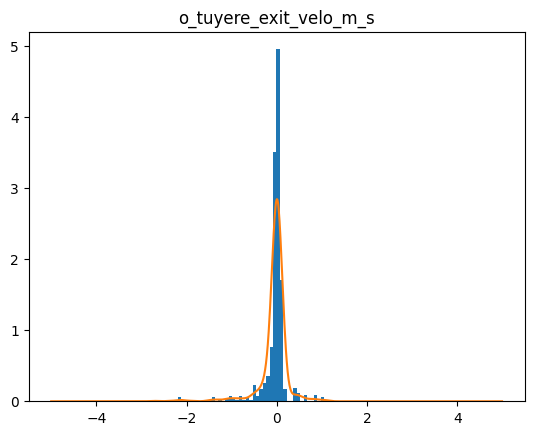

torch.Size([1000])
Epoch-3950 lr: 0.001
3951  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
3957  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3958  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3959  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3960  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3963  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3964  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3965  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
3967  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3968  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
3969  

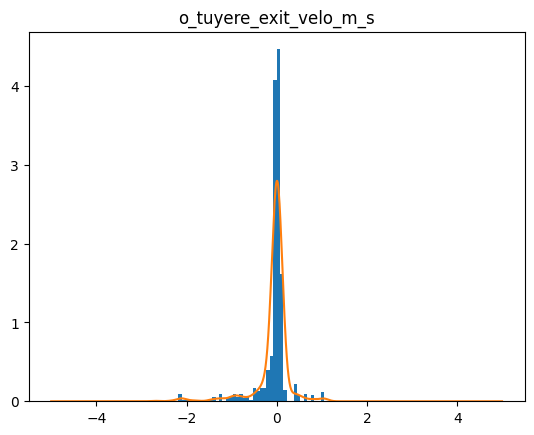

torch.Size([1000])
Epoch-4000 lr: 0.001
4001  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4002  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4004  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4005  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4006  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4007  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4008  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4009  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4010  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4012  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4013  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4017  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4018  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4019  

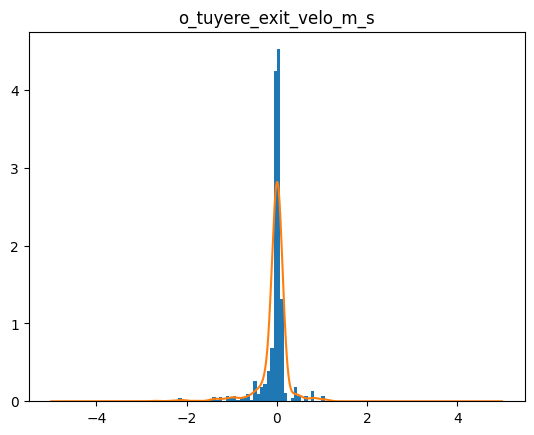

torch.Size([1000])
Epoch-4050 lr: 0.001
4051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4052  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4054  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4055  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4057  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4059  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4060  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4066  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
4067  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4068  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4069  

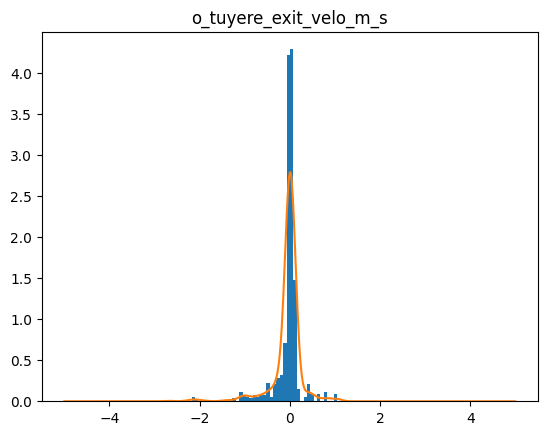

torch.Size([1000])
Epoch-4100 lr: 0.001
4101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4102  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4103  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4107  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4108  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4111  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4112  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4113  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4114  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4115  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4116  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4118  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4119  

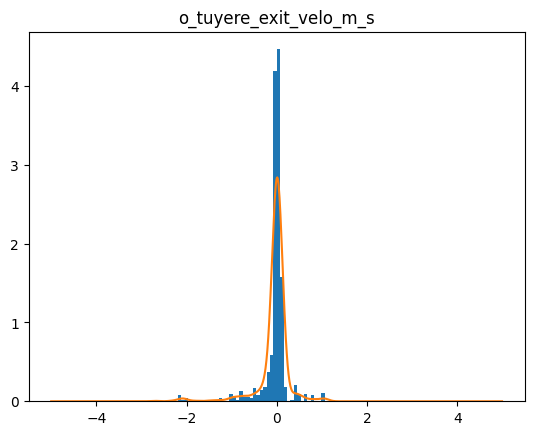

torch.Size([1000])
Epoch-4150 lr: 0.001
4151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4153  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4154  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4155  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4156  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4158  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4159  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4160  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4164  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4165  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4166  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4167  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4168  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4169  

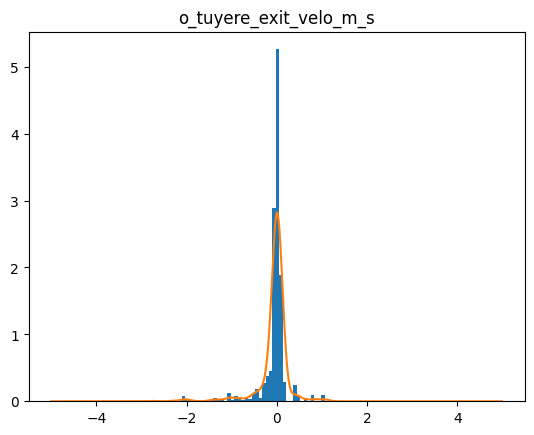

torch.Size([1000])
Epoch-4200 lr: 0.001
4201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4202  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4203  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4204  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4205  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4207  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4208  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4210  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4214  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4216  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4217  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4218  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4219  

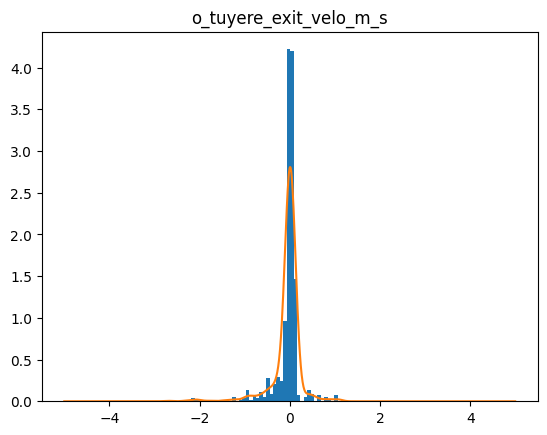

torch.Size([1000])
Epoch-4250 lr: 0.001
4251  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4252  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4254  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4257  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4258  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4260  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4262  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4265  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4266  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4267  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4268  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4269  

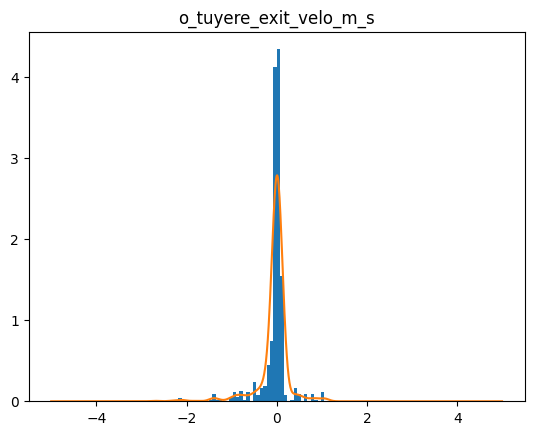

torch.Size([1000])
Epoch-4300 lr: 0.001
4301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4302  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4303  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4304  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4307  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4308  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4309  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4310  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4314  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4315  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4317  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4319  

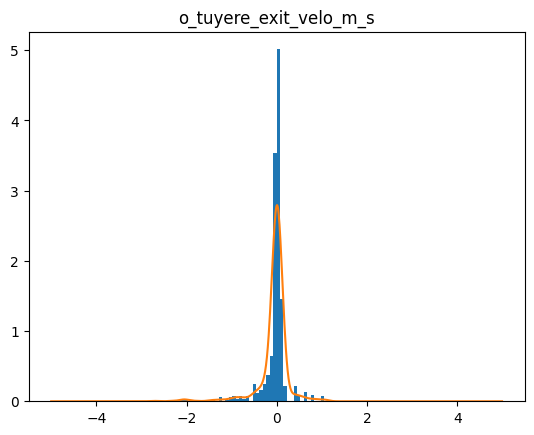

torch.Size([1000])
Epoch-4350 lr: 0.001
4351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4352  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4355  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4356  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4358  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4359  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4360  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4362  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4366  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4367  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4368  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4369  

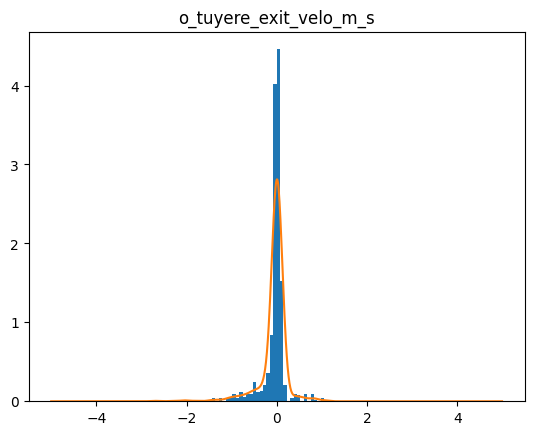

torch.Size([1000])
Epoch-4400 lr: 0.001
4401  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4402  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4403  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4404  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4406  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4408  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4410  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4411  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4412  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4415  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4416  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4417  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4419  

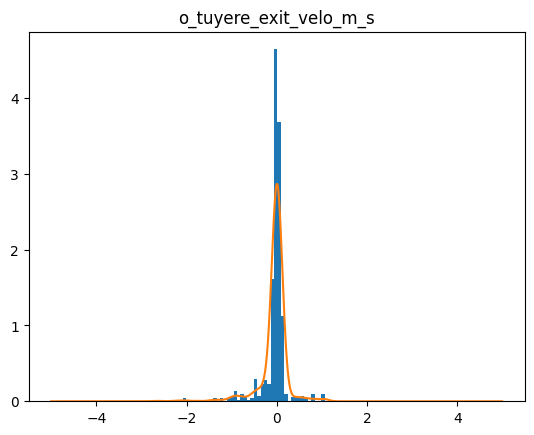

torch.Size([1000])
Epoch-4450 lr: 0.001
4451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4452  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4453  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4454  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4457  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4458  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4464  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4467  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4468  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4469  

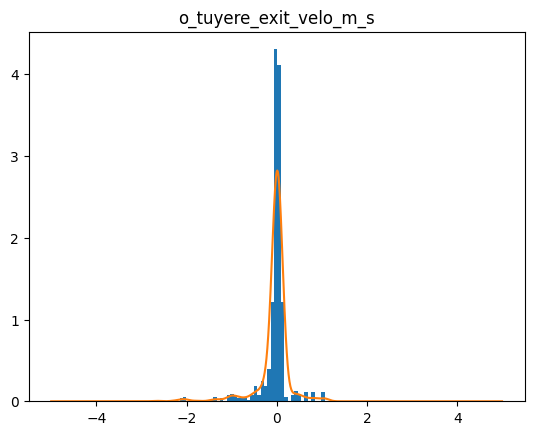

torch.Size([1000])
Epoch-4500 lr: 0.001
4501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4502  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4503  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4504  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4506  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4510  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4518  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4519  

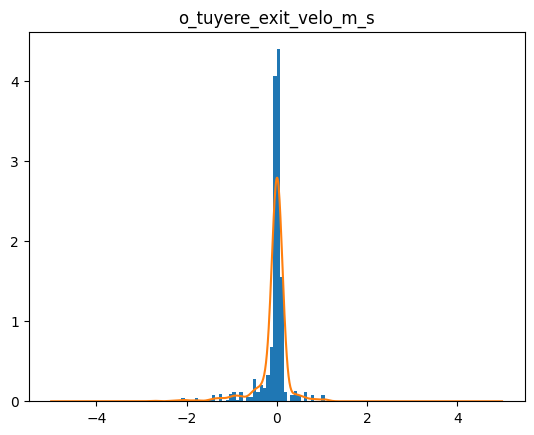

torch.Size([1000])
Epoch-4550 lr: 0.001
4551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4554  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4556  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4557  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4558  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4563  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4565  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4568  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4569  

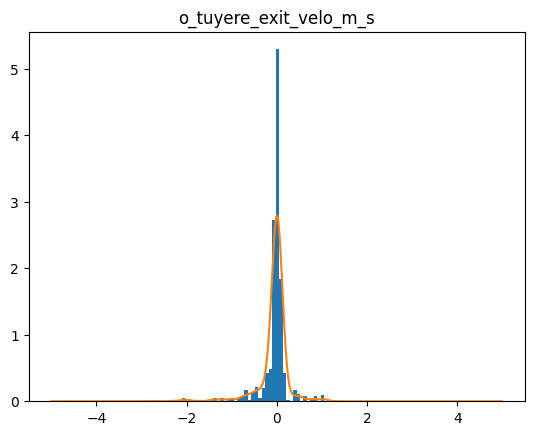

torch.Size([1000])
Epoch-4600 lr: 0.001
4601  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4602  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4604  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4605  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
4606  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4607  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4608  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4612  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4616  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4617  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4618  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4619  

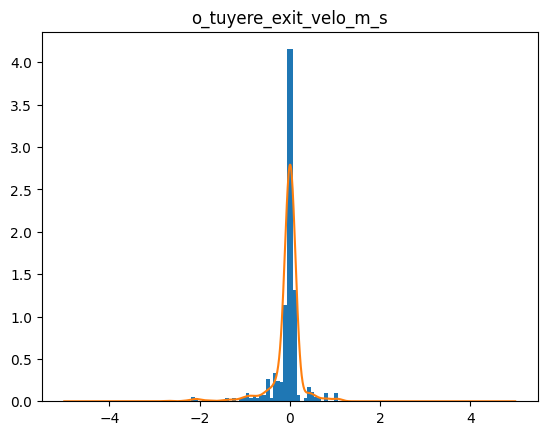

torch.Size([1000])
Epoch-4650 lr: 0.001
4651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4657  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4658  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4659  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4661  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4662  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4664  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4665  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4666  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4667  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4668  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4669  

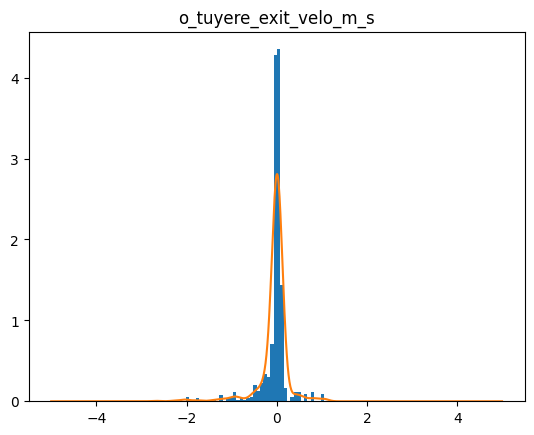

torch.Size([1000])
Epoch-4700 lr: 0.001
4701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4702  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4703  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4705  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4706  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4709  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4710  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4714  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4715  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4716  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4717  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4719  

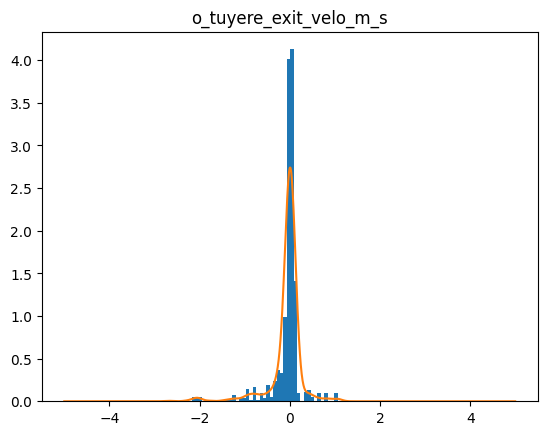

torch.Size([1000])
Epoch-4750 lr: 0.001
4751  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4752  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4760  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4761  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4764  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4768  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4769  

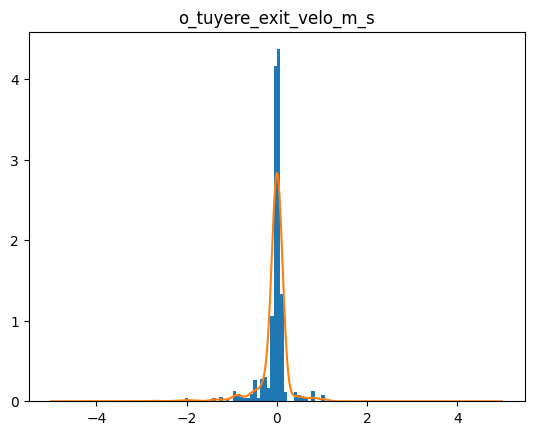

torch.Size([1000])
Epoch-4800 lr: 0.001
4801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4802  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4805  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4808  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4816  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4818  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4819  

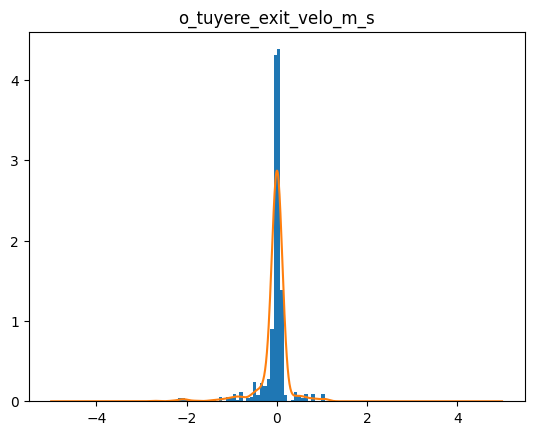

torch.Size([1000])
Epoch-4850 lr: 0.001
4851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4857  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4860  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4861  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4862  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4864  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4865  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4866  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4867  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4869  

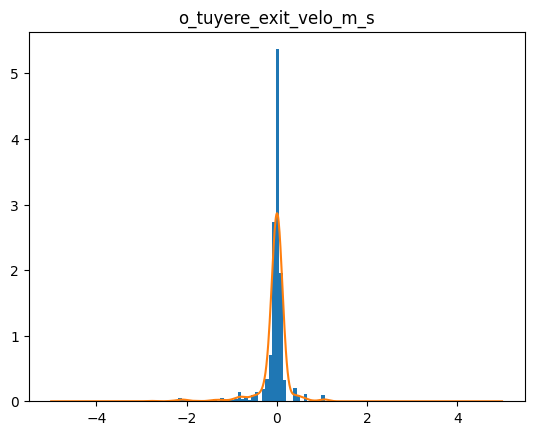

torch.Size([1000])
Epoch-4900 lr: 0.001
4901  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4902  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4903  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4904  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4908  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4909  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4912  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4915  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4918  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4919  

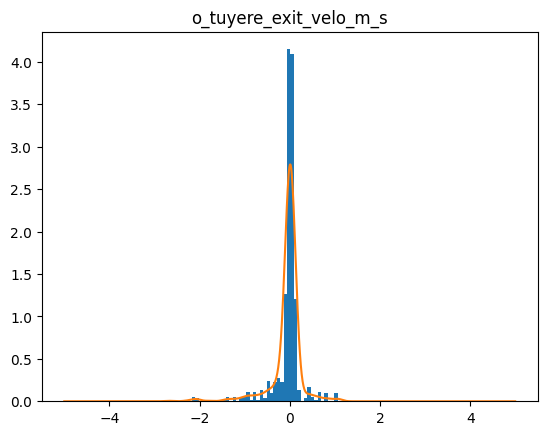

torch.Size([1000])
Epoch-4950 lr: 0.001
4951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4953  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4955  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4956  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4958  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4959  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
4961  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4963  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
4964  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4965  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4967  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4968  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
4969  

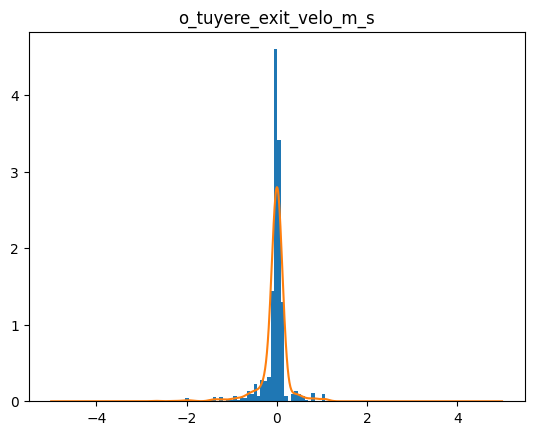

torch.Size([1000])
Epoch-5000 lr: 0.001
5001  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5004  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5005  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5006  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5007  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5008  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5009  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5013  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5016  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5017  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5018  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5019  

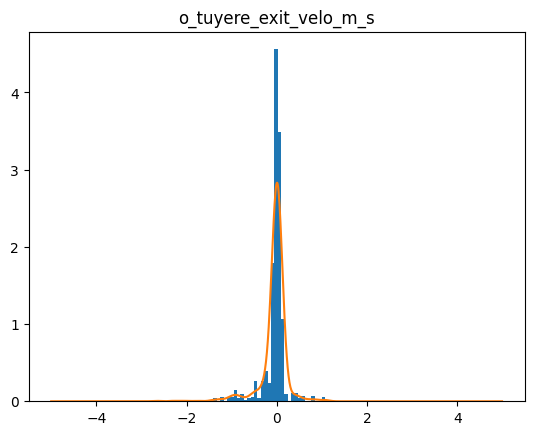

torch.Size([1000])
Epoch-5050 lr: 0.001
5051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5052  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5054  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5057  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5059  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5060  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5066  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5067  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5068  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5069  

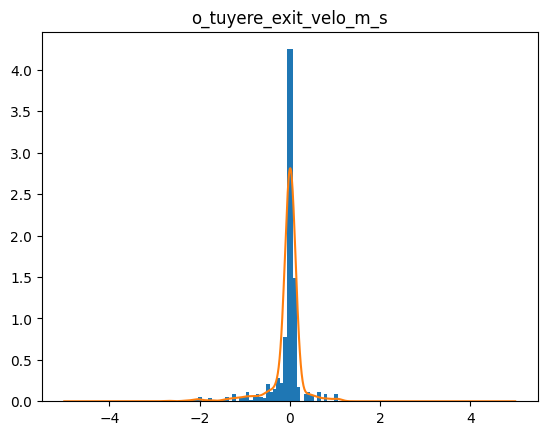

torch.Size([1000])
Epoch-5100 lr: 0.001
5101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5102  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5103  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5104  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5106  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5108  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5111  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5112  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5113  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5115  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5116  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5118  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5119  

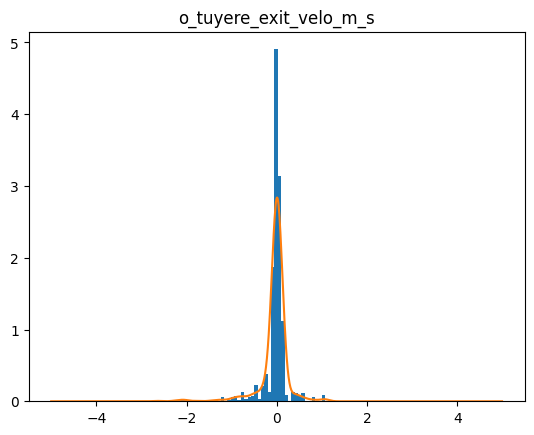

torch.Size([1000])
Epoch-5150 lr: 0.001
5151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5153  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5155  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5156  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5157  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5158  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5159  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5161  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5165  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5167  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5168  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5169  

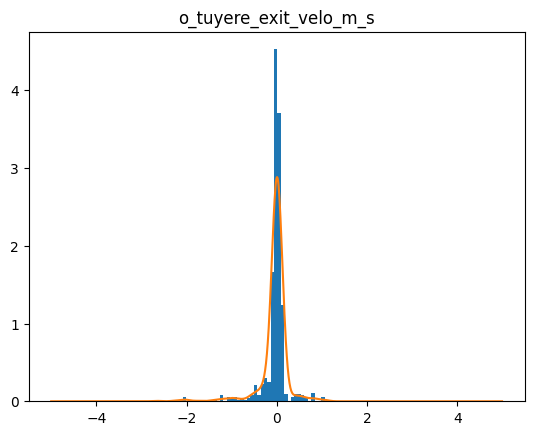

torch.Size([1000])
Epoch-5200 lr: 0.001
5201  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5202  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5204  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5207  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5211  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5212  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5214  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5216  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5217  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5218  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5219  

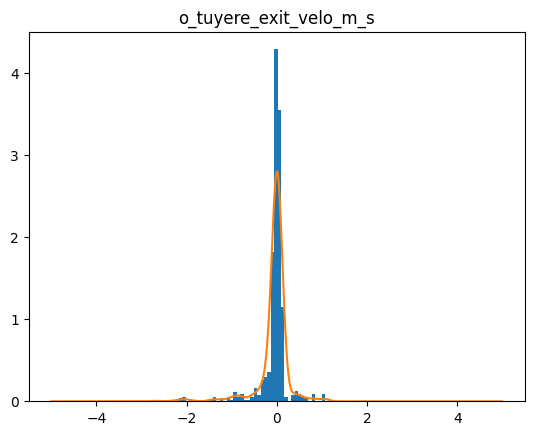

torch.Size([1000])
Epoch-5250 lr: 0.001
5251  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5254  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5256  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5257  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5258  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5259  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5260  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5262  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5264  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
5265  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5266  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5268  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5269  

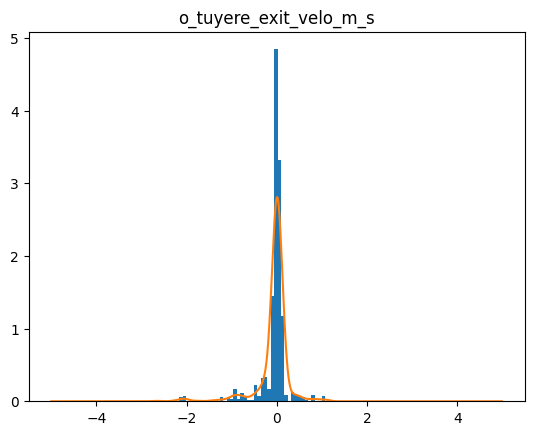

torch.Size([1000])
Epoch-5300 lr: 0.001
5301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5302  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5307  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5309  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5310  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5311  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5313  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5314  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5315  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5316  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5319  

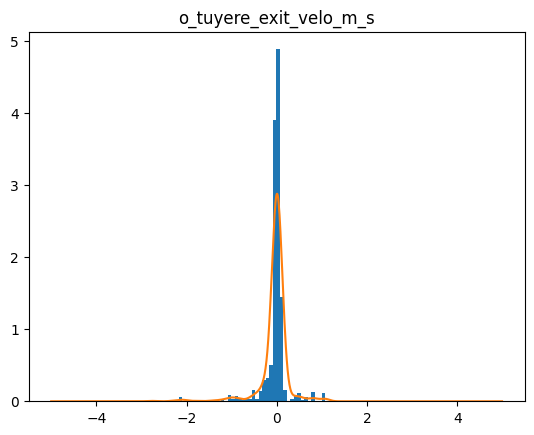

torch.Size([1000])
Epoch-5350 lr: 0.001
5351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5352  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5355  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5358  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5359  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5361  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5362  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5366  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5367  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5368  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5369  

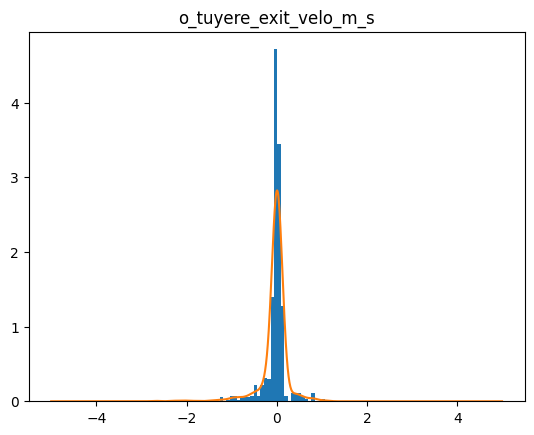

torch.Size([1000])
Epoch-5400 lr: 0.001
5401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5402  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5403  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5404  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5408  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5409  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5410  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5411  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5412  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5413  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5416  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5417  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5419  

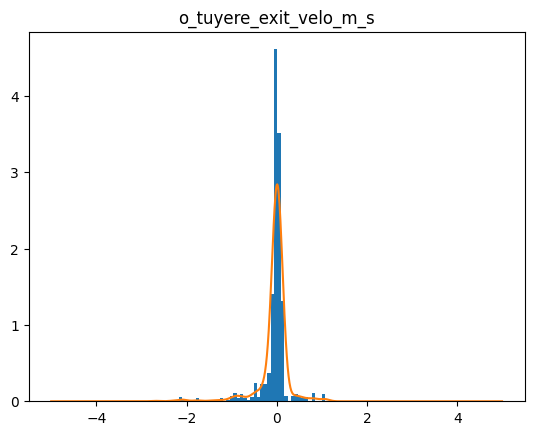

torch.Size([1000])
Epoch-5450 lr: 0.001
5451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5452  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5453  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5454  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5458  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5459  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5464  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5467  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5468  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5469  

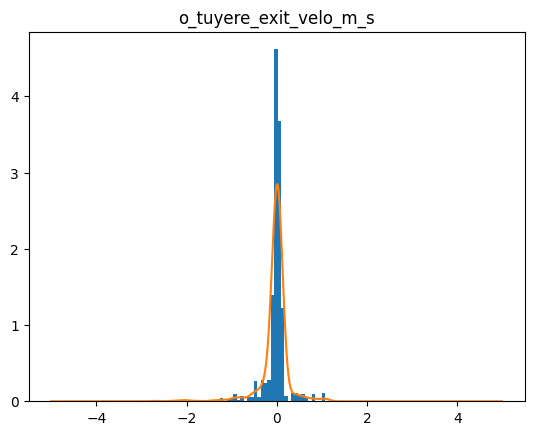

torch.Size([1000])
Epoch-5500 lr: 0.001
5501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5517  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5519  

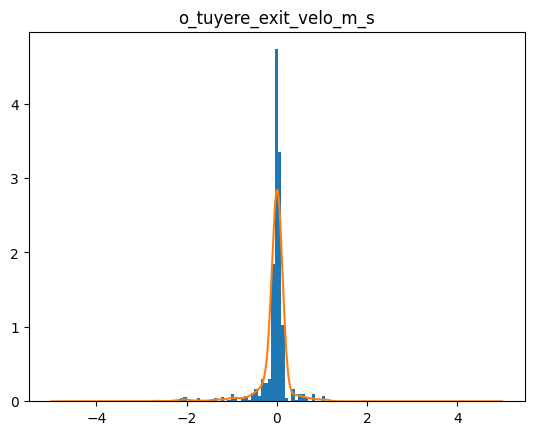

torch.Size([1000])
Epoch-5550 lr: 0.001
5551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5554  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5556  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5557  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5558  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5565  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5568  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5569  

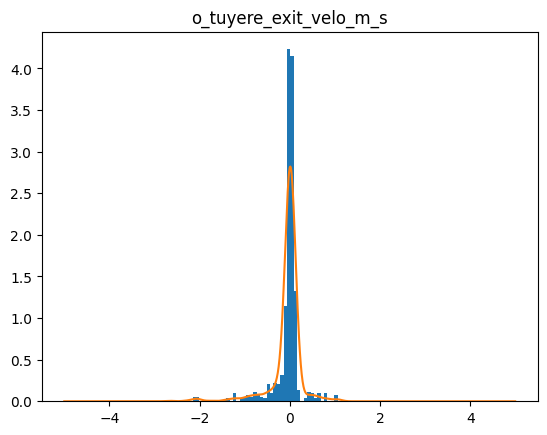

torch.Size([1000])
Epoch-5600 lr: 0.001
5601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5604  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5607  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5608  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5609  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5612  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5614  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5617  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5618  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5619  

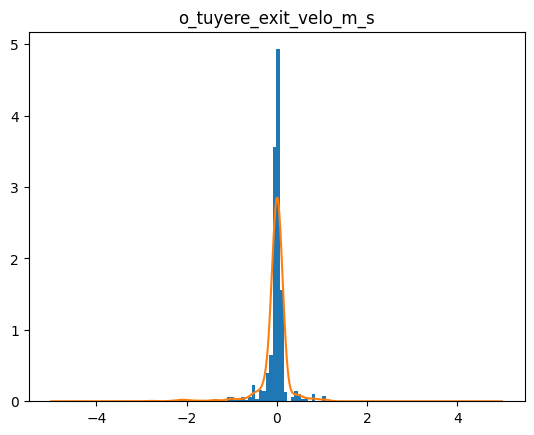

torch.Size([1000])
Epoch-5650 lr: 0.001
5651  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5653  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5654  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5657  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5658  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5659  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5661  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5662  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5665  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5666  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5667  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5668  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5669  

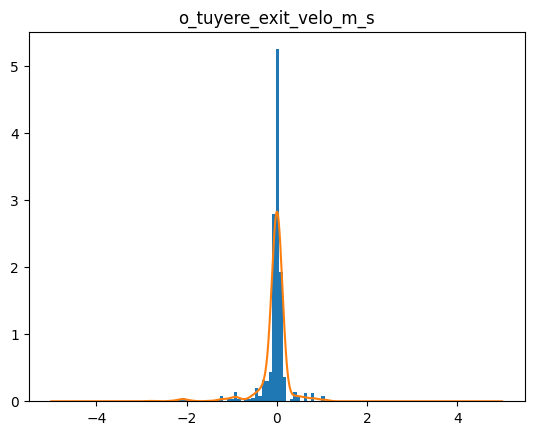

torch.Size([1000])
Epoch-5700 lr: 0.001
5701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5703  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5704  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5705  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5706  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5709  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5715  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5716  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5717  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5719  

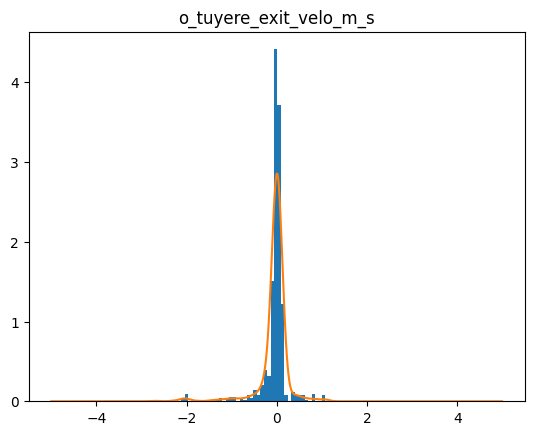

torch.Size([1000])
Epoch-5750 lr: 0.001
5751  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5752  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5755  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5759  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5760  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5761  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5764  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5768  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5769  

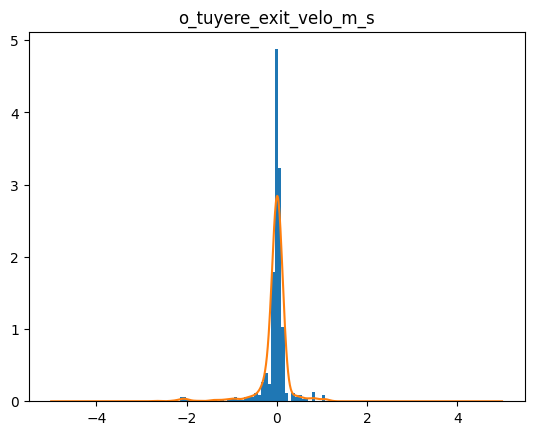

torch.Size([1000])
Epoch-5800 lr: 0.001
5801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5803  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
5804  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5805  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5807  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5810  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5812  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5813  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5816  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5818  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5819  

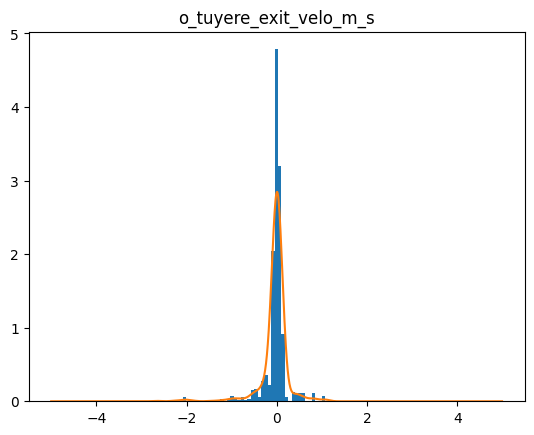

torch.Size([1000])
Epoch-5850 lr: 0.001
5851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5852  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5853  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5855  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5860  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5861  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5862  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5864  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5866  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5869  

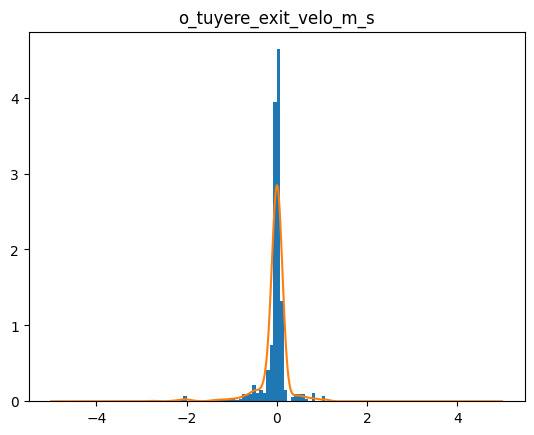

torch.Size([1000])
Epoch-5900 lr: 0.001
5901  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5902  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5903  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5904  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5907  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5909  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5912  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5913  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5915  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5918  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5919  

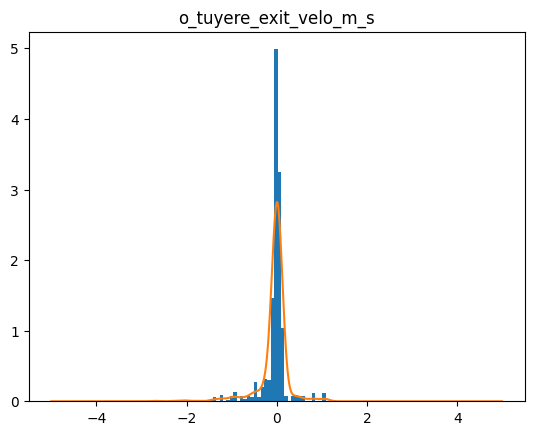

torch.Size([1000])
Epoch-5950 lr: 0.001
5951  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5953  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5956  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
5959  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5960  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5963  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5964  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5965  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
5966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5967  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5968  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
5969  

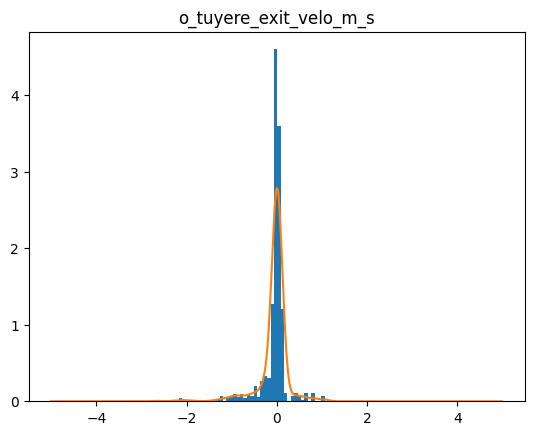

torch.Size([1000])
Epoch-6000 lr: 0.001
6001  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6002  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6004  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6006  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6007  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6008  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6009  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6013  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6015  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6016  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6017  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6018  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6019  

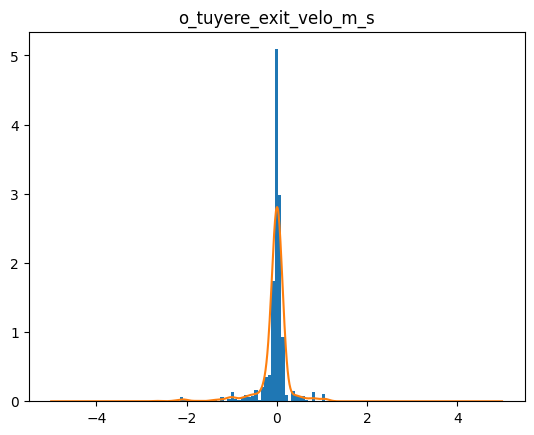

torch.Size([1000])
Epoch-6050 lr: 0.001
6051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6052  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6055  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6057  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6060  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6065  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6066  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6067  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6068  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6069  

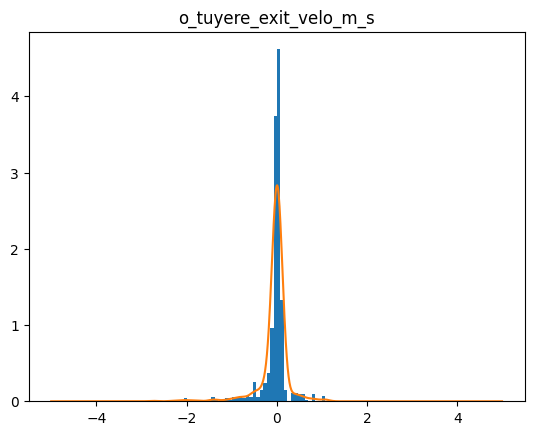

torch.Size([1000])
Epoch-6100 lr: 0.001
6101  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6104  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6106  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6108  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6111  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6112  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6113  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6116  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6118  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6119  

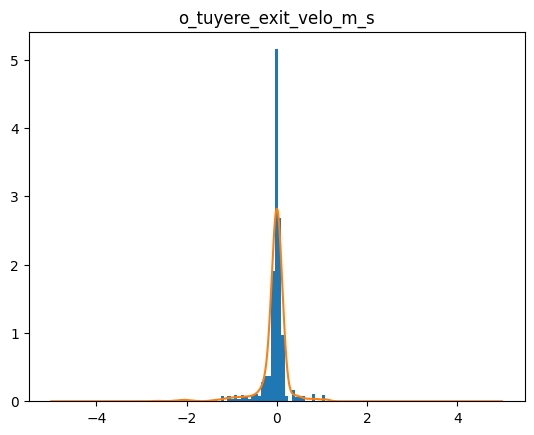

torch.Size([1000])
Epoch-6150 lr: 0.001
6151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6153  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6154  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6155  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6156  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6158  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6160  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6165  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6168  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6169  

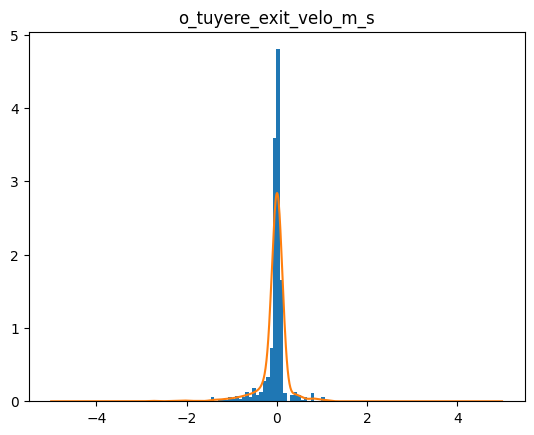

torch.Size([1000])
Epoch-6200 lr: 0.001
6201  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6202  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6203  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6204  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6206  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6208  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6211  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6214  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6216  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6217  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6218  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6219  

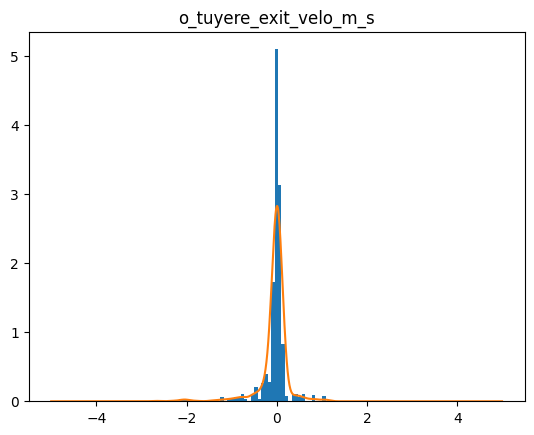

torch.Size([1000])
Epoch-6250 lr: 0.001
6251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6254  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6256  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6257  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6258  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6259  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6260  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6265  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6266  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6268  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6269  

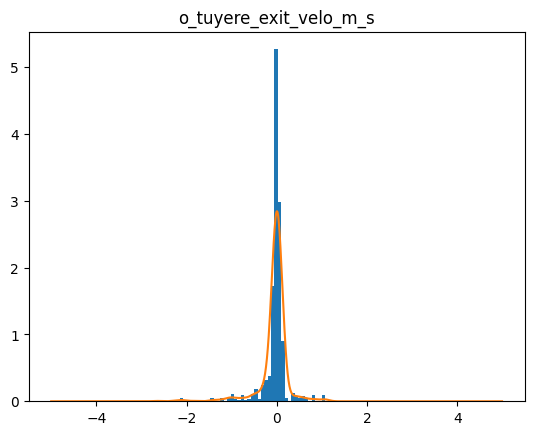

torch.Size([1000])
Epoch-6300 lr: 0.001
6301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6303  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6304  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6307  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6308  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6309  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6310  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6311  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
6312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6313  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6314  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6317  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6319  

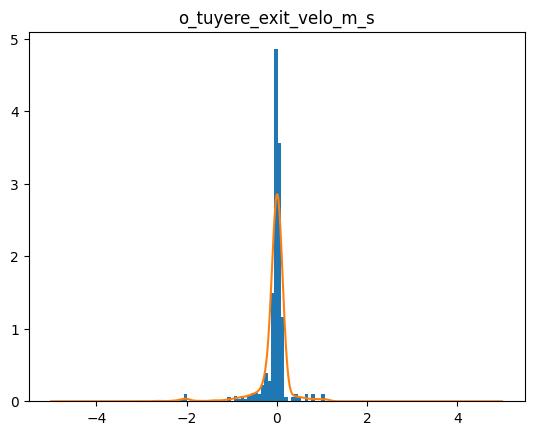

torch.Size([1000])
Epoch-6350 lr: 0.001
6351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6352  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6355  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6358  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6361  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6362  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6366  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6367  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6368  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6369  

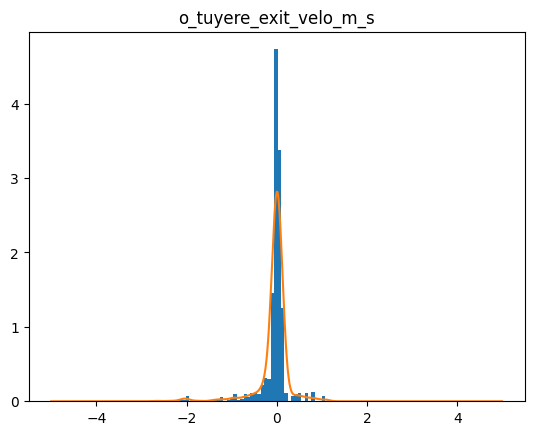

torch.Size([1000])
Epoch-6400 lr: 0.001
6401  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6402  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6403  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6406  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6408  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6409  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6410  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6411  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6412  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6413  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6416  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6419  

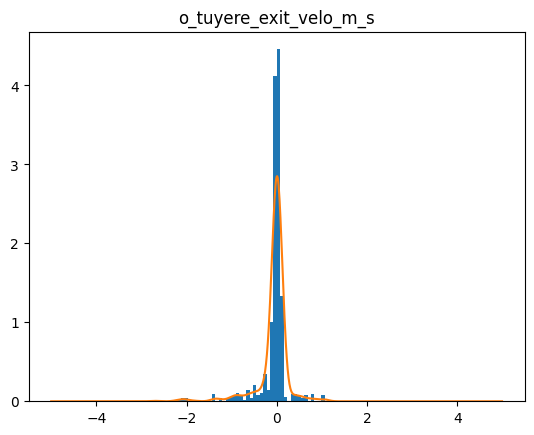

torch.Size([1000])
Epoch-6450 lr: 0.001
6451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6452  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6453  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6454  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6458  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6459  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6464  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6467  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6468  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6469  

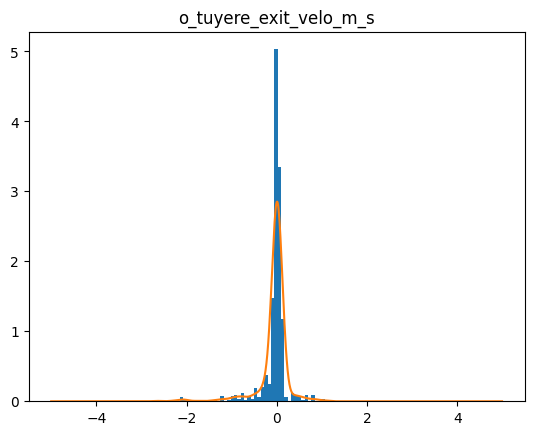

torch.Size([1000])
Epoch-6500 lr: 0.001
6501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6502  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6503  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6504  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6505  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6510  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6512  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6519  

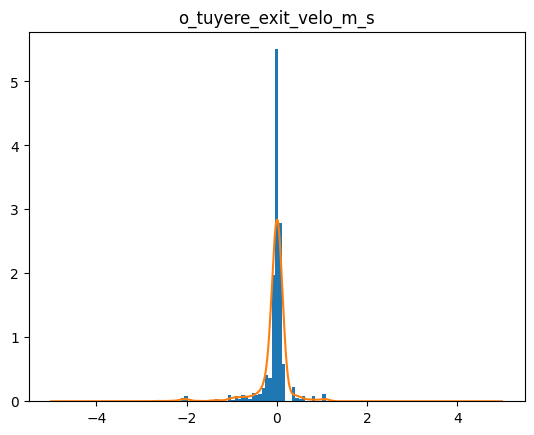

torch.Size([1000])
Epoch-6550 lr: 0.001
6551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6554  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6555  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6556  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6561  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6565  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6568  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6569  

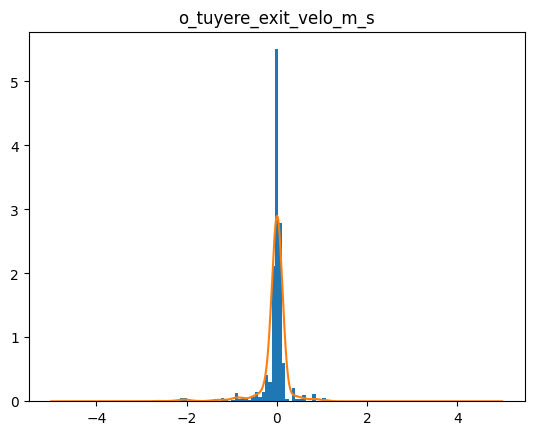

torch.Size([1000])
Epoch-6600 lr: 0.001
6601  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6602  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6604  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6606  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6607  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6608  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6609  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6612  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6614  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6616  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6618  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6619  

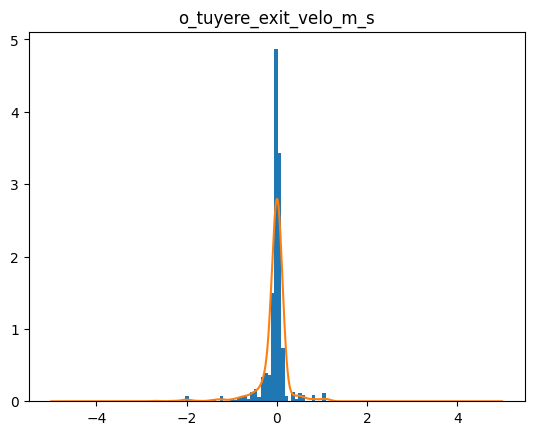

torch.Size([1000])
Epoch-6650 lr: 0.001
6651  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6654  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6655  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6656  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6657  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6658  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6659  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6662  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6665  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6666  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6667  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6668  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6669  

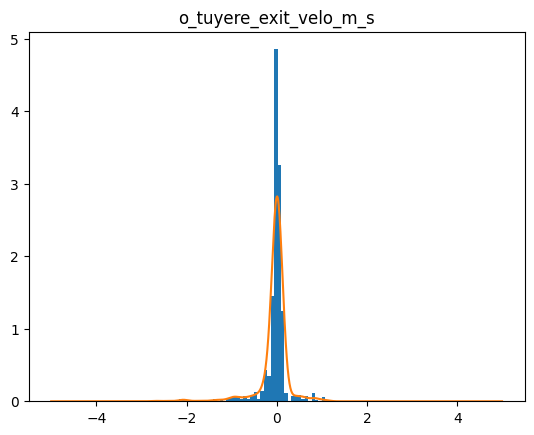

torch.Size([1000])
Epoch-6700 lr: 0.001
6701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6703  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6704  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6705  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6709  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6710  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6714  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6717  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6719  

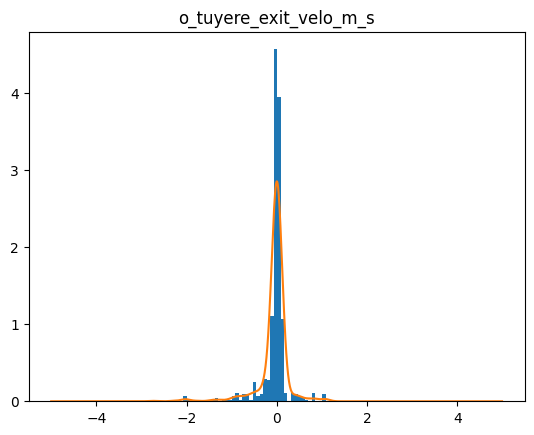

torch.Size([1000])
Epoch-6750 lr: 0.001
6751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6755  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6760  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6761  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6768  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6769  

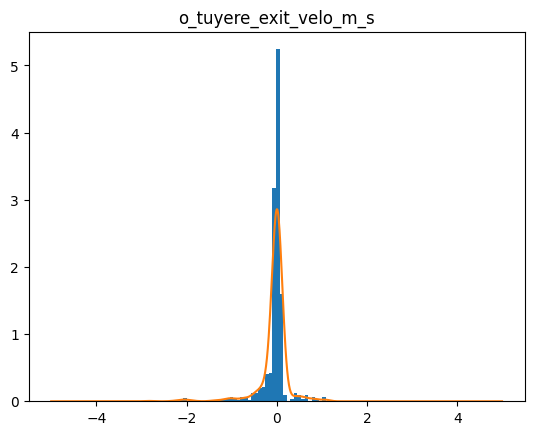

torch.Size([1000])
Epoch-6800 lr: 0.001
6801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6802  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6804  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6805  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6812  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6818  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6819  

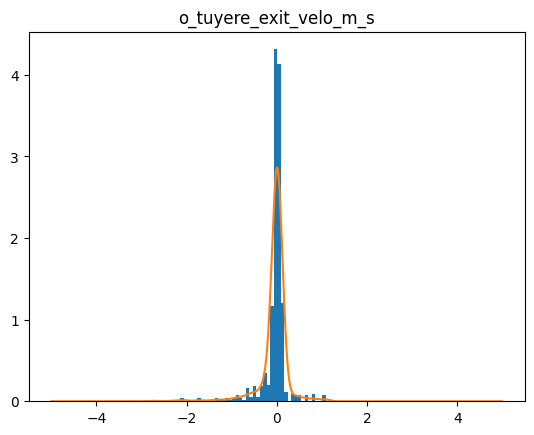

torch.Size([1000])
Epoch-6850 lr: 0.001
6851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6855  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6860  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6861  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6862  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6864  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6866  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6867  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6869  

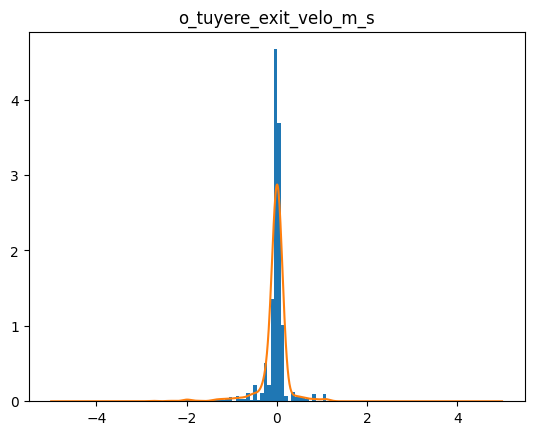

torch.Size([1000])
Epoch-6900 lr: 0.001
6901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6902  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6903  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6904  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6908  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6918  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6919  

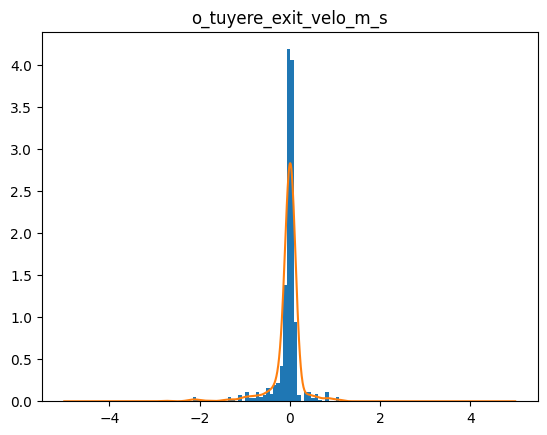

torch.Size([1000])
Epoch-6950 lr: 0.001
6951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6953  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6954  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
6955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6956  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6957  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6959  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6960  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6963  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6964  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6965  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6967  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
6968  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
6969  

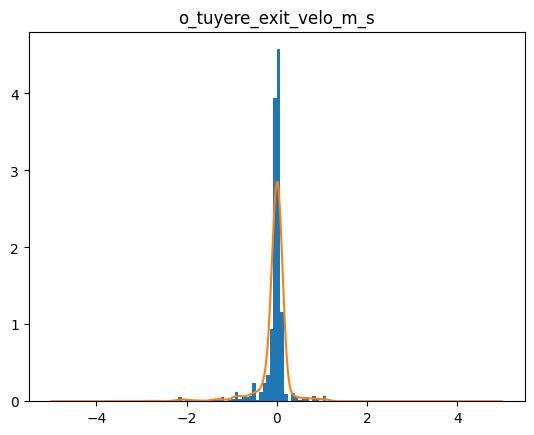

torch.Size([1000])
Epoch-7000 lr: 0.001
7001  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7002  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7004  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7005  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7007  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7008  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7009  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7013  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7016  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7018  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7019  

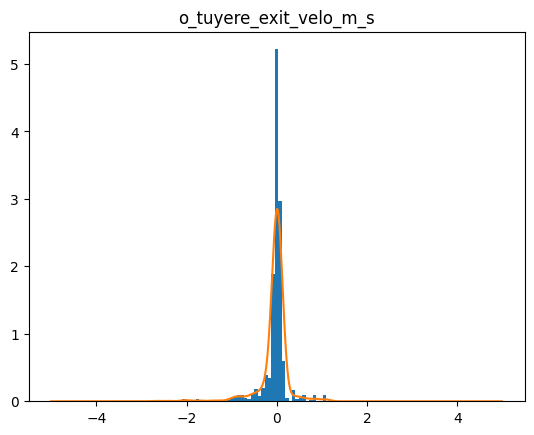

torch.Size([1000])
Epoch-7050 lr: 0.001
7051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7052  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7054  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7055  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7058  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7059  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7060  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7066  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7067  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7068  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7069  

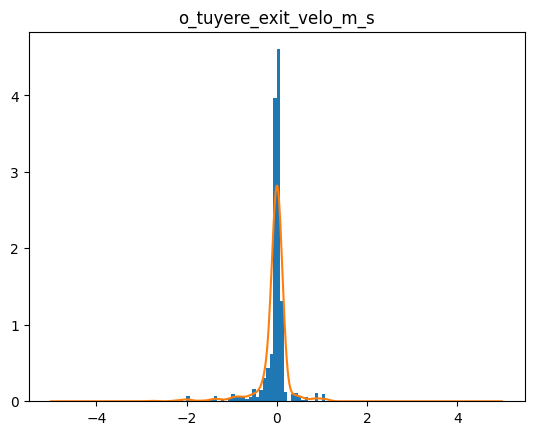

torch.Size([1000])
Epoch-7100 lr: 0.001
7101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7103  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7104  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7107  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7108  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7111  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7112  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7115  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7118  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7119  

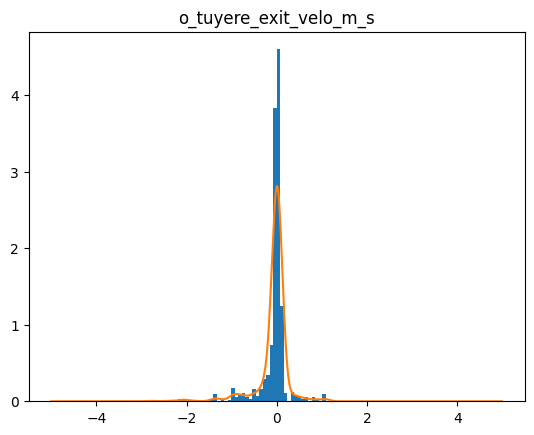

torch.Size([1000])
Epoch-7150 lr: 0.001
7151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7153  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7154  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7155  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7158  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7159  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7161  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7162  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7164  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7165  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7167  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7168  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7169  

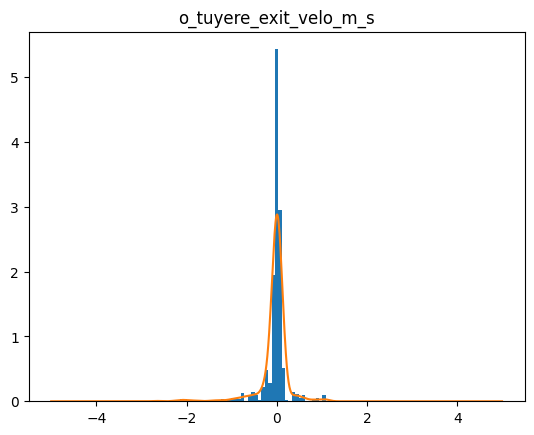

torch.Size([1000])
Epoch-7200 lr: 0.001
7201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7204  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7207  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7208  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7212  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7214  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7216  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7217  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7218  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7219  

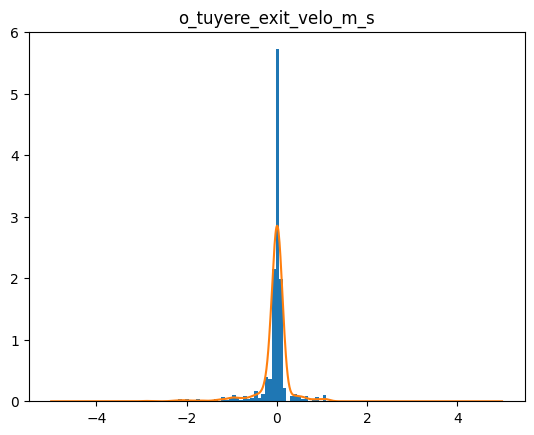

torch.Size([1000])
Epoch-7250 lr: 0.001
7251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7256  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7258  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7260  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7262  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7265  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7268  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7269  

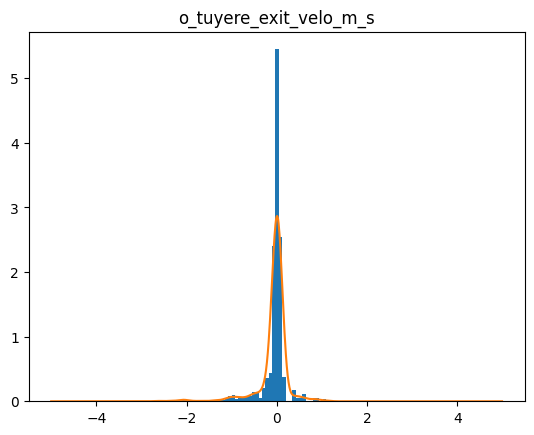

torch.Size([1000])
Epoch-7300 lr: 0.001
7301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7302  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7304  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7308  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7309  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7310  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7313  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7314  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7315  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7317  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7319  

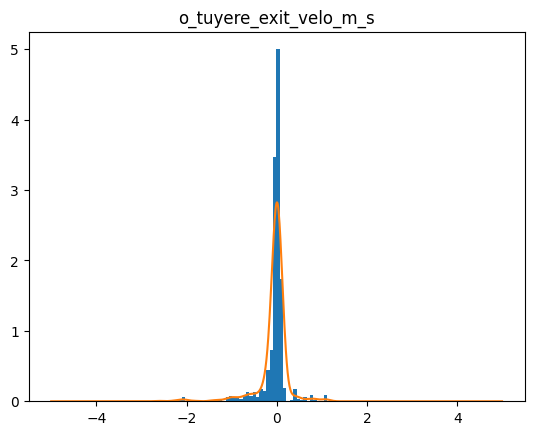

torch.Size([1000])
Epoch-7350 lr: 0.001
7351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7352  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7358  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7359  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7360  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7362  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7366  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7367  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7368  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7369  

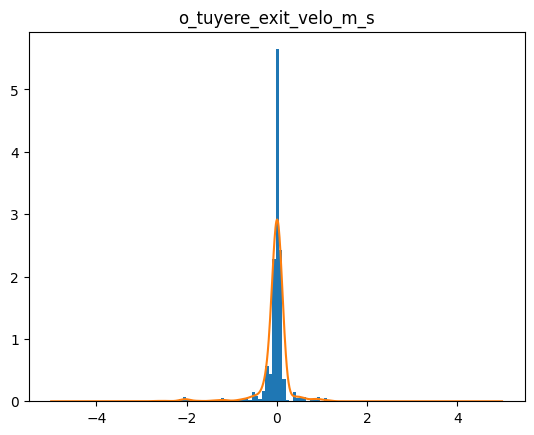

torch.Size([1000])
Epoch-7400 lr: 0.001
7401  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7403  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7404  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7406  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7408  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7410  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7411  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7412  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7416  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7419  

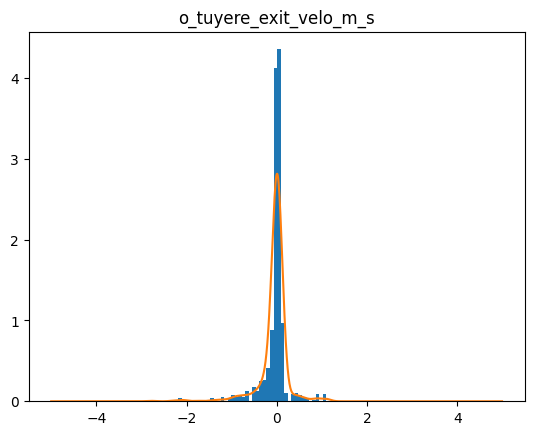

torch.Size([1000])
Epoch-7450 lr: 0.001
7451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7453  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7458  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7464  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7467  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7468  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7469  

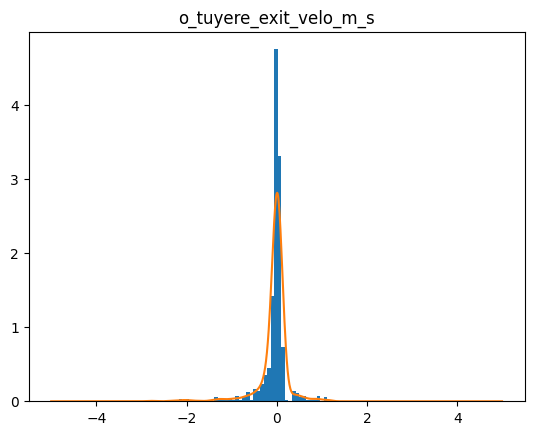

torch.Size([1000])
Epoch-7500 lr: 0.001
7501  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7503  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7504  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7505  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7510  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7517  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7519  

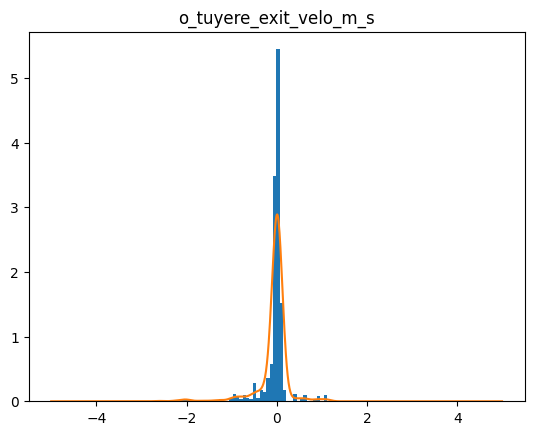

torch.Size([1000])
Epoch-7550 lr: 0.001
7551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7554  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7558  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7563  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7568  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7569  

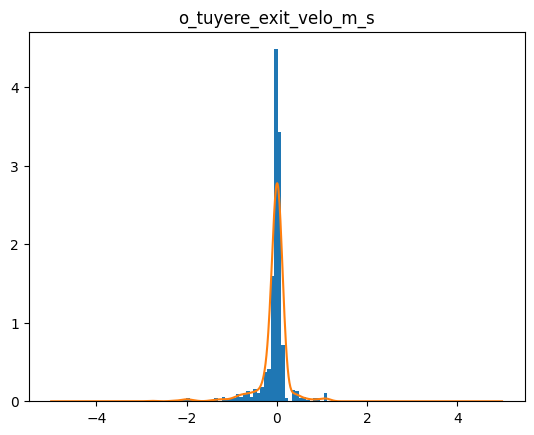

torch.Size([1000])
Epoch-7600 lr: 0.001
7601  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7604  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7606  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7607  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7608  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7609  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7617  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7618  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7619  

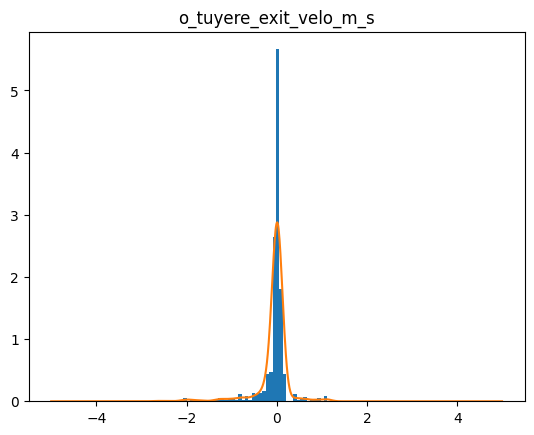

torch.Size([1000])
Epoch-7650 lr: 0.001
7651  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7658  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7661  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7666  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7668  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7669  

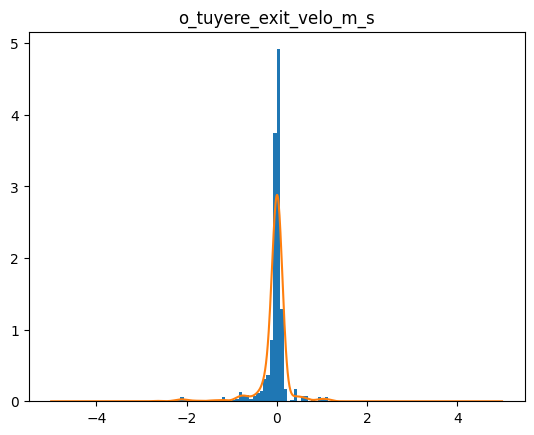

torch.Size([1000])
Epoch-7700 lr: 0.001
7701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7702  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7704  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7712  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7714  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7716  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7719  

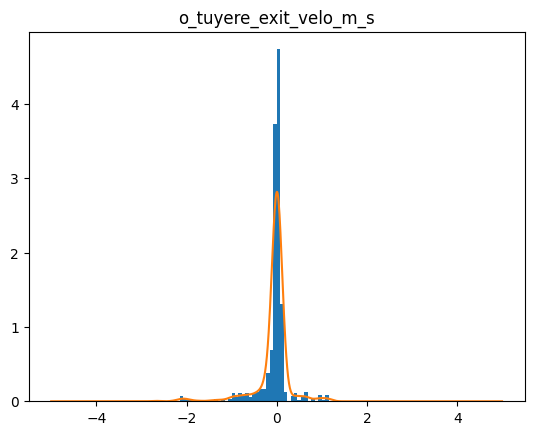

torch.Size([1000])
Epoch-7750 lr: 0.001
7751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7752  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7757  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7761  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7763  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7764  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7768  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7769  

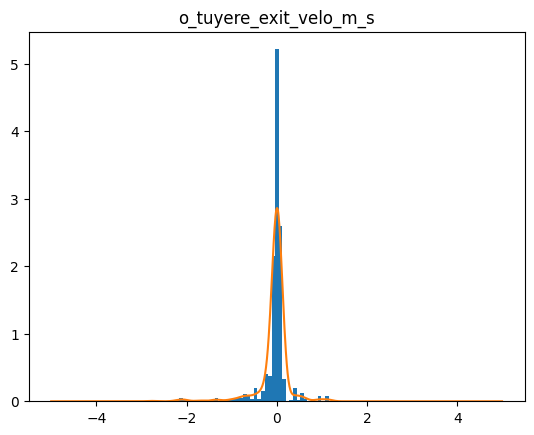

torch.Size([1000])
Epoch-7800 lr: 0.001
7801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7802  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7803  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7810  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7812  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7814  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7815  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7816  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7818  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7819  

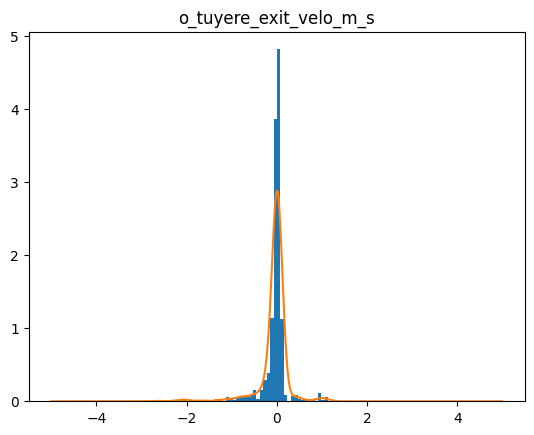

torch.Size([1000])
Epoch-7850 lr: 0.001
7851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7852  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7860  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7869  

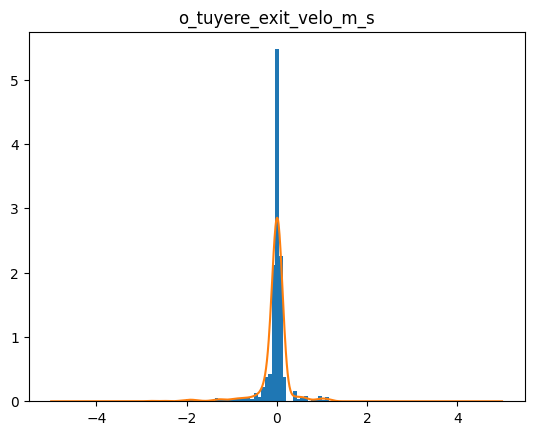

torch.Size([1000])
Epoch-7900 lr: 0.001
7901  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7903  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7907  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7909  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7915  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7917  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
7918  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7919  

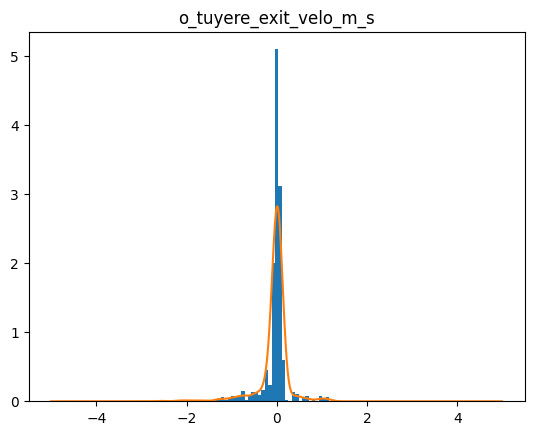

torch.Size([1000])
Epoch-7950 lr: 0.001
7951  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7956  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7958  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7963  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7965  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
7967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7968  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
7969  

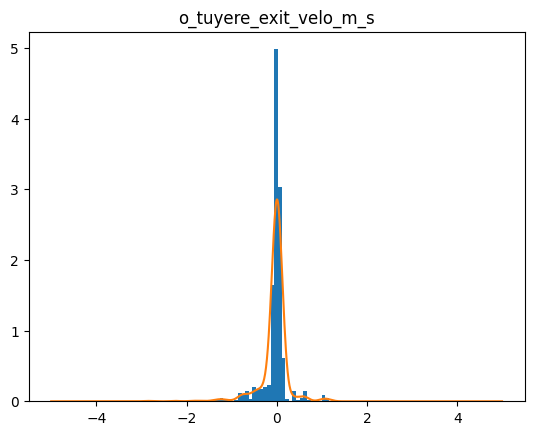

torch.Size([1000])
Epoch-8000 lr: 0.001
8001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8002  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8016  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8018  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8019  

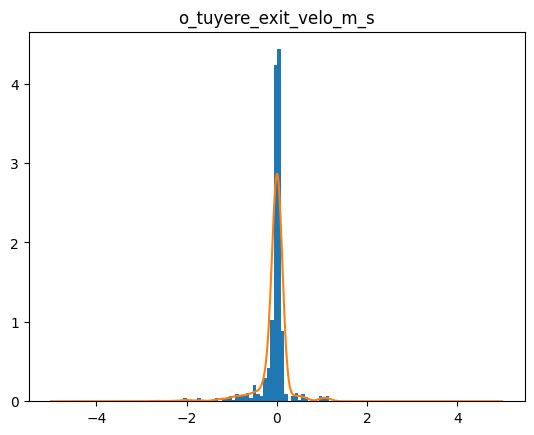

torch.Size([1000])
Epoch-8050 lr: 0.001
8051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8054  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8055  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8060  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8066  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8068  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8069  

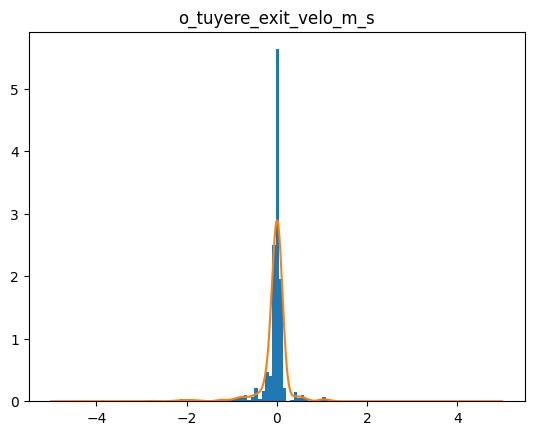

torch.Size([1000])
Epoch-8100 lr: 0.001
8101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8102  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8104  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8112  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
8113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8116  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8118  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8119  

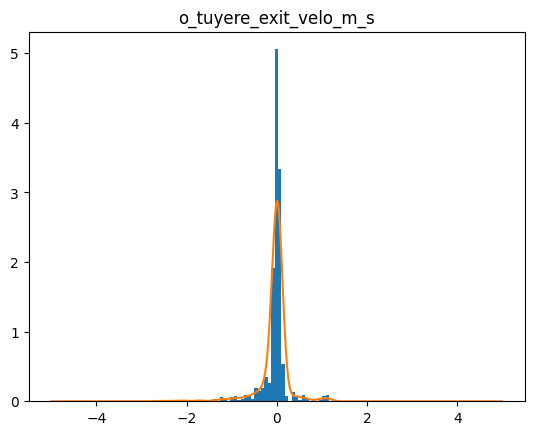

torch.Size([1000])
Epoch-8150 lr: 0.001
8151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8153  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
8154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8158  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8161  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8167  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8168  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8169  

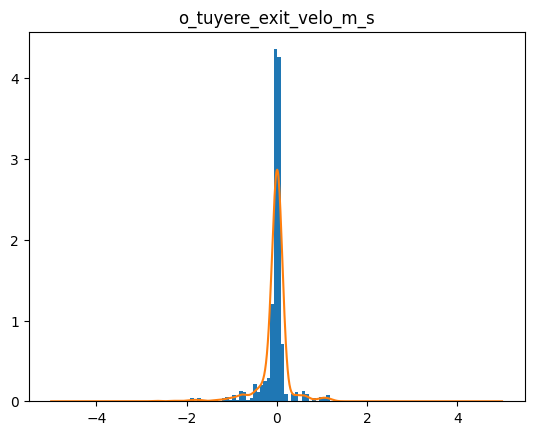

torch.Size([1000])
Epoch-8200 lr: 0.001
8201  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8204  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
8205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8210  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8211  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8214  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8216  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8217  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
8218  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8219  

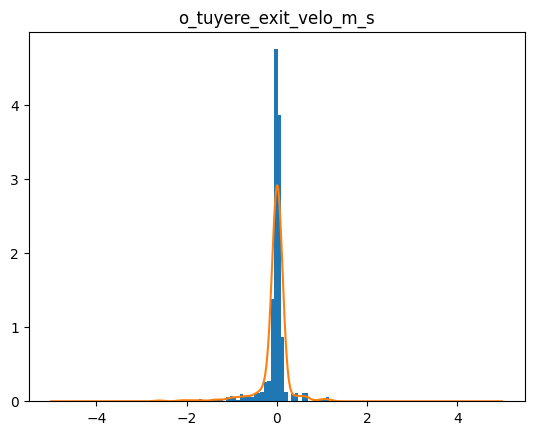

torch.Size([1000])
Epoch-8250 lr: 0.001
8251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8256  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8257  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8262  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8266  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8268  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8269  

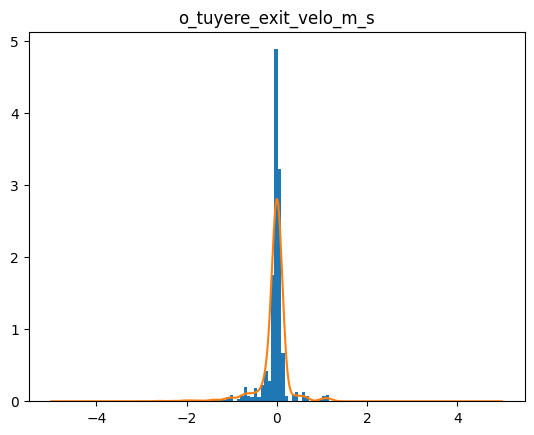

torch.Size([1000])
Epoch-8300 lr: 0.001
8301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8302  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8303  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8304  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8307  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8308  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8311  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8313  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8316  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8317  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8319  

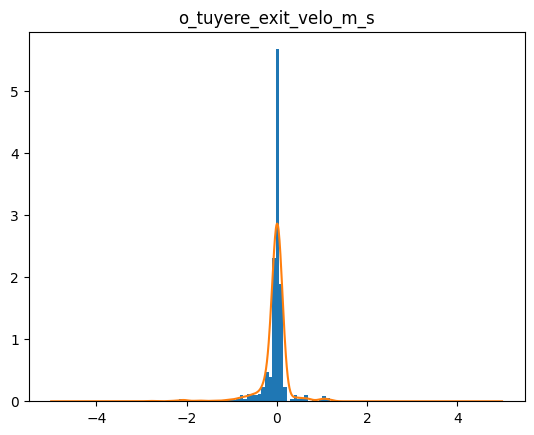

torch.Size([1000])
Epoch-8350 lr: 0.001
8351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8354  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8359  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8360  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8361  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8362  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8368  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8369  

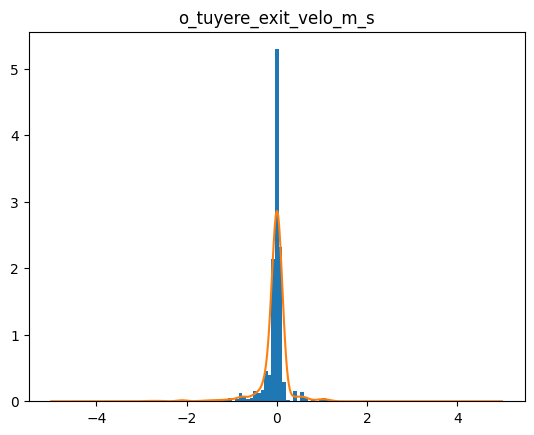

torch.Size([1000])
Epoch-8400 lr: 0.001
8401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8403  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
8404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8406  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8409  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8410  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8412  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8418  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8419  

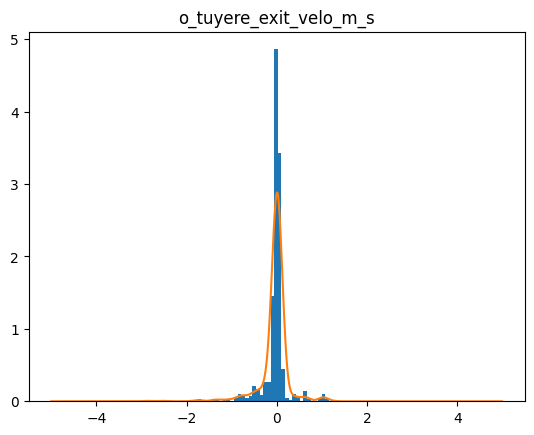

torch.Size([1000])
Epoch-8450 lr: 0.001
8451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8452  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8453  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8454  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8455  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8463  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8464  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8468  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8469  

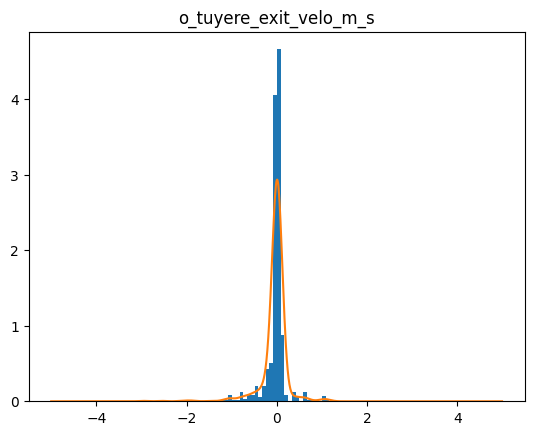

torch.Size([1000])
Epoch-8500 lr: 0.001
8501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8505  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8510  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8512  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8519  

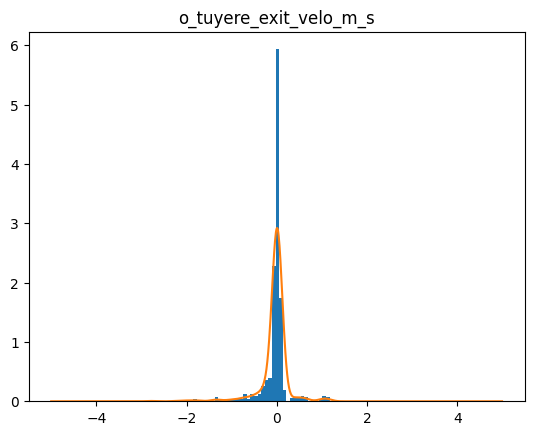

torch.Size([1000])
Epoch-8550 lr: 0.001
8551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8561  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8568  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8569  

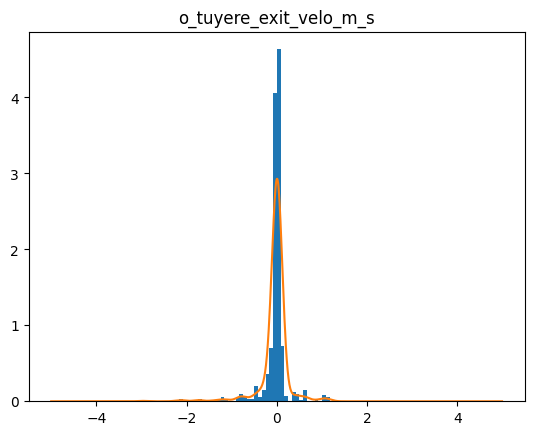

torch.Size([1000])
Epoch-8600 lr: 0.001
8601  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8607  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8618  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8619  

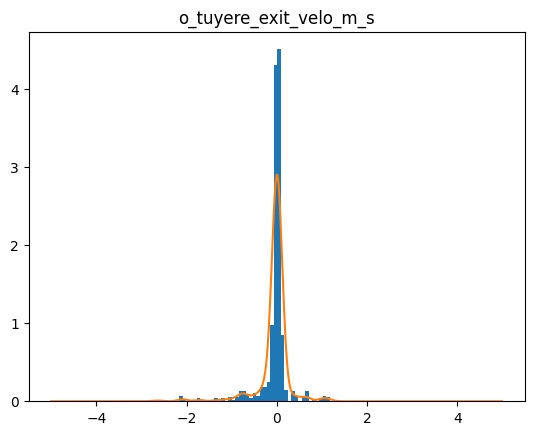

torch.Size([1000])
Epoch-8650 lr: 0.001
8651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8656  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8657  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
8658  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8659  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8665  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8668  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8669  

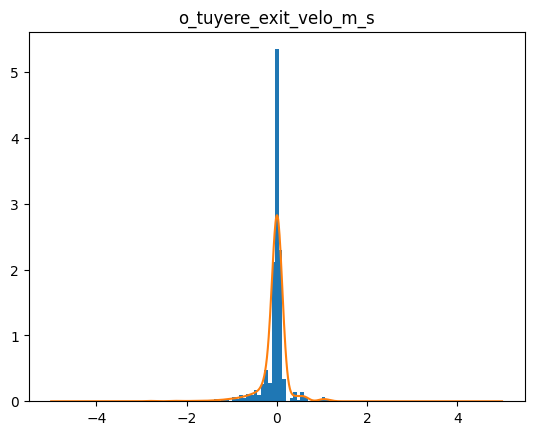

torch.Size([1000])
Epoch-8700 lr: 0.001
8701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8702  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8705  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8706  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8710  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8715  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8718  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8719  

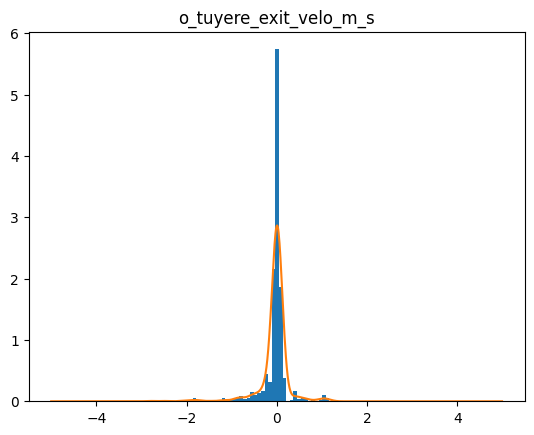

torch.Size([1000])
Epoch-8750 lr: 0.001
8751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8752  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8767  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8768  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8769  

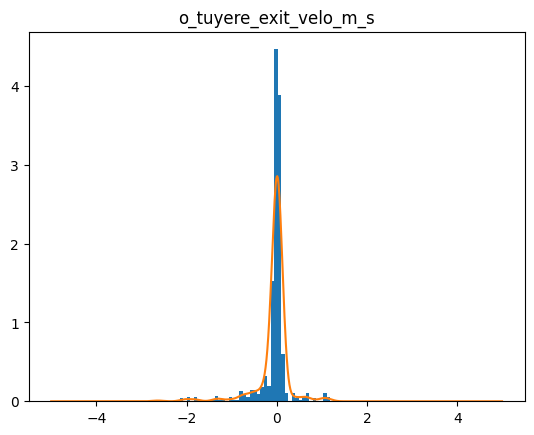

torch.Size([1000])
Epoch-8800 lr: 0.001
8801  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8803  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8805  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8811  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8812  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8818  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8819  

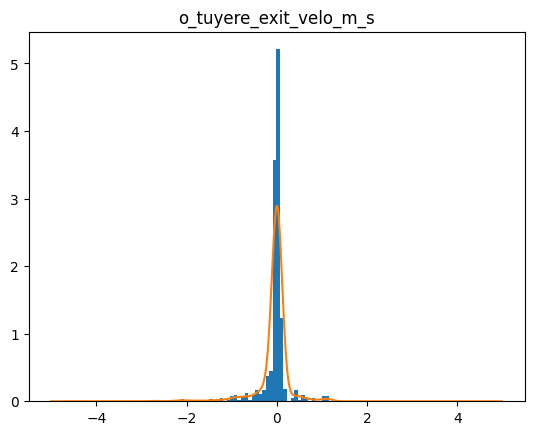

torch.Size([1000])
Epoch-8850 lr: 0.001
8851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8867  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8868  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8869  

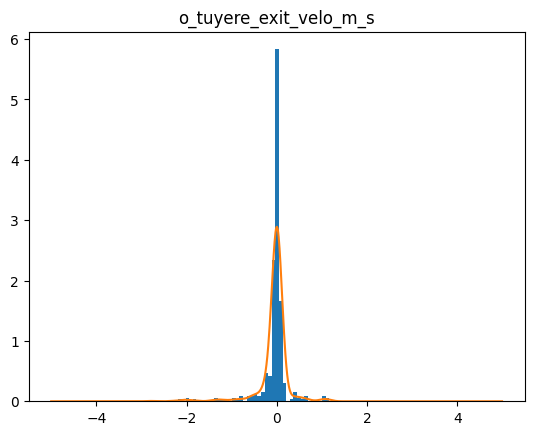

torch.Size([1000])
Epoch-8900 lr: 0.001
8901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8907  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8908  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8909  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8910  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8912  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8915  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8918  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8919  

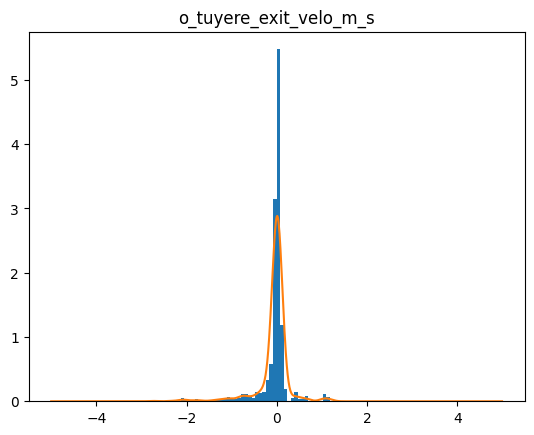

torch.Size([1000])
Epoch-8950 lr: 0.001
8951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8960  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8964  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
8965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8968  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
8969  

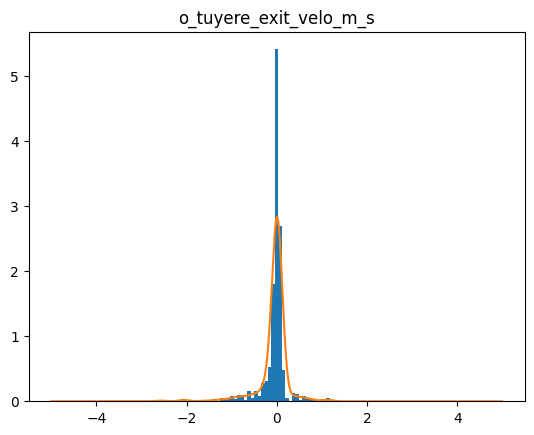

torch.Size([1000])
Epoch-9000 lr: 0.001
9001  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9002  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9004  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9005  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9007  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9010  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9017  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9018  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9019  

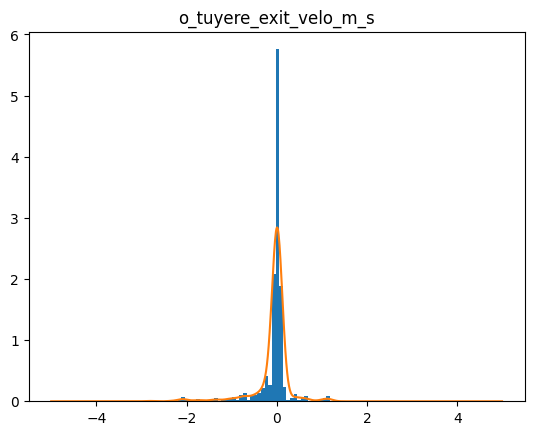

torch.Size([1000])
Epoch-9050 lr: 0.001
9051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9061  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9068  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9069  

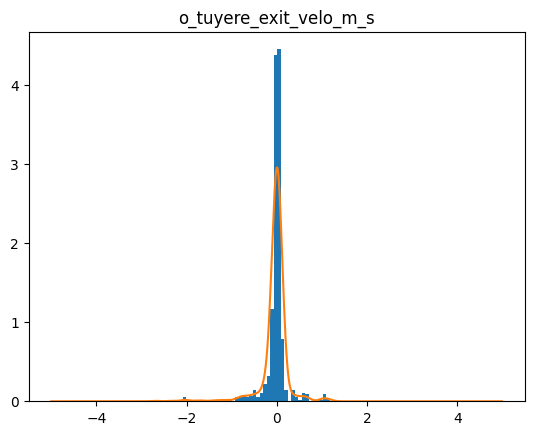

torch.Size([1000])
Epoch-9100 lr: 0.001
9101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9104  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9105  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9106  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9108  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
9109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9110  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9118  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9119  

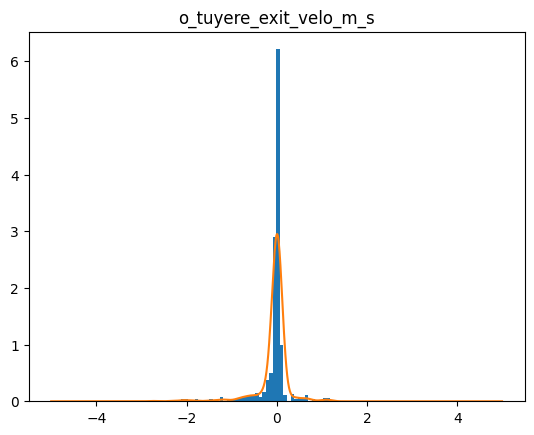

torch.Size([1000])
Epoch-9150 lr: 0.001
9151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9152  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9160  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9161  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9164  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9168  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9169  

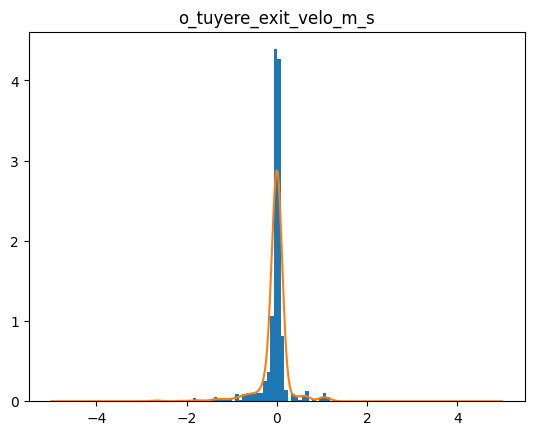

torch.Size([1000])
Epoch-9200 lr: 0.001
9201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9202  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9205  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9206  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9210  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9211  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9218  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9219  

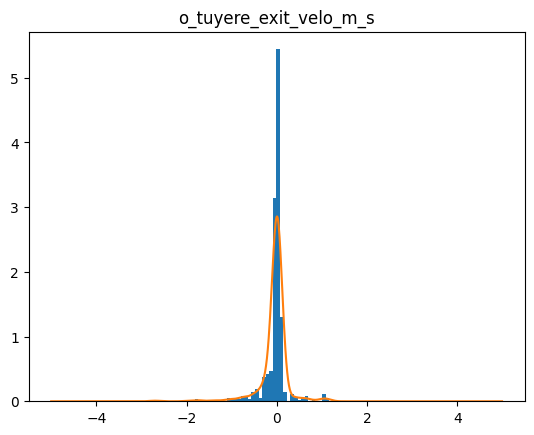

torch.Size([1000])
Epoch-9250 lr: 0.001
9251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9254  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9255  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9262  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9267  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9268  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9269  

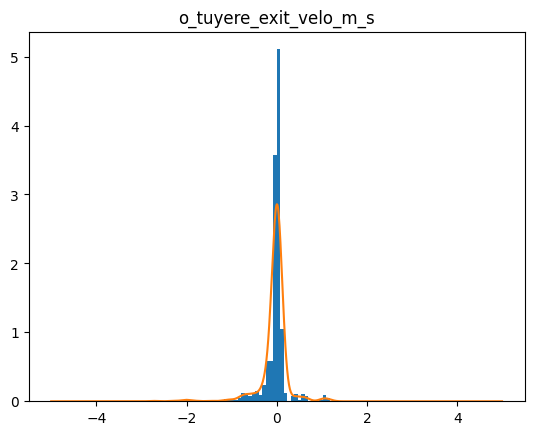

torch.Size([1000])
Epoch-9300 lr: 0.001
9301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9302  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9307  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9310  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9316  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9317  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9318  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9319  

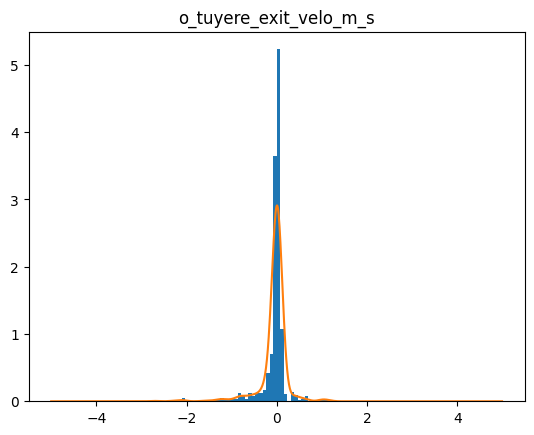

torch.Size([1000])
Epoch-9350 lr: 0.001
9351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9353  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9358  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9359  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9360  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9361  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9368  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9369  

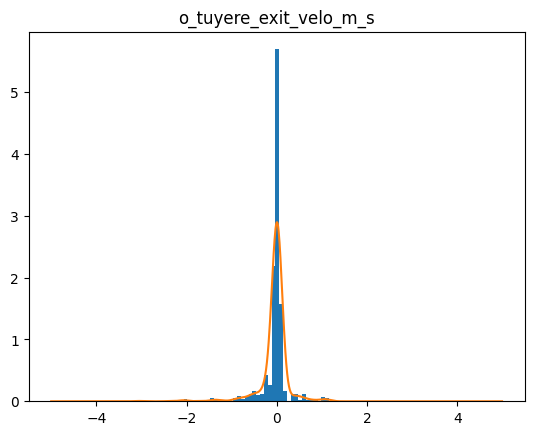

torch.Size([1000])
Epoch-9400 lr: 0.001
9401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9409  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9412  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9418  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9419  

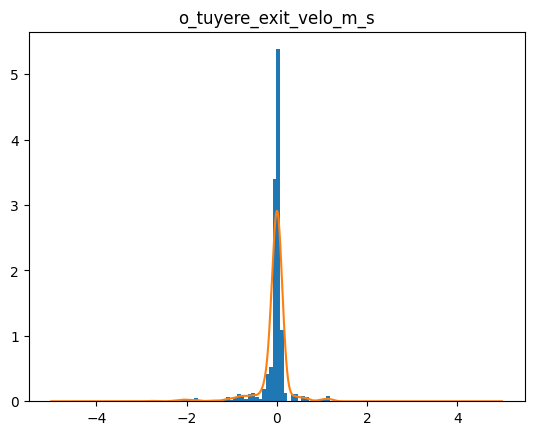

torch.Size([1000])
Epoch-9450 lr: 0.001
9451  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9453  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9465  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9468  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9469  

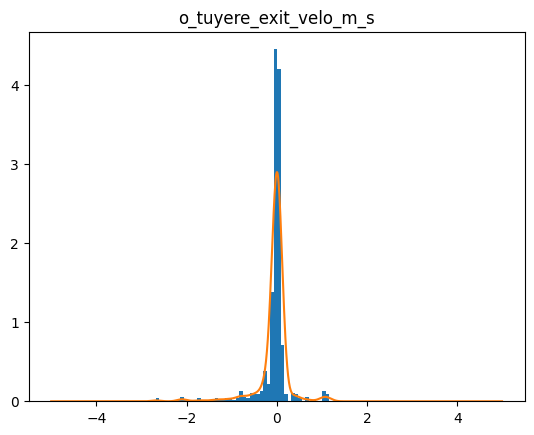

torch.Size([1000])
Epoch-9500 lr: 0.001
9501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9505  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9510  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9518  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9519  

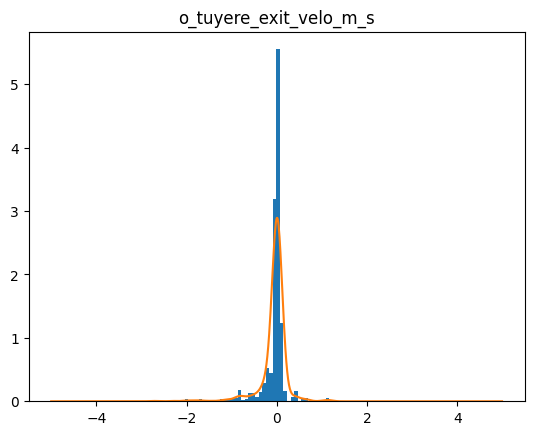

torch.Size([1000])
Epoch-9550 lr: 0.001
9551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9559  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9563  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9567  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9568  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9569  

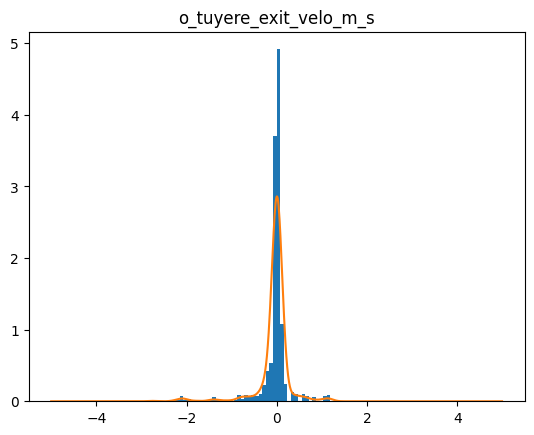

torch.Size([1000])
Epoch-9600 lr: 0.001
9601  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9605  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9606  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9609  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9610  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
9611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9618  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9619  

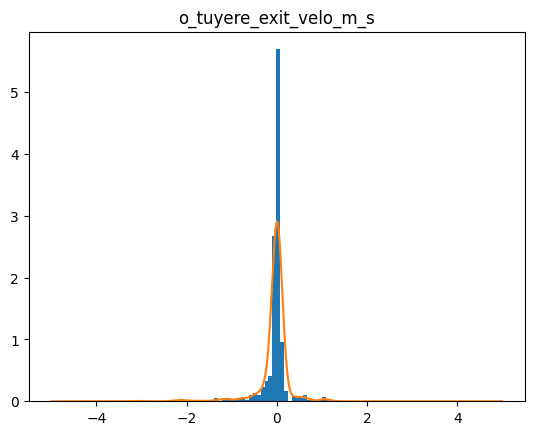

torch.Size([1000])
Epoch-9650 lr: 0.001
9651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9654  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9656  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9660  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9662  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9664  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9665  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9668  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9669  

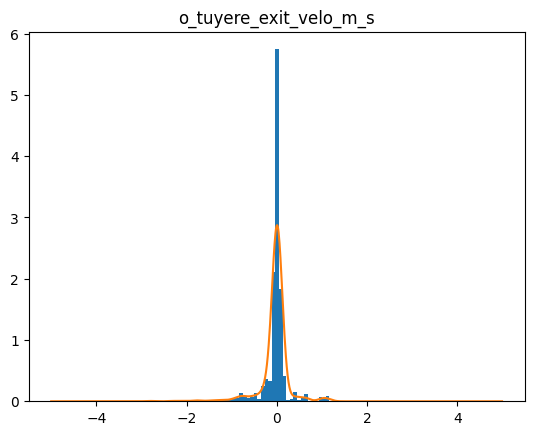

torch.Size([1000])
Epoch-9700 lr: 0.001
9701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9702  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9706  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9707  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9717  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9718  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9719  

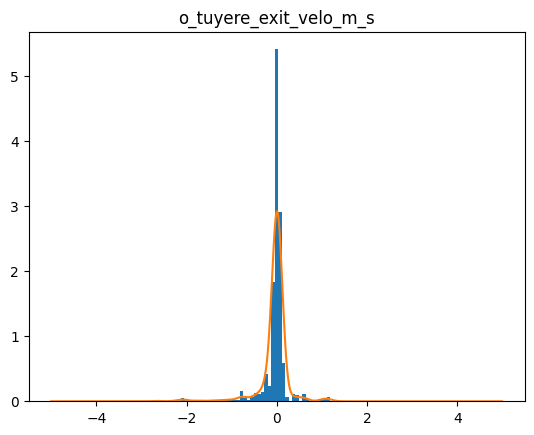

torch.Size([1000])
Epoch-9750 lr: 0.001
9751  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9752  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9755  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9768  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9769  

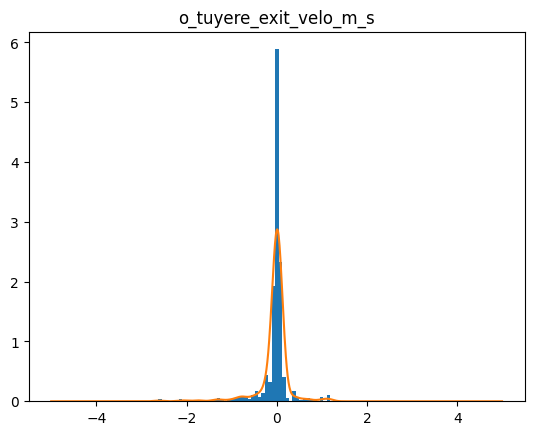

torch.Size([1000])
Epoch-9800 lr: 0.001
9801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9804  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9810  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9816  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9818  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9819  

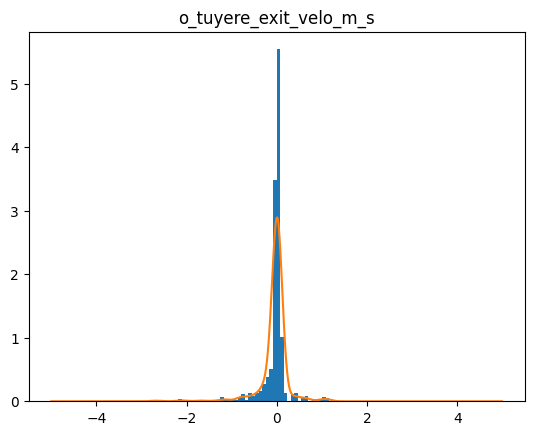

torch.Size([1000])
Epoch-9850 lr: 0.001
9851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9854  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9865  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9866  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9868  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
9869  

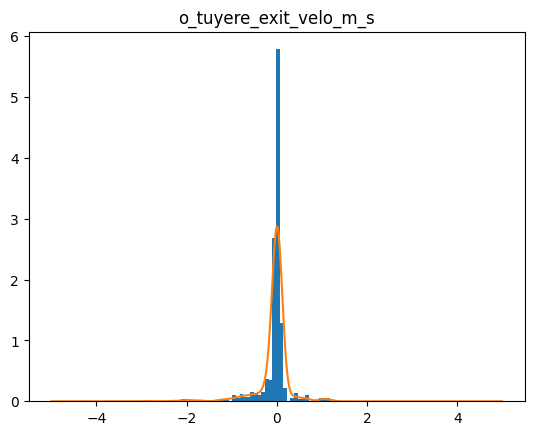

torch.Size([1000])
Epoch-9900 lr: 0.001
9901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9902  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9904  loss=  tensor(0.0019, grad_fn=<MeanBackward0>)
9905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9910  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9918  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9919  

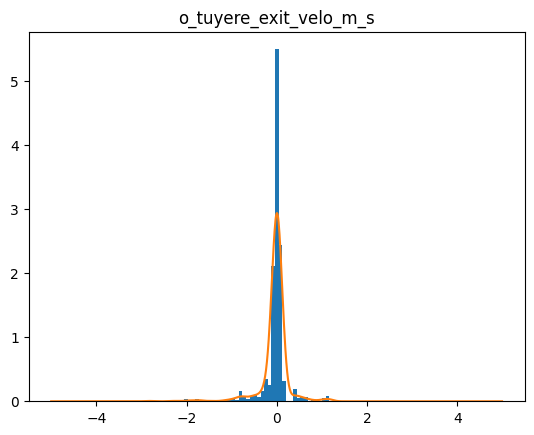

torch.Size([1000])
Epoch-9950 lr: 0.001
9951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9953  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9960  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9965  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
9968  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
9969  

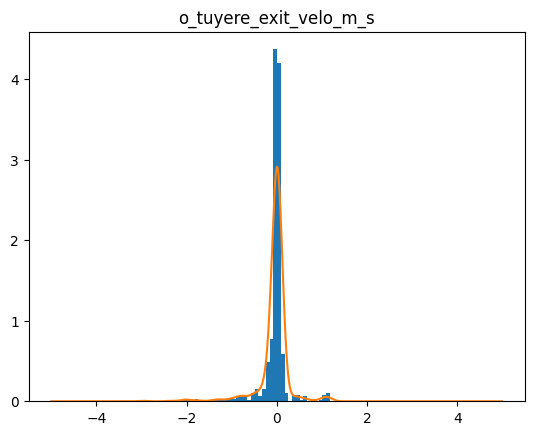

torch.Size([1000])
Epoch-10000 lr: 0.001
10001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10006  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10018  loss=  tensor(0.0016, grad_fn=<Mea

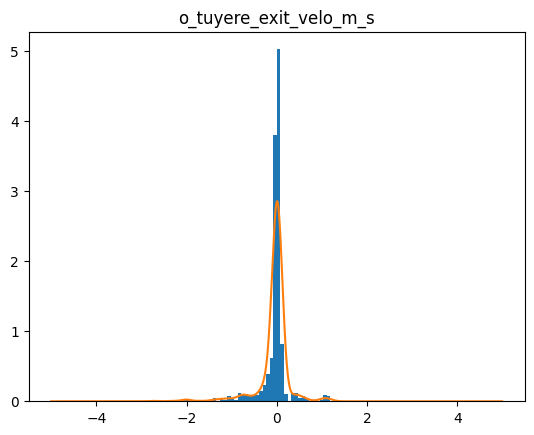

torch.Size([1000])
Epoch-10050 lr: 0.001
10051  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10054  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10055  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10064  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10068  loss=  tensor(0.0016, grad_fn=<Mea

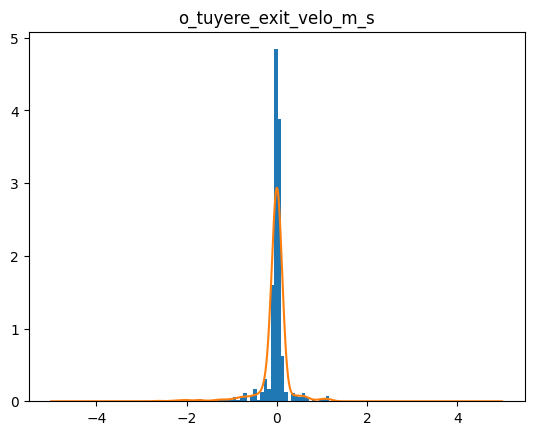

torch.Size([1000])
Epoch-10100 lr: 0.001
10101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10102  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
10103  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10107  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10109  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
10110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10112  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10114  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10118  loss=  tensor(0.0018, grad_fn=<Mea

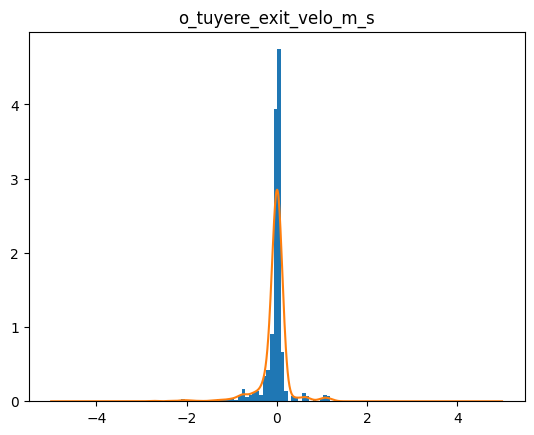

torch.Size([1000])
Epoch-10150 lr: 0.001
10151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10156  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10160  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10161  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10162  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10163  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10164  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10168  loss=  tensor(0.0017, grad_fn=<Mea

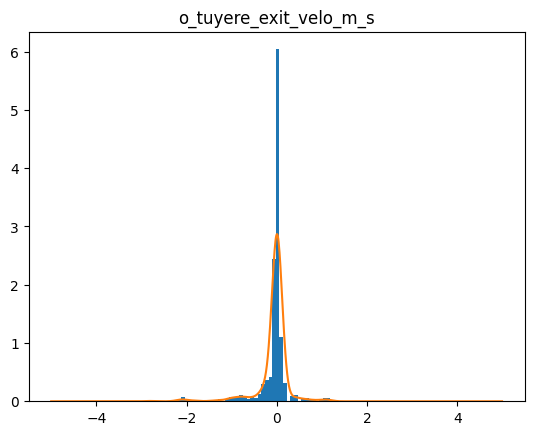

torch.Size([1000])
Epoch-10200 lr: 0.001
10201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10218  loss=  tensor(0.0016, grad_fn=<Mea

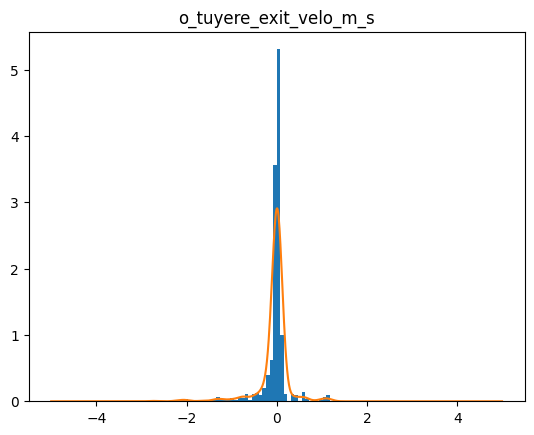

torch.Size([1000])
Epoch-10250 lr: 0.001
10251  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10263  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10267  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10268  loss=  tensor(0.0016, grad_fn=<Mea

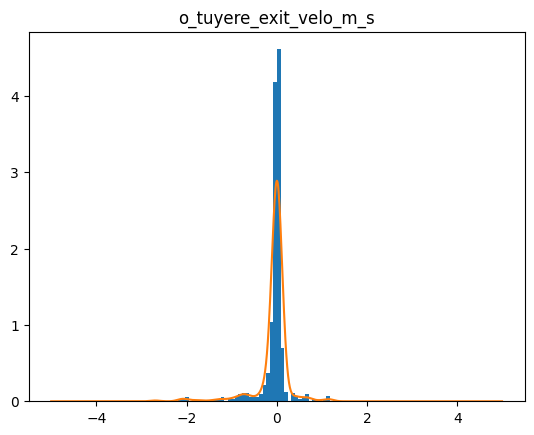

torch.Size([1000])
Epoch-10300 lr: 0.001
10301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10302  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10303  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10306  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10308  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10310  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10313  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10318  loss=  tensor(0.0016, grad_fn=<Mea

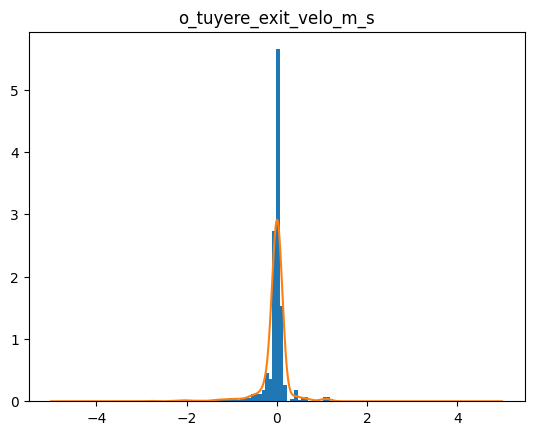

torch.Size([1000])
Epoch-10350 lr: 0.001
10351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10368  loss=  tensor(0.0016, grad_fn=<Mea

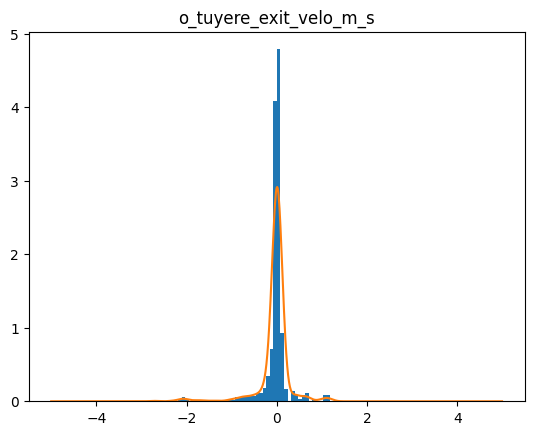

torch.Size([1000])
Epoch-10400 lr: 0.001
10401  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10404  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10405  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10406  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
10407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10417  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10418  loss=  tensor(0.0016, grad_fn=<Mea

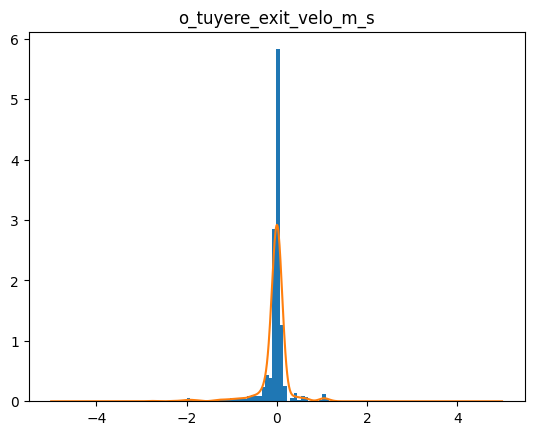

torch.Size([1000])
Epoch-10450 lr: 0.001
10451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10453  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10457  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10461  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10464  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10468  loss=  tensor(0.0016, grad_fn=<Mea

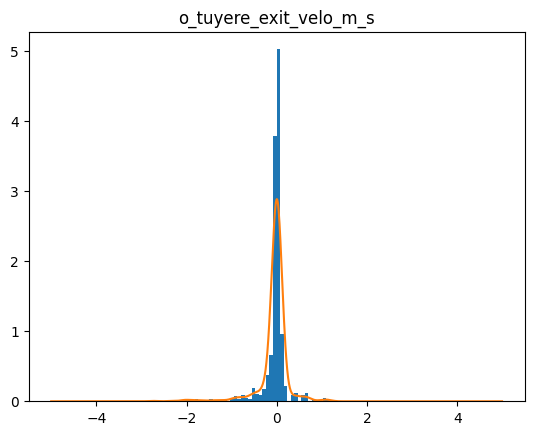

torch.Size([1000])
Epoch-10500 lr: 0.001
10501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10504  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
10505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10507  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10508  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10509  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10513  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10517  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10518  loss=  tensor(0.0016, grad_fn=<Mea

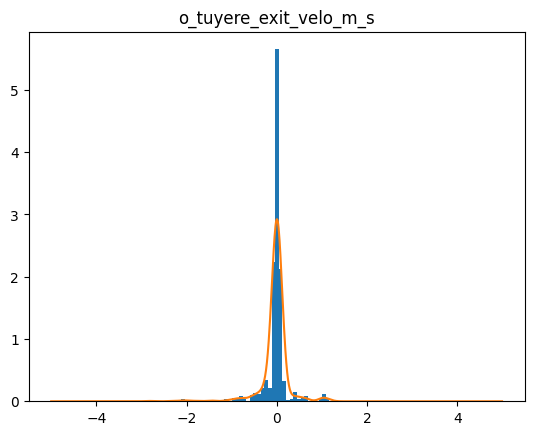

torch.Size([1000])
Epoch-10550 lr: 0.001
10551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10553  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10561  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10562  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10568  loss=  tensor(0.0016, grad_fn=<Mea

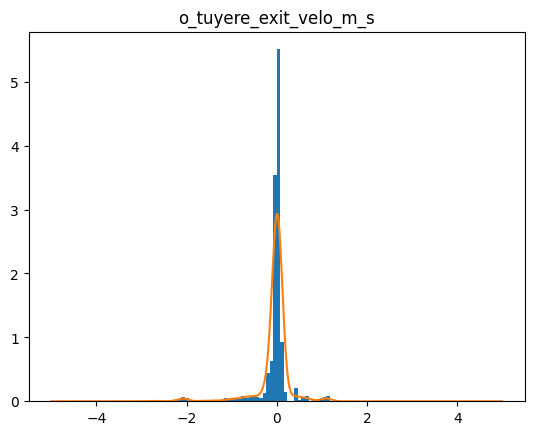

torch.Size([1000])
Epoch-10600 lr: 0.001
10601  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10604  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10608  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10613  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10618  loss=  tensor(0.0016, grad_fn=<Mea

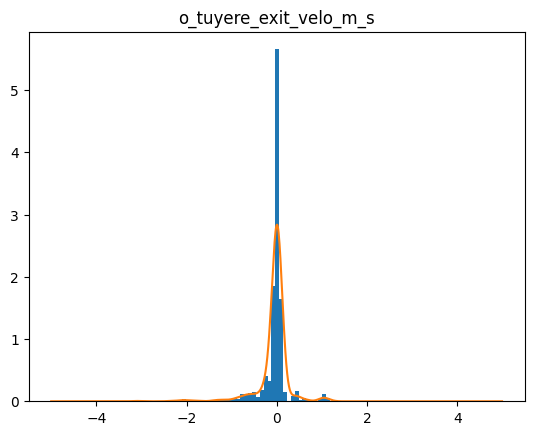

torch.Size([1000])
Epoch-10650 lr: 0.001
10651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10663  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10665  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10668  loss=  tensor(0.0016, grad_fn=<Mea

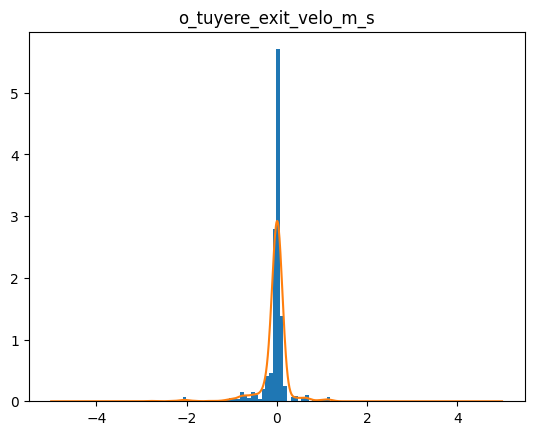

torch.Size([1000])
Epoch-10700 lr: 0.001
10701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10706  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10714  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10718  loss=  tensor(0.0017, grad_fn=<Mea

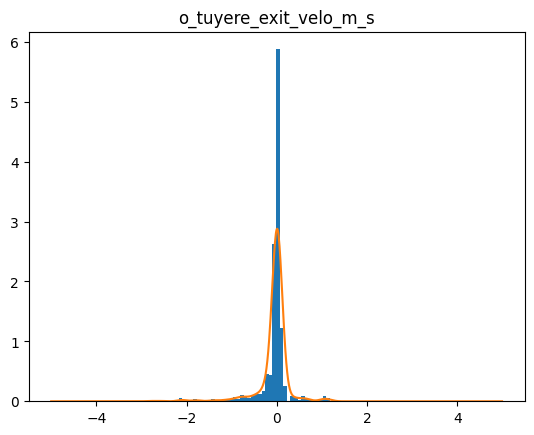

torch.Size([1000])
Epoch-10750 lr: 0.001
10751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10762  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10765  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10768  loss=  tensor(0.0016, grad_fn=<Mea

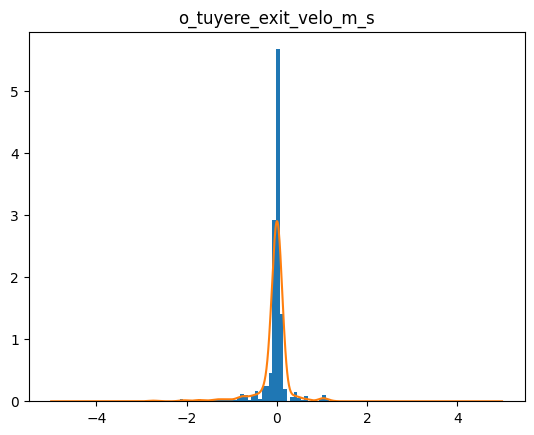

torch.Size([1000])
Epoch-10800 lr: 0.001
10801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10804  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10807  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10809  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10813  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10818  loss=  tensor(0.0017, grad_fn=<Mea

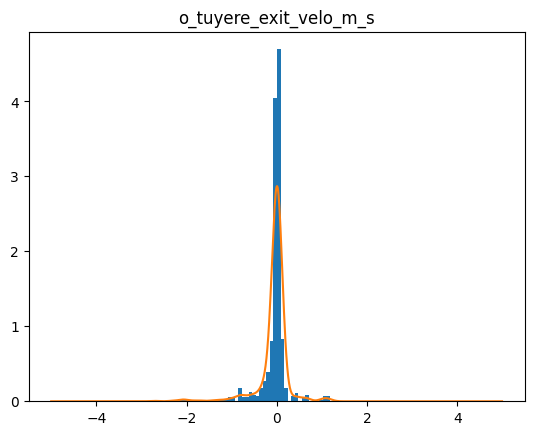

torch.Size([1000])
Epoch-10850 lr: 0.001
10851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10857  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10859  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10863  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10868  loss=  tensor(0.0016, grad_fn=<Mea

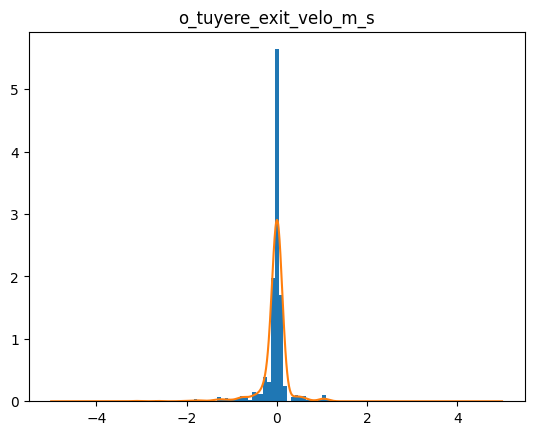

torch.Size([1000])
Epoch-10900 lr: 0.001
10901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10906  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10909  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10911  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
10912  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10918  loss=  tensor(0.0016, grad_fn=<Mea

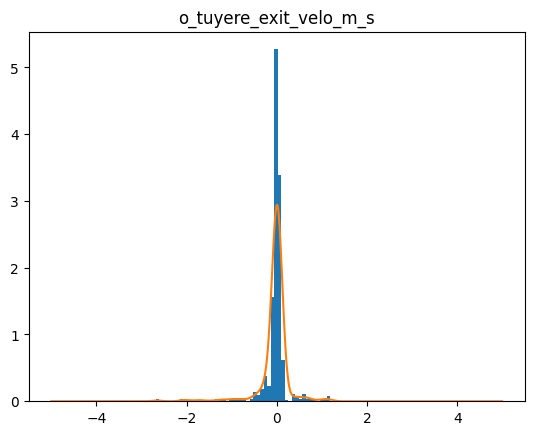

torch.Size([1000])
Epoch-10950 lr: 0.001
10951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10954  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10957  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10961  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
10963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
10968  loss=  tensor(0.0016, grad_fn=<Mea

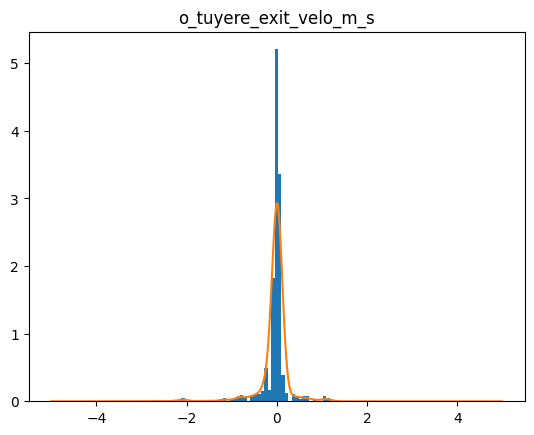

torch.Size([1000])
Epoch-11000 lr: 0.001
11001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11005  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
11006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11018  loss=  tensor(0.0017, grad_fn=<Mea

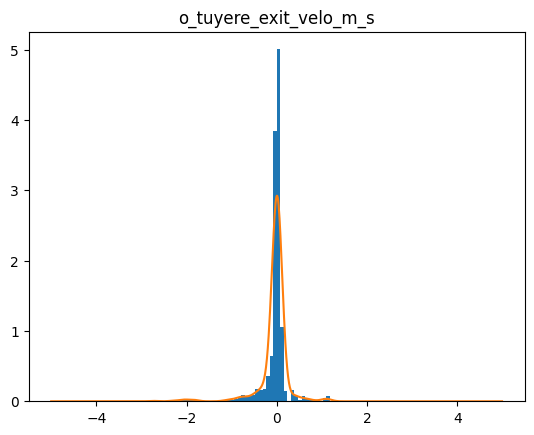

torch.Size([1000])
Epoch-11050 lr: 0.001
11051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11052  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11053  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11062  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11063  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11068  loss=  tensor(0.0016, grad_fn=<Mea

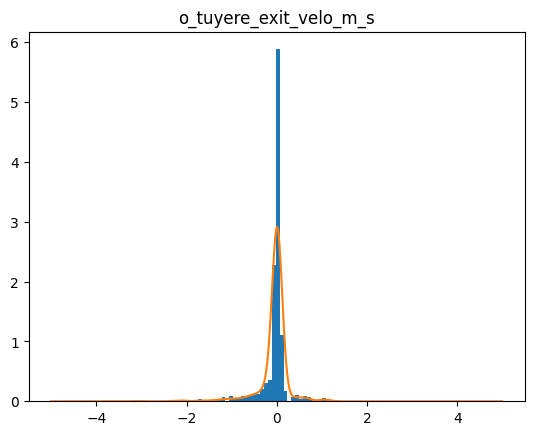

torch.Size([1000])
Epoch-11100 lr: 0.001
11101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11106  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11108  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11118  loss=  tensor(0.0016, grad_fn=<Mea

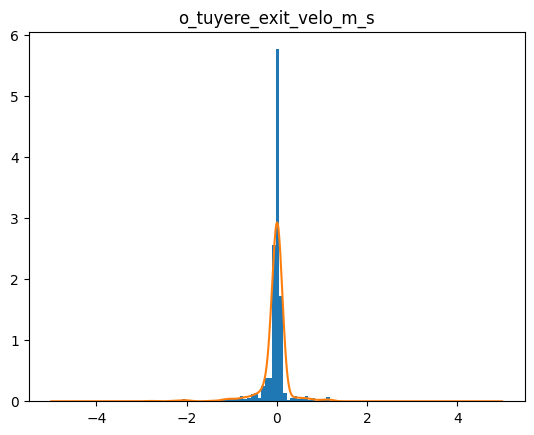

torch.Size([1000])
Epoch-11150 lr: 0.001
11151  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11155  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11156  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11166  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11168  loss=  tensor(0.0016, grad_fn=<Mea

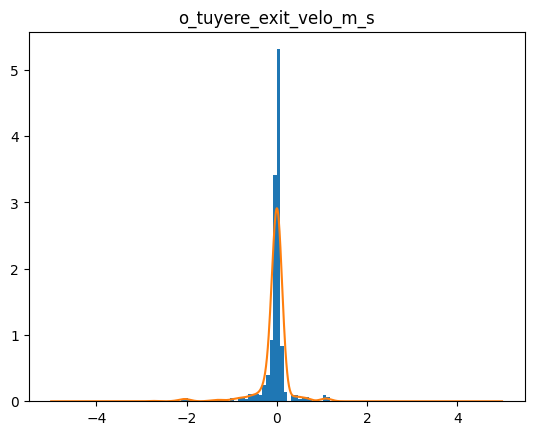

torch.Size([1000])
Epoch-11200 lr: 0.001
11201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11208  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11210  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
11211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11213  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11218  loss=  tensor(0.0017, grad_fn=<Mea

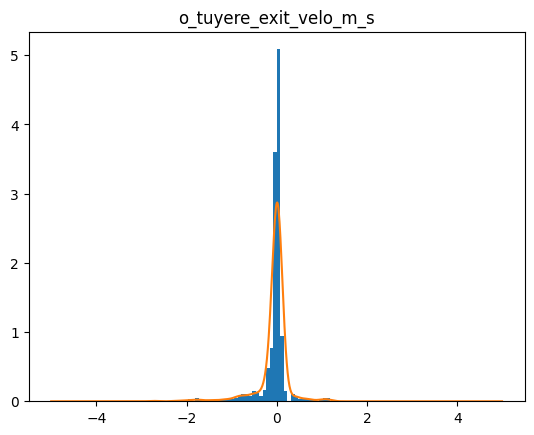

torch.Size([1000])
Epoch-11250 lr: 0.001
11251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11258  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11261  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11268  loss=  tensor(0.0016, grad_fn=<Mea

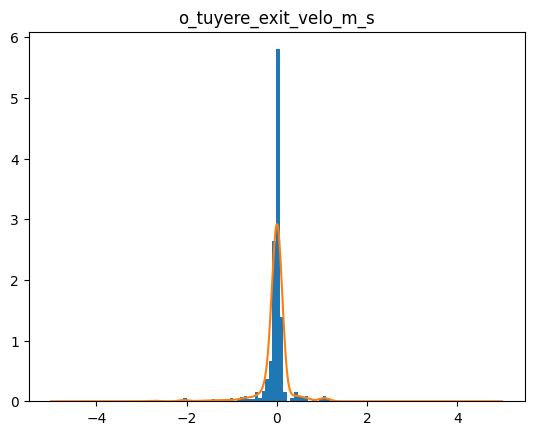

torch.Size([1000])
Epoch-11300 lr: 0.001
11301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11302  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11317  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11318  loss=  tensor(0.0016, grad_fn=<Mea

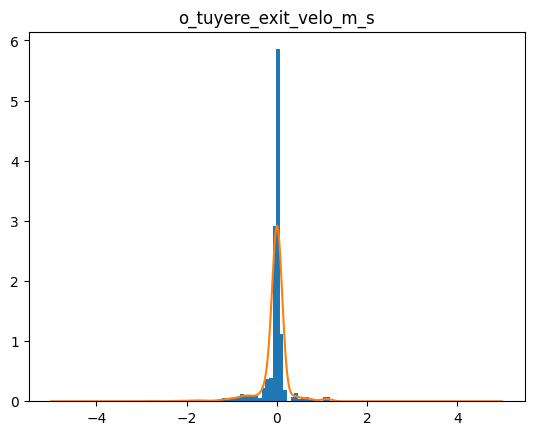

torch.Size([1000])
Epoch-11350 lr: 0.001
11351  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11355  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11360  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11363  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11367  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11368  loss=  tensor(0.0017, grad_fn=<Mea

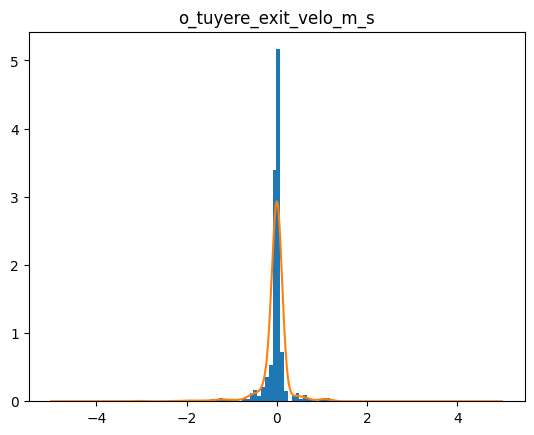

torch.Size([1000])
Epoch-11400 lr: 0.001
11401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11402  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11406  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
11407  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11414  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11418  loss=  tensor(0.0016, grad_fn=<Mea

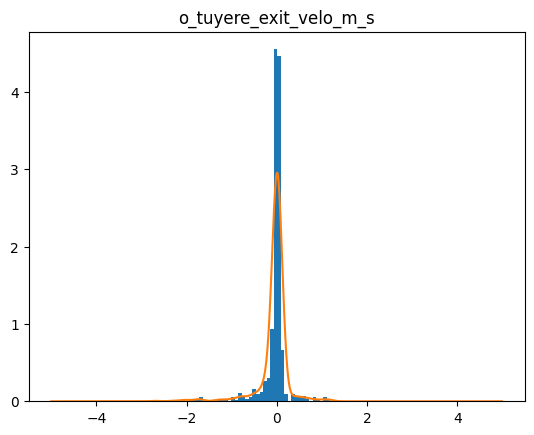

torch.Size([1000])
Epoch-11450 lr: 0.001
11451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11453  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11456  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11468  loss=  tensor(0.0017, grad_fn=<Mea

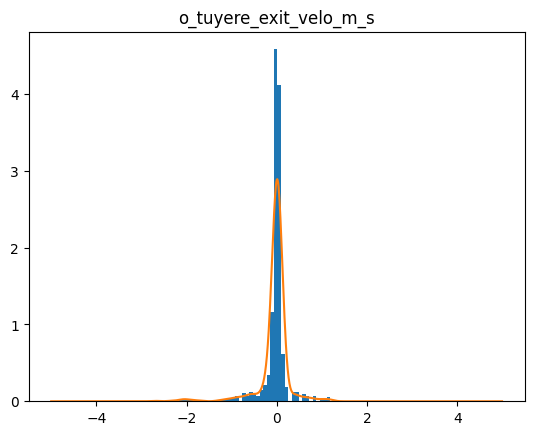

torch.Size([1000])
Epoch-11500 lr: 0.001
11501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11503  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11506  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11509  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11514  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11518  loss=  tensor(0.0016, grad_fn=<Mea

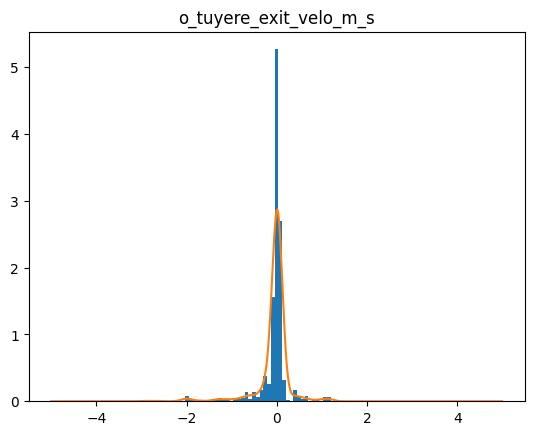

torch.Size([1000])
Epoch-11550 lr: 0.001
11551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11552  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11556  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11560  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11561  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11564  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11568  loss=  tensor(0.0017, grad_fn=<Mea

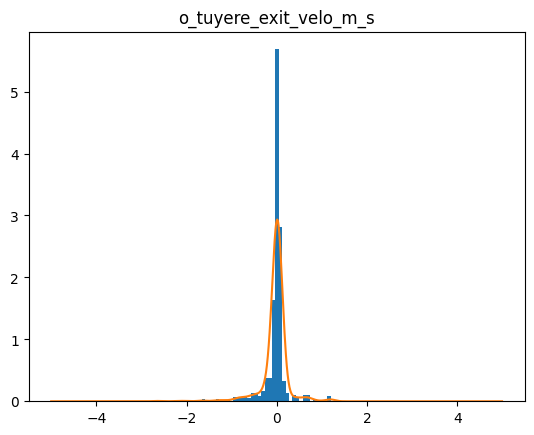

torch.Size([1000])
Epoch-11600 lr: 0.001
11601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11603  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11606  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11613  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11618  loss=  tensor(0.0015, grad_fn=<Mea

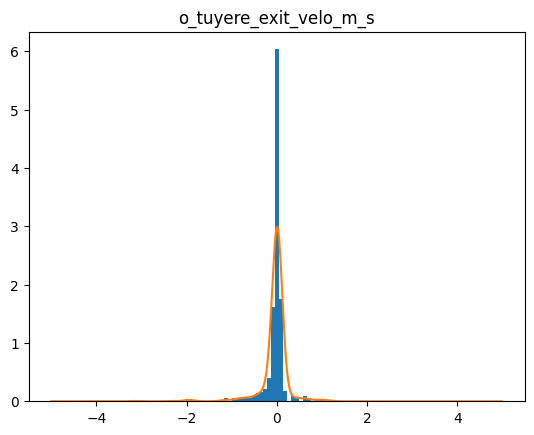

torch.Size([1000])
Epoch-11650 lr: 0.001
11651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11653  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11668  loss=  tensor(0.0016, grad_fn=<Mea

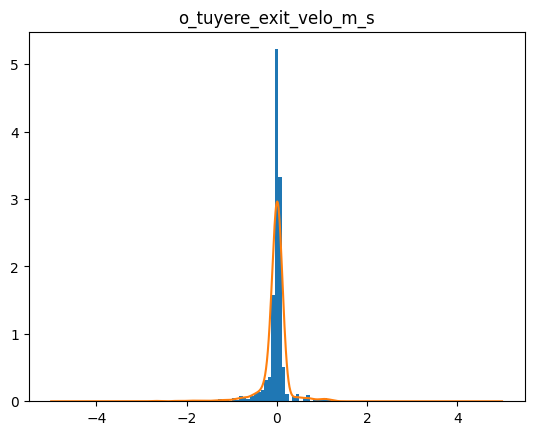

torch.Size([1000])
Epoch-11700 lr: 0.001
11701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11708  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11718  loss=  tensor(0.0016, grad_fn=<Mea

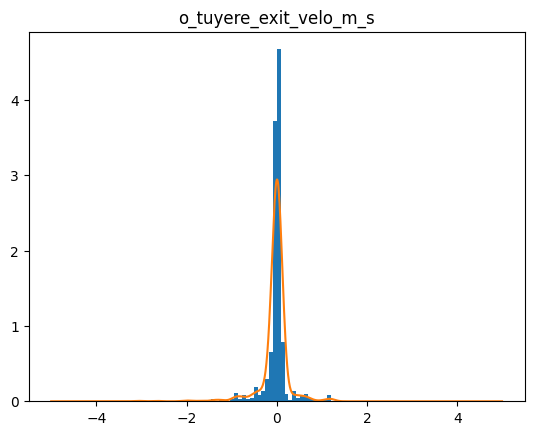

torch.Size([1000])
Epoch-11750 lr: 0.001
11751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11754  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11768  loss=  tensor(0.0017, grad_fn=<Mea

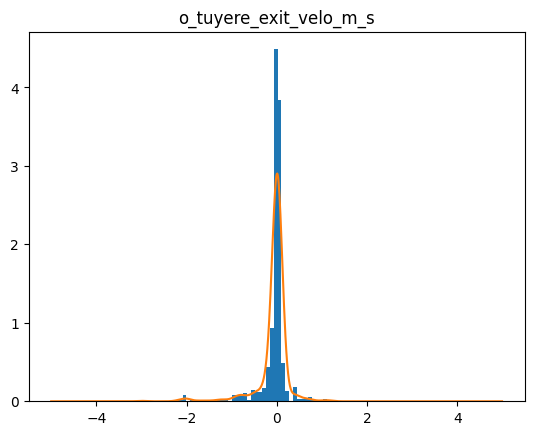

torch.Size([1000])
Epoch-11800 lr: 0.001
11801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11803  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11810  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11817  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11818  loss=  tensor(0.0016, grad_fn=<Mea

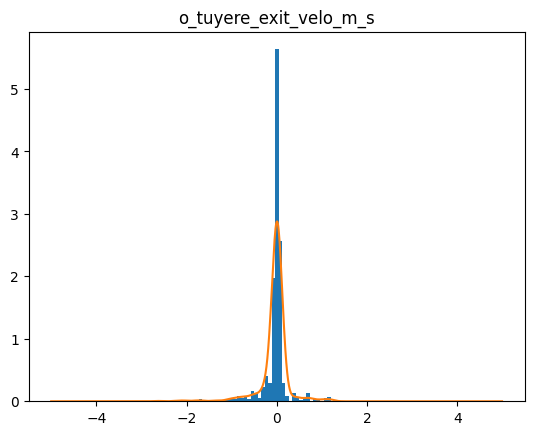

torch.Size([1000])
Epoch-11850 lr: 0.001
11851  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11855  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11867  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11868  loss=  tensor(0.0016, grad_fn=<Mea

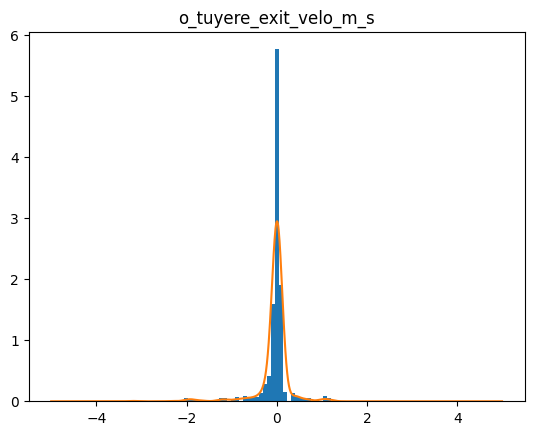

torch.Size([1000])
Epoch-11900 lr: 0.001
11901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11904  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11905  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11918  loss=  tensor(0.0017, grad_fn=<Mea

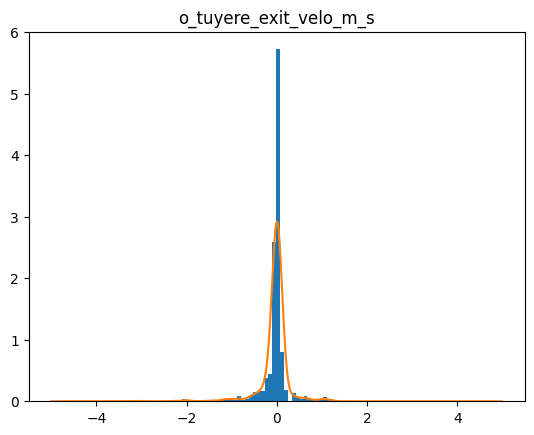

torch.Size([1000])
Epoch-11950 lr: 0.001
11951  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
11958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11962  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11965  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
11966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
11968  loss=  tensor(0.0016, grad_fn=<Mea

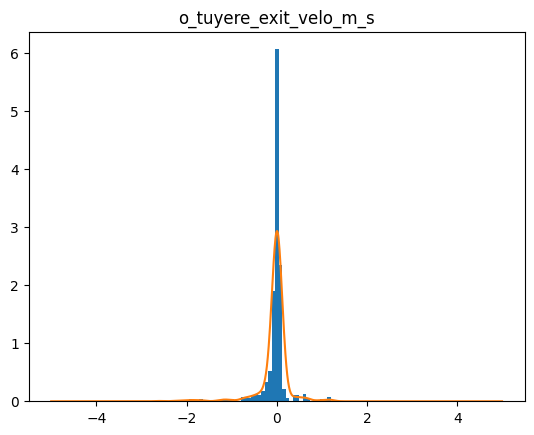

torch.Size([1000])
Epoch-12000 lr: 0.001
12001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12002  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12003  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12010  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12011  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12018  loss=  tensor(0.0017, grad_fn=<Mea

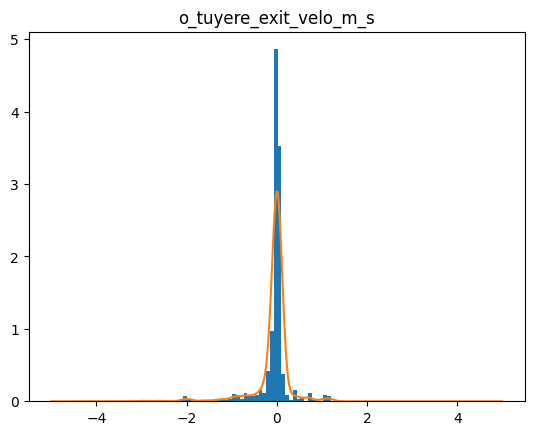

torch.Size([1000])
Epoch-12050 lr: 0.001
12051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12056  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12065  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12068  loss=  tensor(0.0016, grad_fn=<Mea

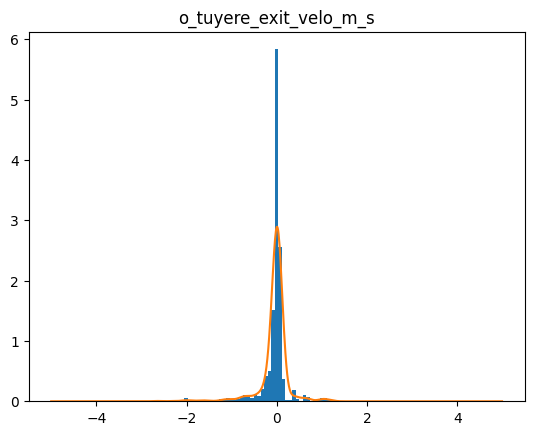

torch.Size([1000])
Epoch-12100 lr: 0.001
12101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12109  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12118  loss=  tensor(0.0016, grad_fn=<Mea

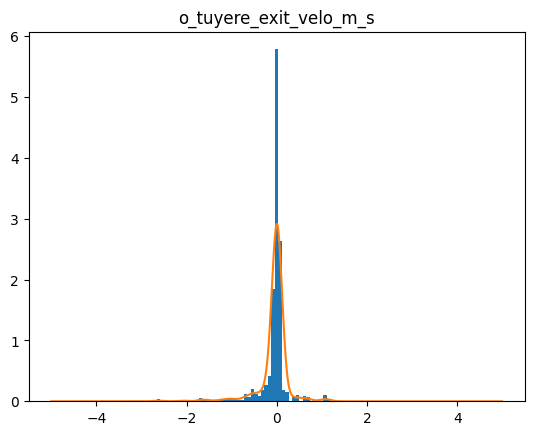

torch.Size([1000])
Epoch-12150 lr: 0.001
12151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12154  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12168  loss=  tensor(0.0017, grad_fn=<Mea

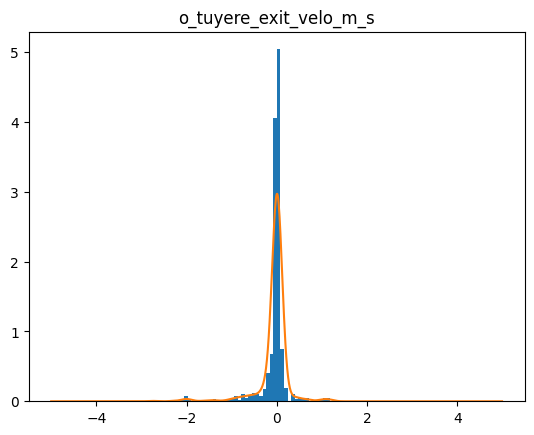

torch.Size([1000])
Epoch-12200 lr: 0.001
12201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12207  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12212  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12218  loss=  tensor(0.0016, grad_fn=<Mea

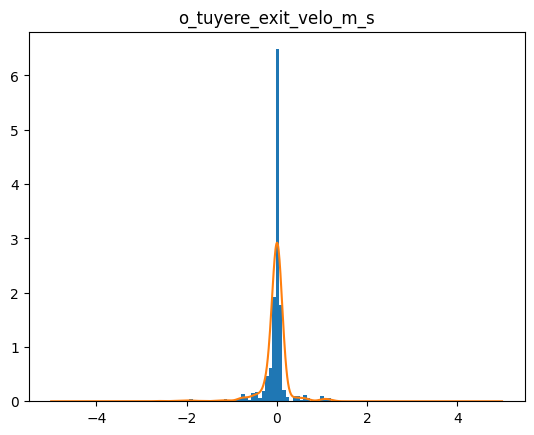

torch.Size([1000])
Epoch-12250 lr: 0.001
12251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12261  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12262  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12264  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12265  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12267  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12268  loss=  tensor(0.0016, grad_fn=<Mea

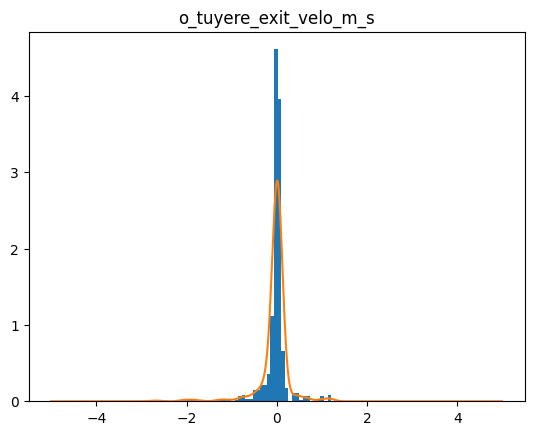

torch.Size([1000])
Epoch-12300 lr: 0.001
12301  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12311  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12318  loss=  tensor(0.0016, grad_fn=<Mea

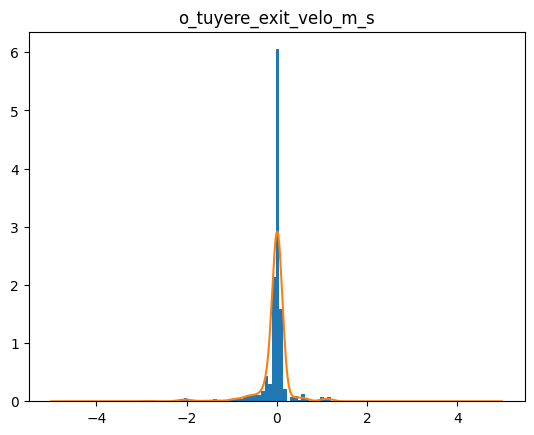

torch.Size([1000])
Epoch-12350 lr: 0.001
12351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12356  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12357  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12359  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12364  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12366  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12368  loss=  tensor(0.0016, grad_fn=<Mea

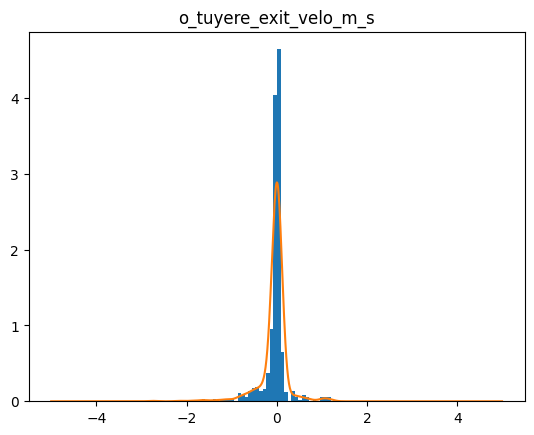

torch.Size([1000])
Epoch-12400 lr: 0.001
12401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12411  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12412  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12414  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12415  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12418  loss=  tensor(0.0016, grad_fn=<Mea

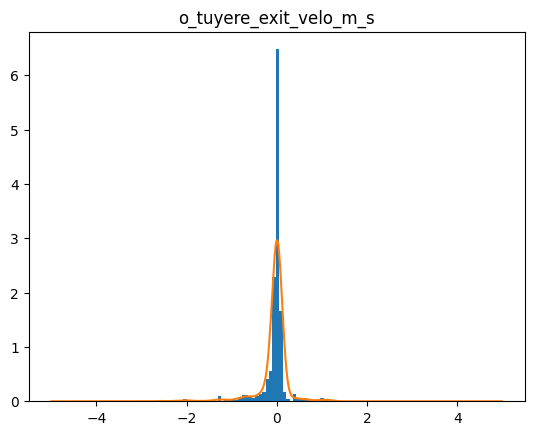

torch.Size([1000])
Epoch-12450 lr: 0.001
12451  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12453  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12456  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12462  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12468  loss=  tensor(0.0016, grad_fn=<Mea

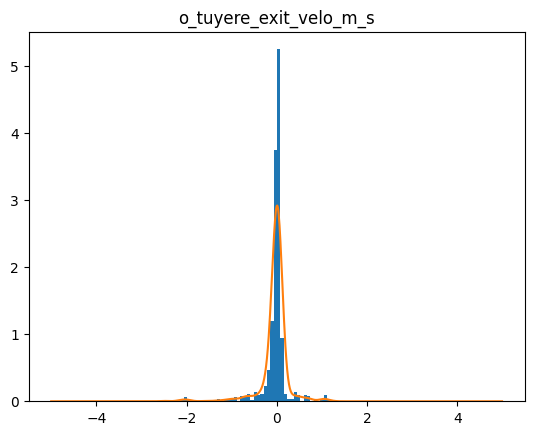

torch.Size([1000])
Epoch-12500 lr: 0.001
12501  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12506  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12511  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12516  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12518  loss=  tensor(0.0016, grad_fn=<Mea

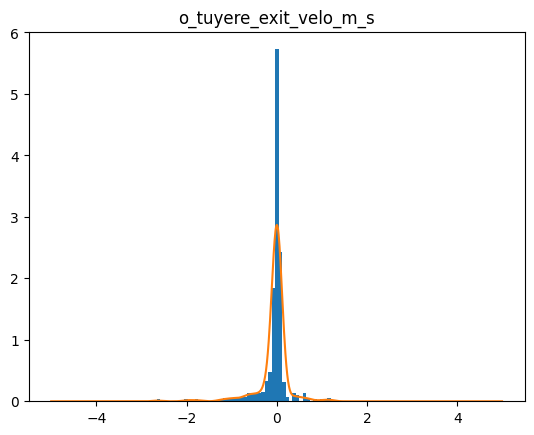

torch.Size([1000])
Epoch-12550 lr: 0.001
12551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12552  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12554  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12568  loss=  tensor(0.0016, grad_fn=<Mea

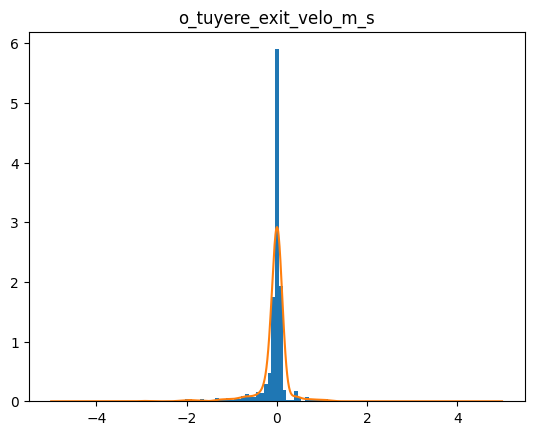

torch.Size([1000])
Epoch-12600 lr: 0.001
12601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12611  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12613  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12616  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12617  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12618  loss=  tensor(0.0016, grad_fn=<Mea

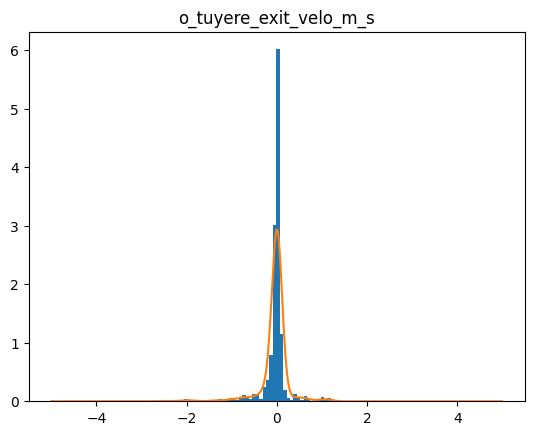

torch.Size([1000])
Epoch-12650 lr: 0.001
12651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12660  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12667  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12668  loss=  tensor(0.0016, grad_fn=<Mea

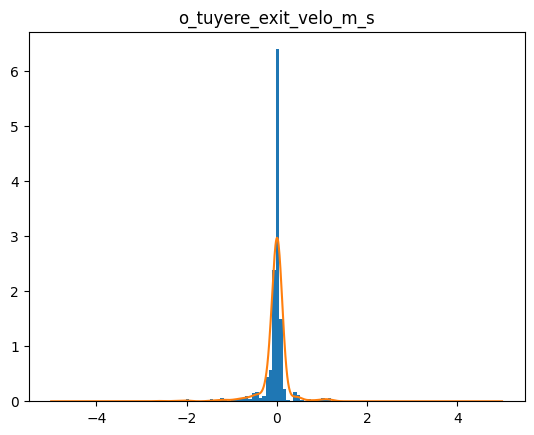

torch.Size([1000])
Epoch-12700 lr: 0.001
12701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12710  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12713  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12715  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12718  loss=  tensor(0.0016, grad_fn=<Mea

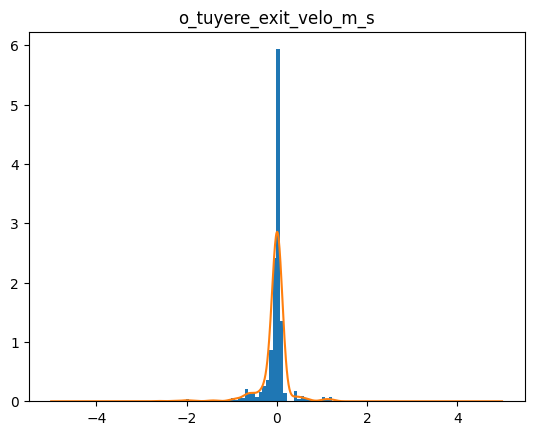

torch.Size([1000])
Epoch-12750 lr: 0.001
12751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12755  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12756  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12758  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12768  loss=  tensor(0.0016, grad_fn=<Mea

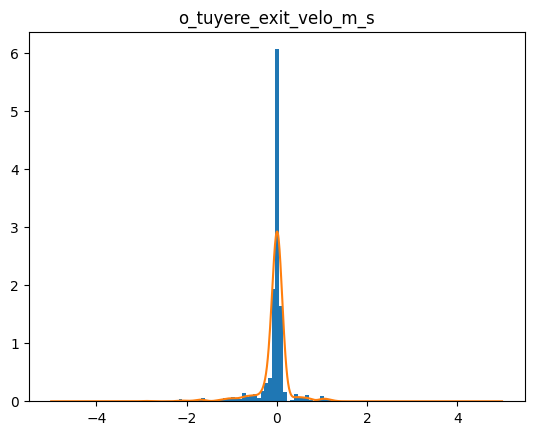

torch.Size([1000])
Epoch-12800 lr: 0.001
12801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12812  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12815  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12818  loss=  tensor(0.0016, grad_fn=<Mea

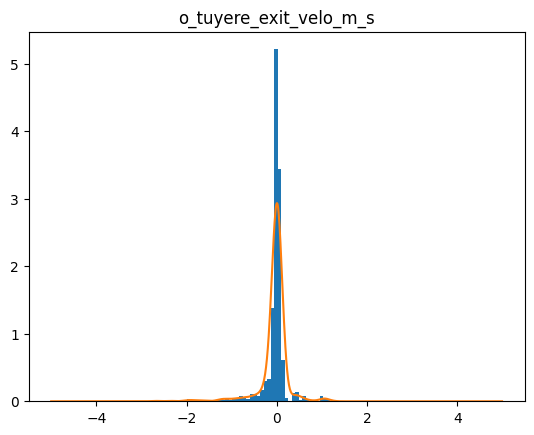

torch.Size([1000])
Epoch-12850 lr: 0.001
12851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12858  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12868  loss=  tensor(0.0017, grad_fn=<Mea

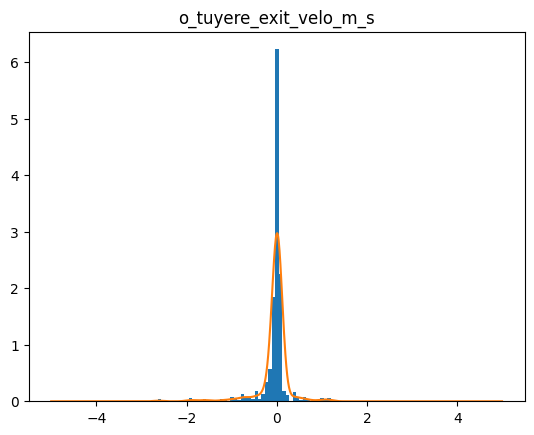

torch.Size([1000])
Epoch-12900 lr: 0.001
12901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12902  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12904  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12905  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12911  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12916  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12917  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12918  loss=  tensor(0.0016, grad_fn=<Mea

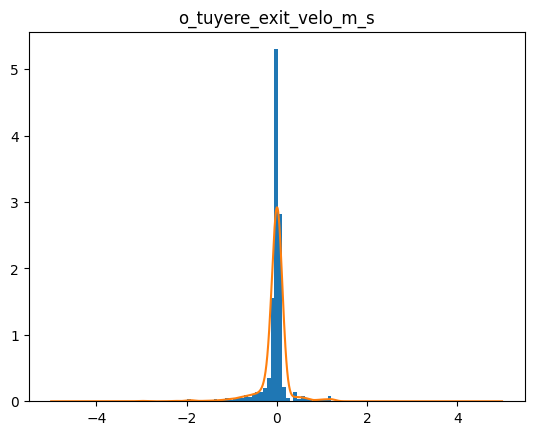

torch.Size([1000])
Epoch-12950 lr: 0.001
12951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12955  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12957  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12962  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
12963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
12967  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
12968  loss=  tensor(0.0016, grad_fn=<Mea

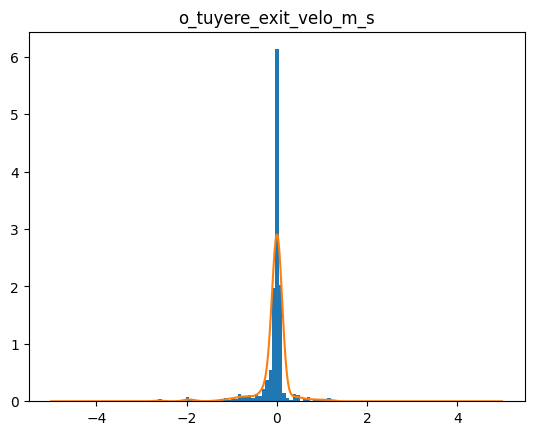

torch.Size([1000])
Epoch-13000 lr: 0.001
13001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13003  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13005  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13010  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13013  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13015  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13018  loss=  tensor(0.0016, grad_fn=<Mea

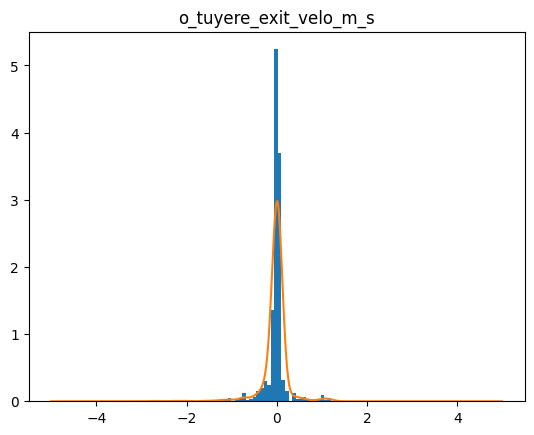

torch.Size([1000])
Epoch-13050 lr: 0.001
13051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13061  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13068  loss=  tensor(0.0016, grad_fn=<Mea

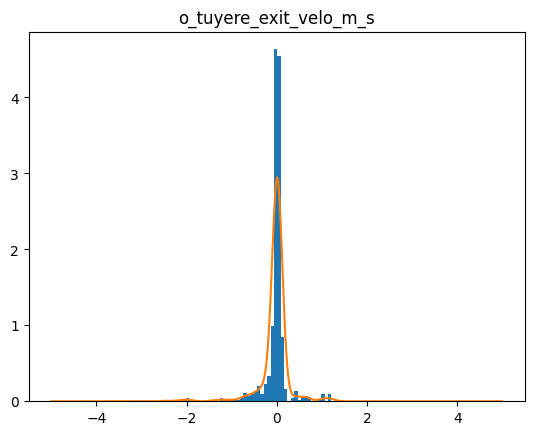

torch.Size([1000])
Epoch-13100 lr: 0.001
13101  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13102  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13109  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13112  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13117  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13118  loss=  tensor(0.0016, grad_fn=<Mea

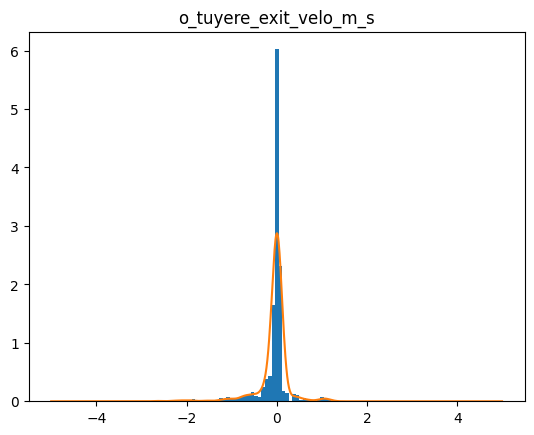

torch.Size([1000])
Epoch-13150 lr: 0.001
13151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13157  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13158  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13163  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13165  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13168  loss=  tensor(0.0016, grad_fn=<Mea

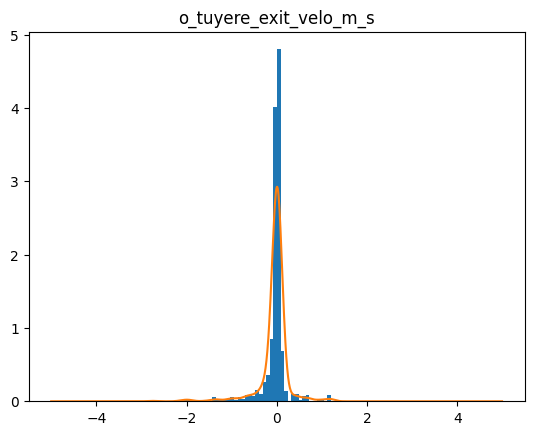

torch.Size([1000])
Epoch-13200 lr: 0.001
13201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13209  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13218  loss=  tensor(0.0016, grad_fn=<Mea

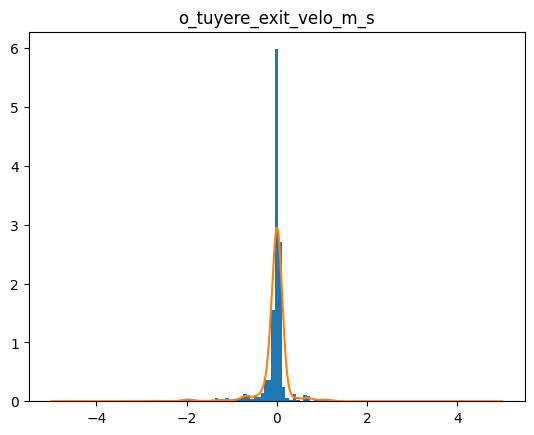

torch.Size([1000])
Epoch-13250 lr: 0.001
13251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13252  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13267  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13268  loss=  tensor(0.0016, grad_fn=<Mea

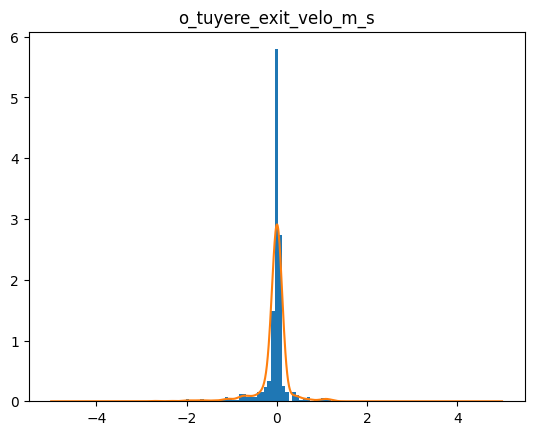

torch.Size([1000])
Epoch-13300 lr: 0.001
13301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13305  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13306  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13311  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13318  loss=  tensor(0.0016, grad_fn=<Mea

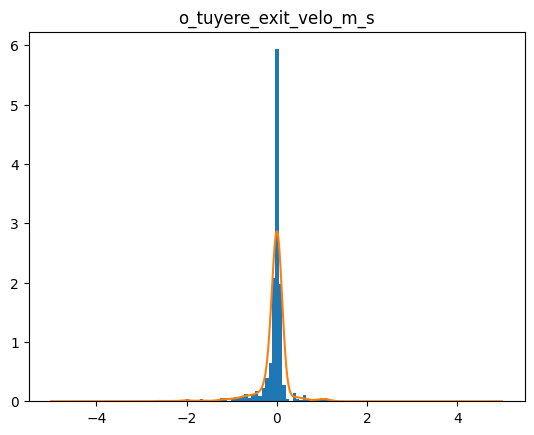

torch.Size([1000])
Epoch-13350 lr: 0.001
13351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13352  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13360  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13361  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13363  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13365  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13368  loss=  tensor(0.0016, grad_fn=<Mea

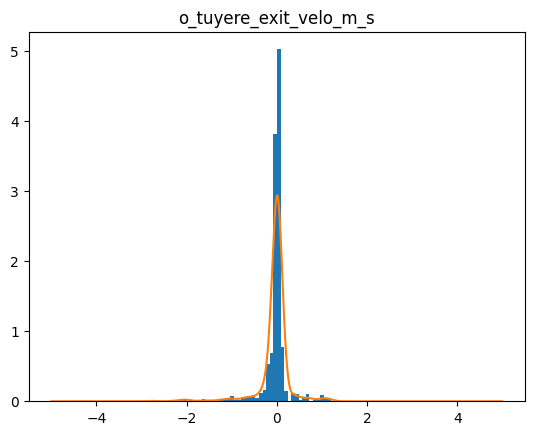

torch.Size([1000])
Epoch-13400 lr: 0.001
13401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13403  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13418  loss=  tensor(0.0017, grad_fn=<Mea

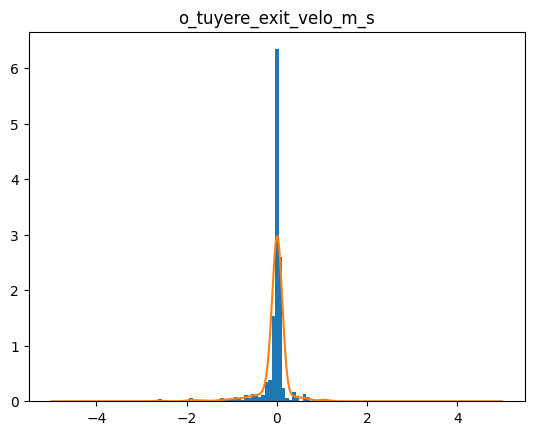

torch.Size([1000])
Epoch-13450 lr: 0.001
13451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13453  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13460  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13464  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13468  loss=  tensor(0.0016, grad_fn=<Mea

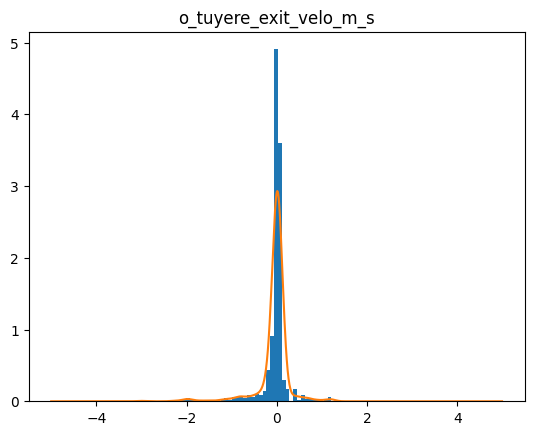

torch.Size([1000])
Epoch-13500 lr: 0.001
13501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13510  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13516  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13518  loss=  tensor(0.0016, grad_fn=<Mea

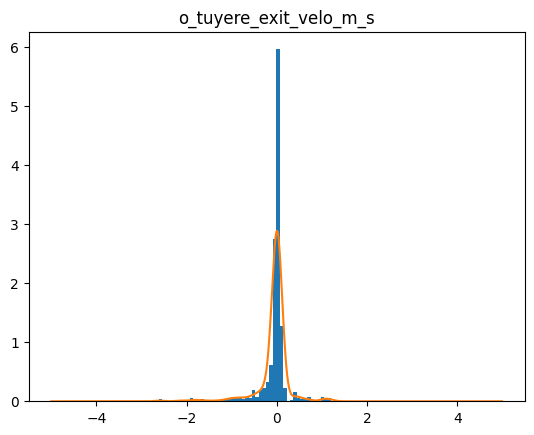

torch.Size([1000])
Epoch-13550 lr: 0.001
13551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13553  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13557  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13558  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13563  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13566  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13567  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13568  loss=  tensor(0.0016, grad_fn=<Mea

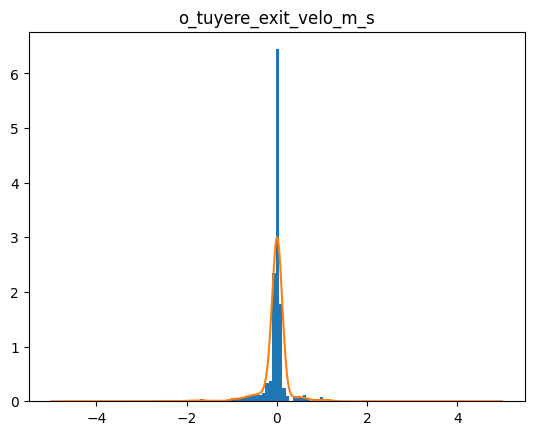

torch.Size([1000])
Epoch-13600 lr: 0.001
13601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13603  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13606  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13613  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13616  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13618  loss=  tensor(0.0016, grad_fn=<Mea

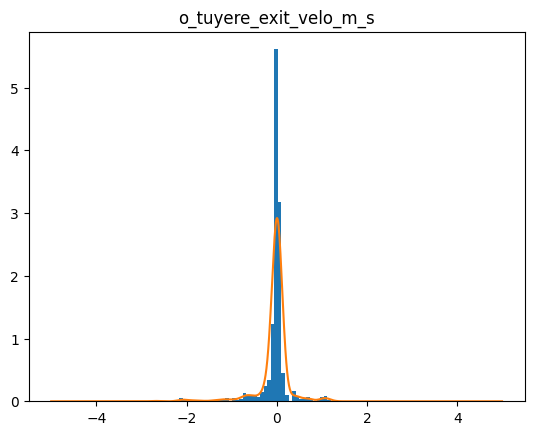

torch.Size([1000])
Epoch-13650 lr: 0.001
13651  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13655  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13668  loss=  tensor(0.0016, grad_fn=<Mea

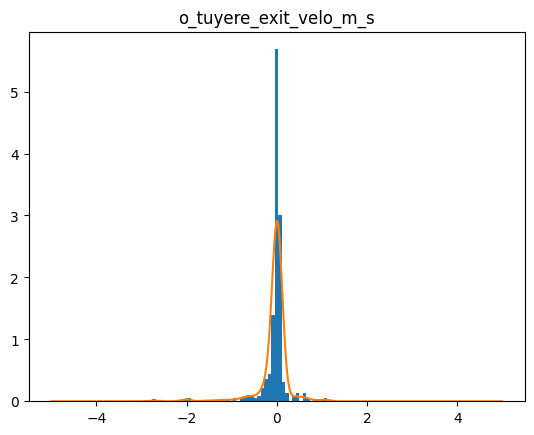

torch.Size([1000])
Epoch-13700 lr: 0.001
13701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13704  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13706  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13708  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13711  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13718  loss=  tensor(0.0016, grad_fn=<Mea

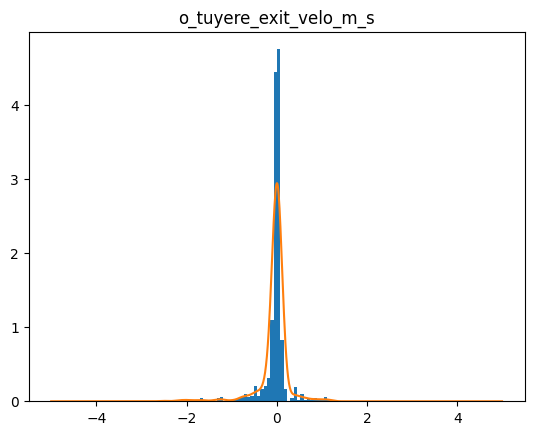

torch.Size([1000])
Epoch-13750 lr: 0.001
13751  loss=  tensor(0.0018, grad_fn=<MeanBackward0>)
13752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13760  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13766  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13768  loss=  tensor(0.0016, grad_fn=<Mea

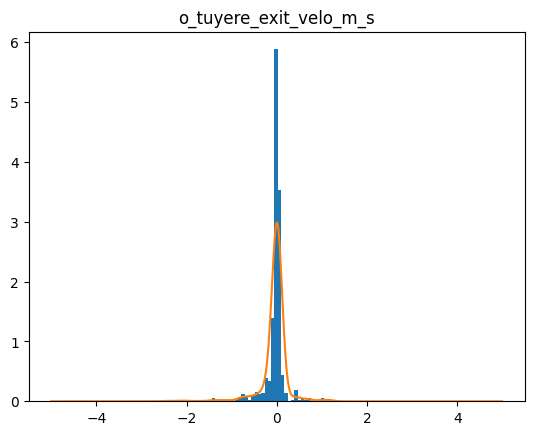

torch.Size([1000])
Epoch-13800 lr: 0.001
13801  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13806  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13808  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13814  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13818  loss=  tensor(0.0016, grad_fn=<Mea

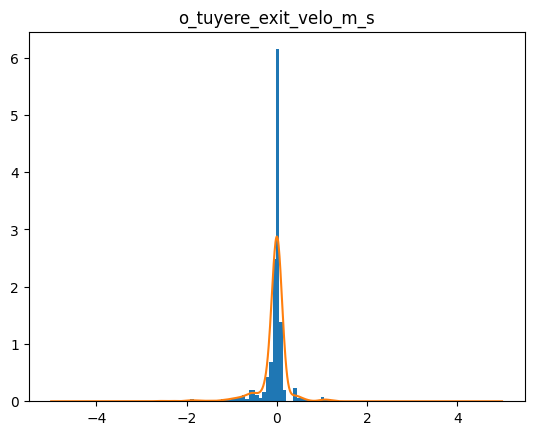

torch.Size([1000])
Epoch-13850 lr: 0.001
13851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13853  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13856  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13861  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13867  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13868  loss=  tensor(0.0016, grad_fn=<Mea

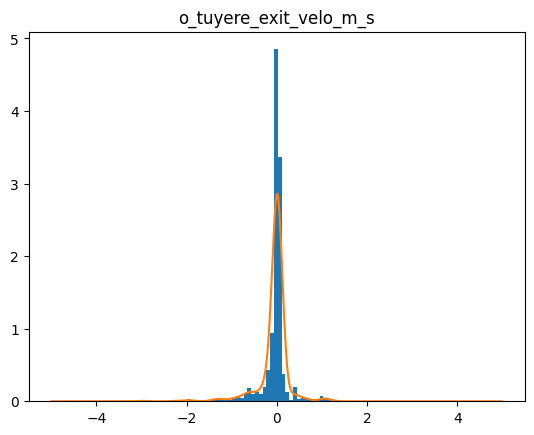

torch.Size([1000])
Epoch-13900 lr: 0.001
13901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13902  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13905  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13910  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13915  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13918  loss=  tensor(0.0016, grad_fn=<Mea

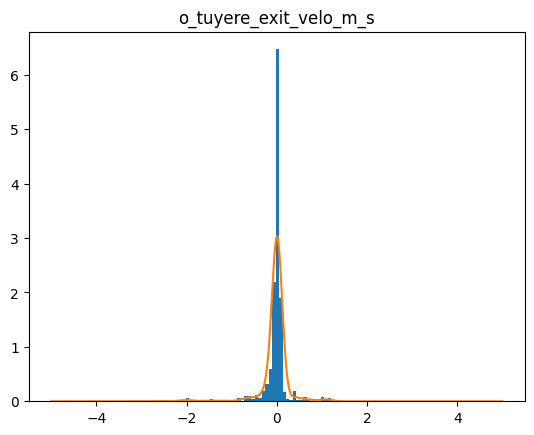

torch.Size([1000])
Epoch-13950 lr: 0.001
13951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13952  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13957  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13960  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13962  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
13966  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
13967  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
13968  loss=  tensor(0.0016, grad_fn=<Mea

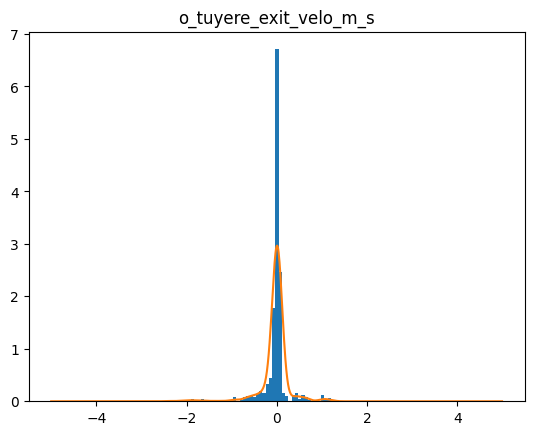

torch.Size([1000])
Epoch-14000 lr: 0.001
14001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14010  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14014  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14018  loss=  tensor(0.0016, grad_fn=<Mea

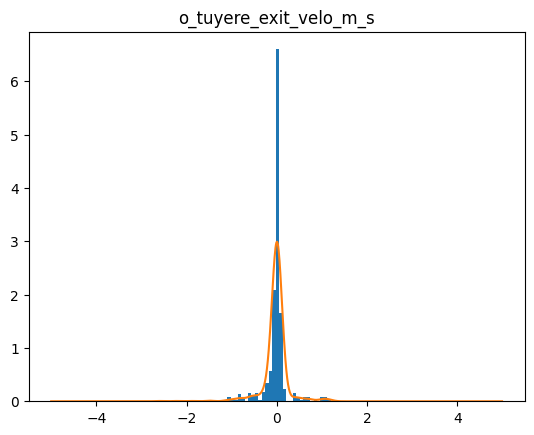

torch.Size([1000])
Epoch-14050 lr: 0.001
14051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14053  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14058  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14059  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14061  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14067  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14068  loss=  tensor(0.0016, grad_fn=<Mea

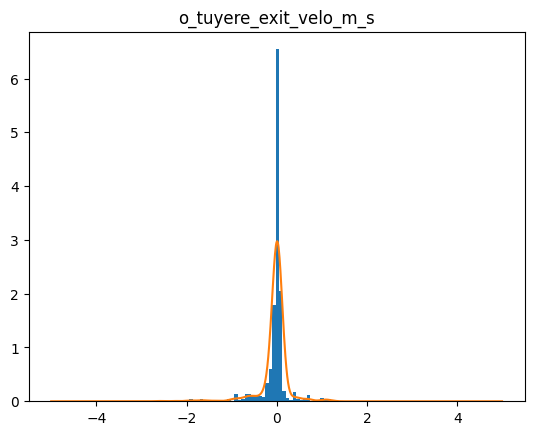

torch.Size([1000])
Epoch-14100 lr: 0.001
14101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14102  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14111  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14118  loss=  tensor(0.0016, grad_fn=<Mea

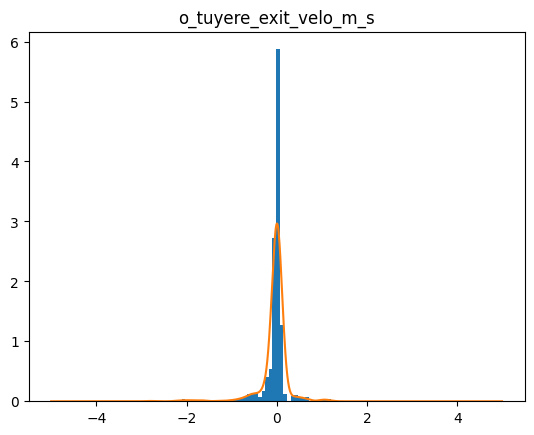

torch.Size([1000])
Epoch-14150 lr: 0.001
14151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14153  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14163  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14164  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14168  loss=  tensor(0.0016, grad_fn=<Mea

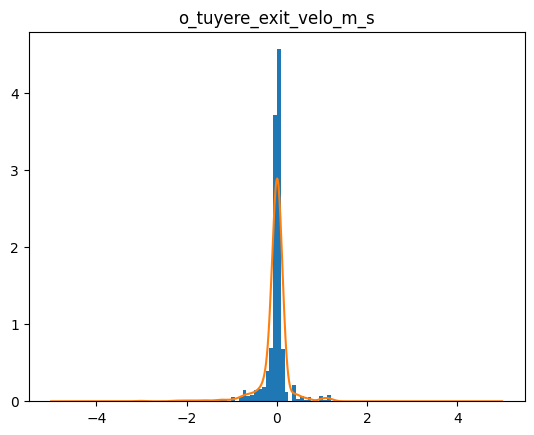

torch.Size([1000])
Epoch-14200 lr: 0.001
14201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14202  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14206  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14208  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14214  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14215  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14216  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14218  loss=  tensor(0.0016, grad_fn=<Mea

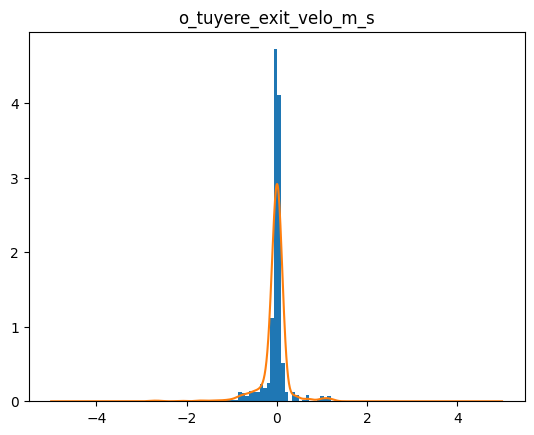

torch.Size([1000])
Epoch-14250 lr: 0.001
14251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14255  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14256  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14259  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14265  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14267  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14268  loss=  tensor(0.0016, grad_fn=<Mea

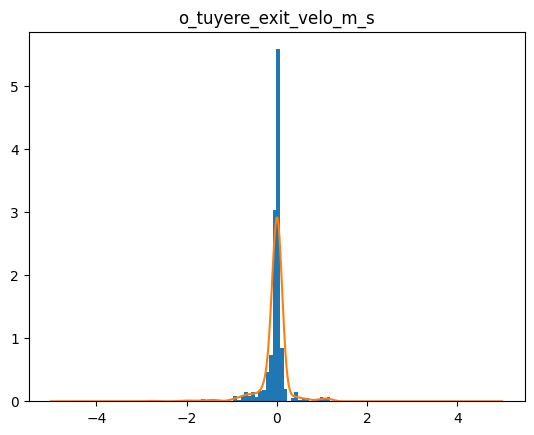

torch.Size([1000])
Epoch-14300 lr: 0.001
14301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14305  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14311  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14318  loss=  tensor(0.0016, grad_fn=<Mea

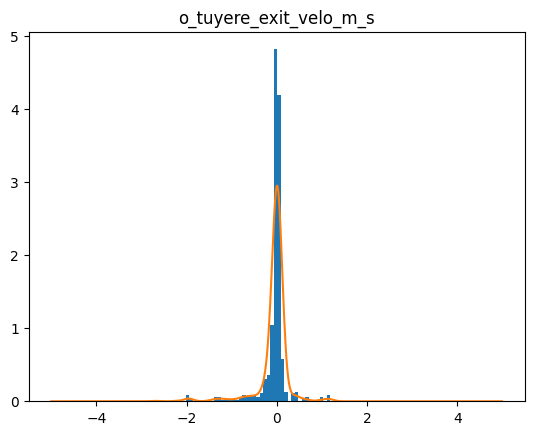

torch.Size([1000])
Epoch-14350 lr: 0.001
14351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14359  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14363  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14368  loss=  tensor(0.0016, grad_fn=<Mea

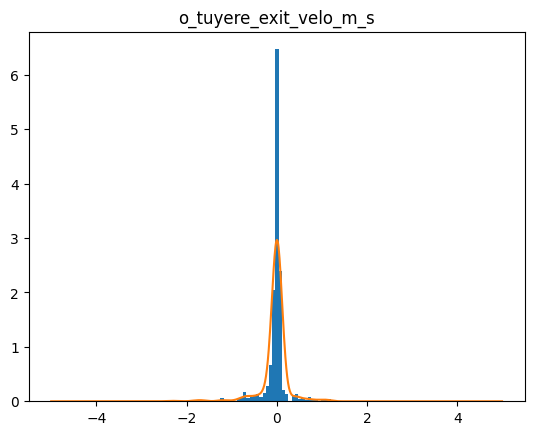

torch.Size([1000])
Epoch-14400 lr: 0.001
14401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14403  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14408  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14410  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14413  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14415  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14418  loss=  tensor(0.0016, grad_fn=<Mea

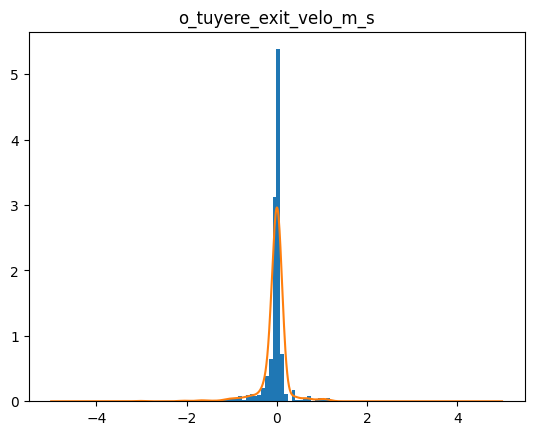

torch.Size([1000])
Epoch-14450 lr: 0.001
14451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14453  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14466  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14468  loss=  tensor(0.0016, grad_fn=<Mea

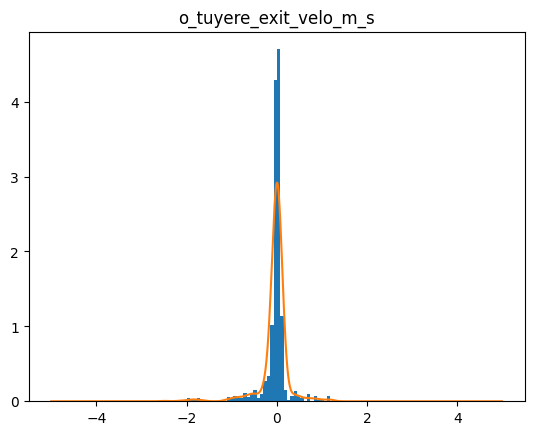

torch.Size([1000])
Epoch-14500 lr: 0.001
14501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14504  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14518  loss=  tensor(0.0017, grad_fn=<Mea

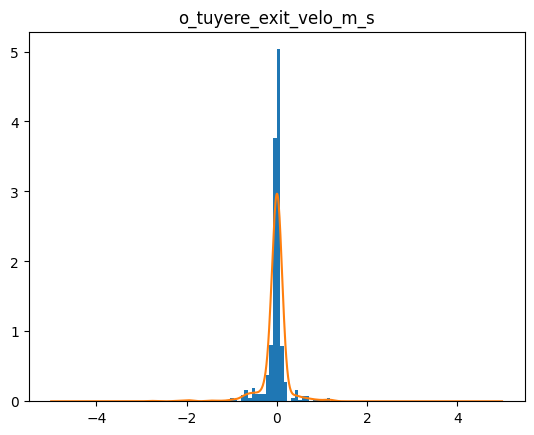

torch.Size([1000])
Epoch-14550 lr: 0.001
14551  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14563  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14568  loss=  tensor(0.0016, grad_fn=<Mea

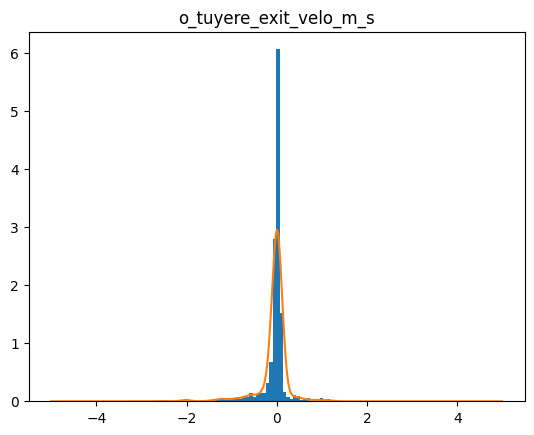

torch.Size([1000])
Epoch-14600 lr: 0.001
14601  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14602  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14610  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14613  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14615  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14616  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14617  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14618  loss=  tensor(0.0016, grad_fn=<Mea

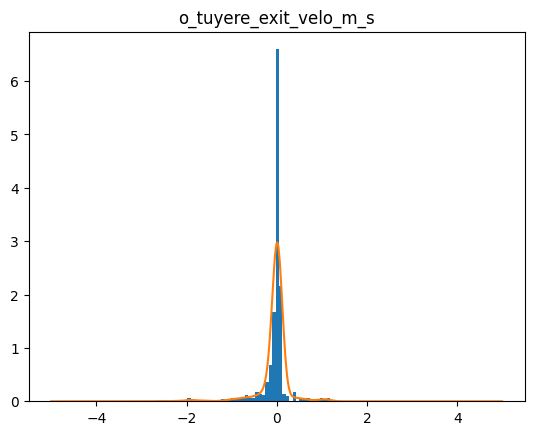

torch.Size([1000])
Epoch-14650 lr: 0.001
14651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14652  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14657  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14659  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14660  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14664  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14668  loss=  tensor(0.0015, grad_fn=<Mea

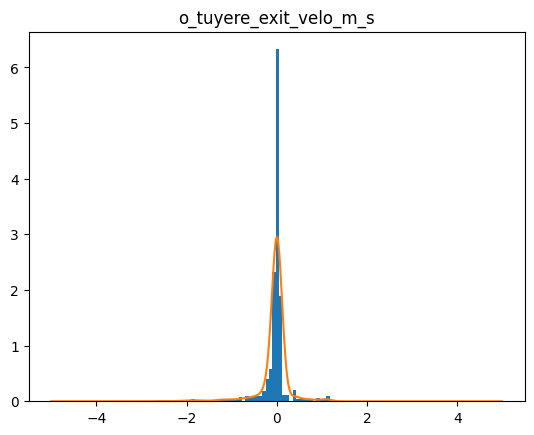

torch.Size([1000])
Epoch-14700 lr: 0.001
14701  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14704  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14705  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14709  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14710  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14711  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14712  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14713  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14718  loss=  tensor(0.0016, grad_fn=<Mea

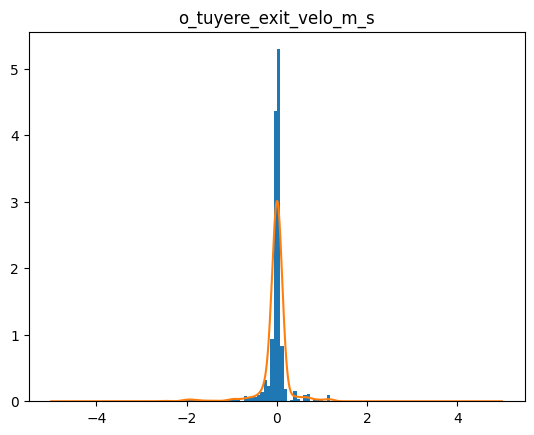

torch.Size([1000])
Epoch-14750 lr: 0.001
14751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14760  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14761  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14764  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14765  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14766  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14768  loss=  tensor(0.0016, grad_fn=<Mea

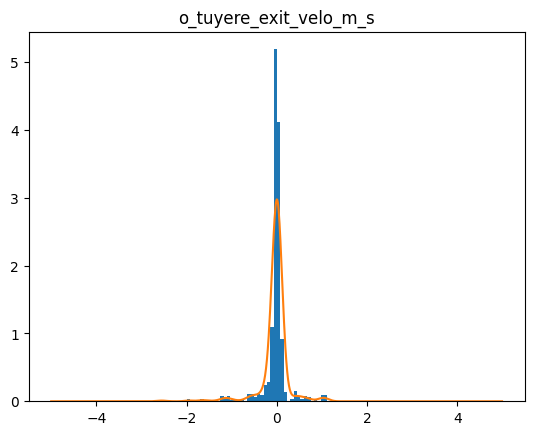

torch.Size([1000])
Epoch-14800 lr: 0.001
14801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14805  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14806  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14811  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14812  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14813  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14814  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14818  loss=  tensor(0.0016, grad_fn=<Mea

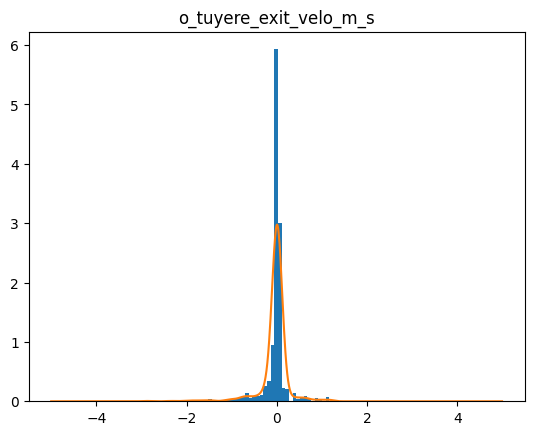

torch.Size([1000])
Epoch-14850 lr: 0.001
14851  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14855  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14861  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14864  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14868  loss=  tensor(0.0016, grad_fn=<Mea

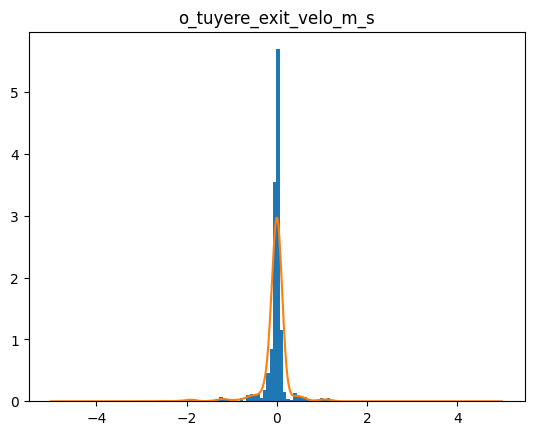

torch.Size([1000])
Epoch-14900 lr: 0.001
14901  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14905  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14914  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
14915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14917  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14918  loss=  tensor(0.0016, grad_fn=<Mea

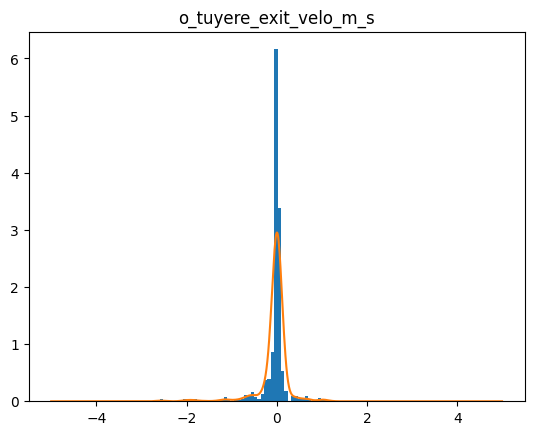

torch.Size([1000])
Epoch-14950 lr: 0.001
14951  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14953  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14956  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14958  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14960  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
14961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14962  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
14968  loss=  tensor(0.0016, grad_fn=<Mea

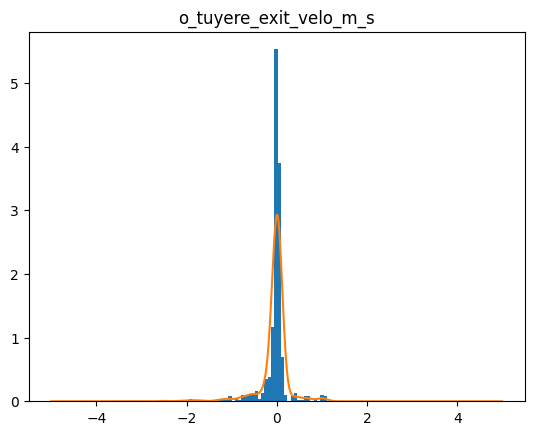

torch.Size([1000])
Epoch-15000 lr: 0.001
15001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15005  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15010  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15011  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15012  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15015  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15018  loss=  tensor(0.0016, grad_fn=<Mea

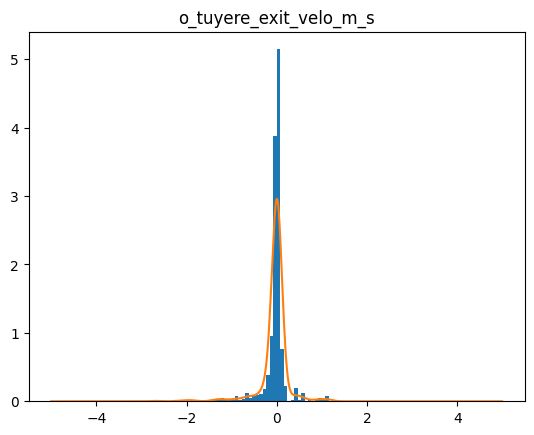

torch.Size([1000])
Epoch-15050 lr: 0.001
15051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15056  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15057  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15058  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15060  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15061  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15062  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15068  loss=  tensor(0.0016, grad_fn=<Mea

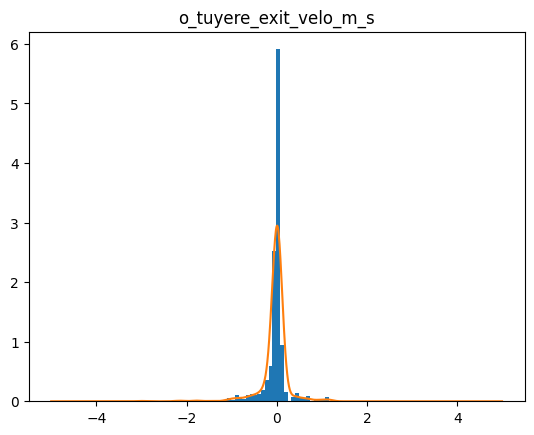

torch.Size([1000])
Epoch-15100 lr: 0.001
15101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15102  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15104  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15106  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15111  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15113  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15114  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15118  loss=  tensor(0.0016, grad_fn=<Mea

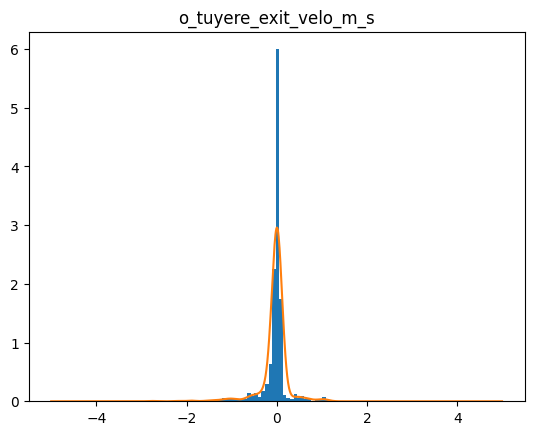

torch.Size([1000])
Epoch-15150 lr: 0.001
15151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15153  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15156  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15158  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15162  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15168  loss=  tensor(0.0016, grad_fn=<Mea

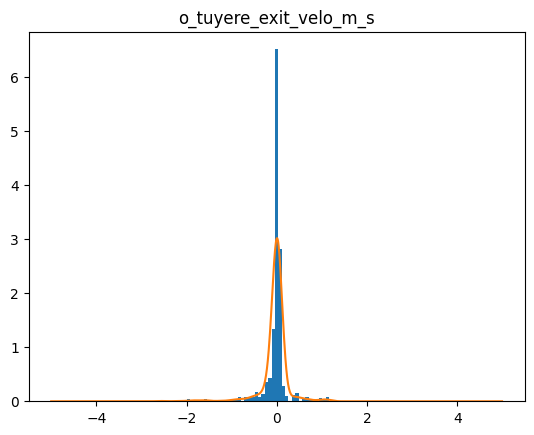

torch.Size([1000])
Epoch-15200 lr: 0.001
15201  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15206  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15210  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15216  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15217  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15218  loss=  tensor(0.0016, grad_fn=<Mea

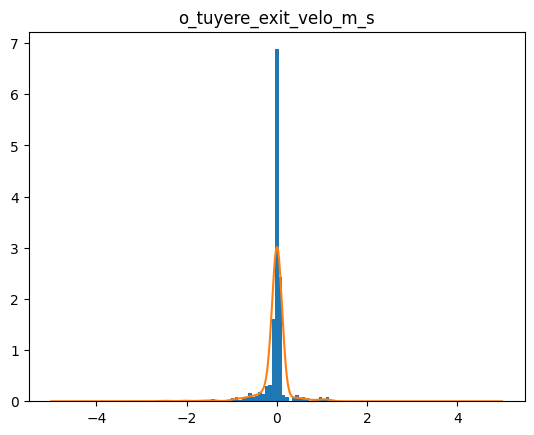

torch.Size([1000])
Epoch-15250 lr: 0.001
15251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15255  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15265  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15267  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15268  loss=  tensor(0.0015, grad_fn=<Mea

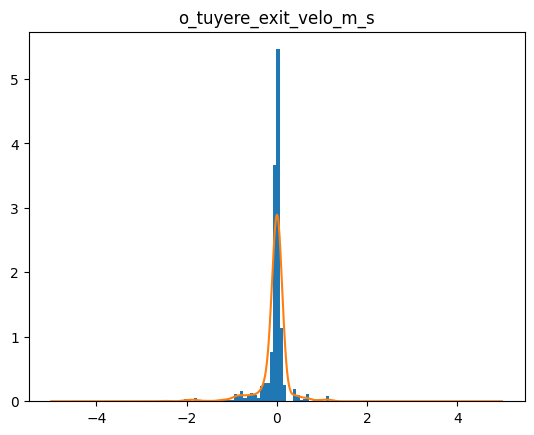

torch.Size([1000])
Epoch-15300 lr: 0.001
15301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15308  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15311  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15312  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15314  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15316  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15318  loss=  tensor(0.0017, grad_fn=<Mea

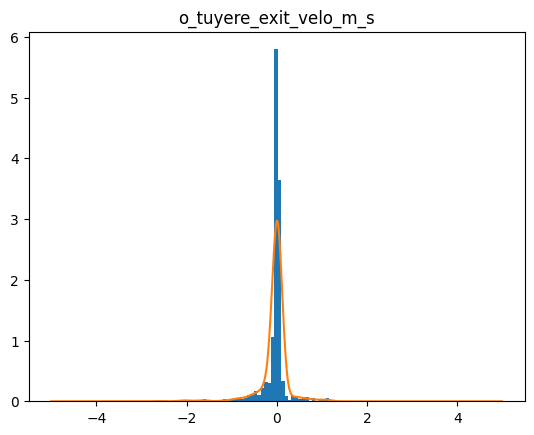

torch.Size([1000])
Epoch-15350 lr: 0.001
15351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15354  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15358  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15361  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15363  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15364  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15366  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15368  loss=  tensor(0.0016, grad_fn=<Mea

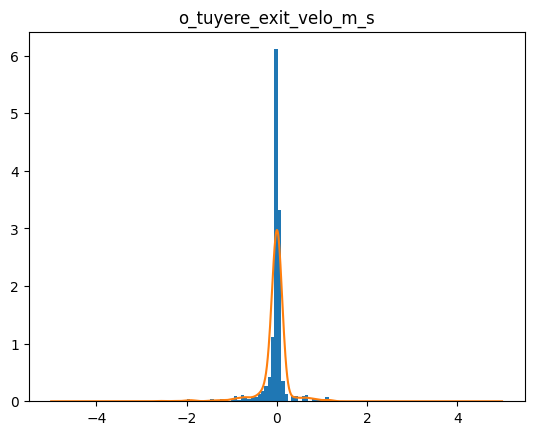

torch.Size([1000])
Epoch-15400 lr: 0.001
15401  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15409  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15412  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15417  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15418  loss=  tensor(0.0016, grad_fn=<Mea

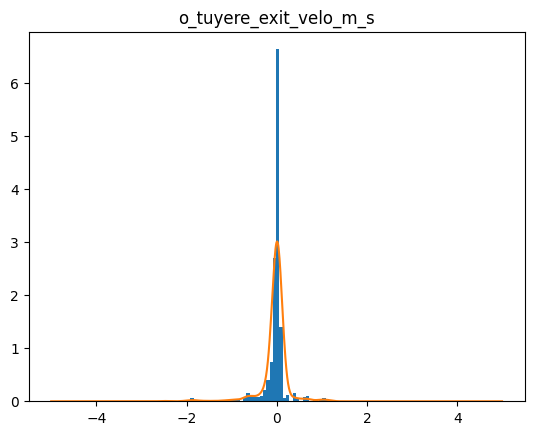

torch.Size([1000])
Epoch-15450 lr: 0.001
15451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15453  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15457  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15460  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15463  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15464  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15467  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15468  loss=  tensor(0.0016, grad_fn=<Mea

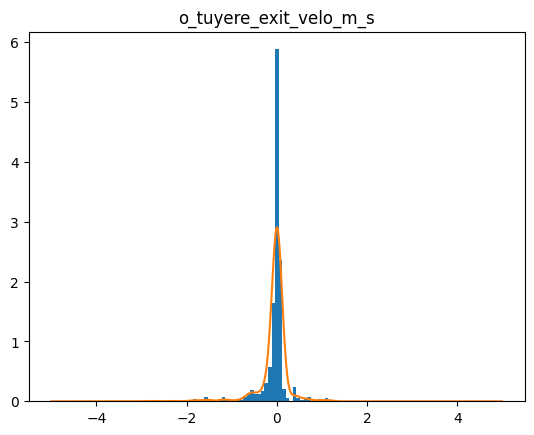

torch.Size([1000])
Epoch-15500 lr: 0.001
15501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15510  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15513  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15514  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15515  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15516  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15518  loss=  tensor(0.0015, grad_fn=<Mea

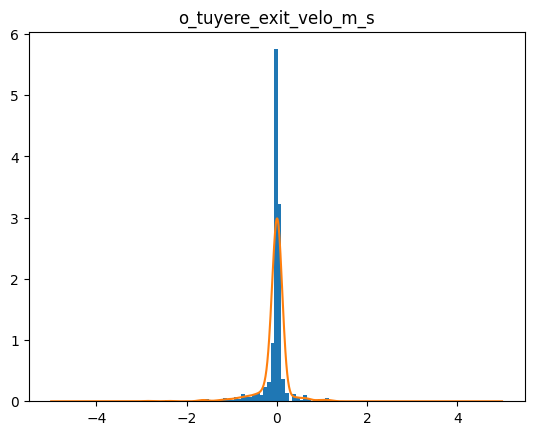

torch.Size([1000])
Epoch-15550 lr: 0.001
15551  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15552  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15555  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15560  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15564  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15565  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15566  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15568  loss=  tensor(0.0016, grad_fn=<Mea

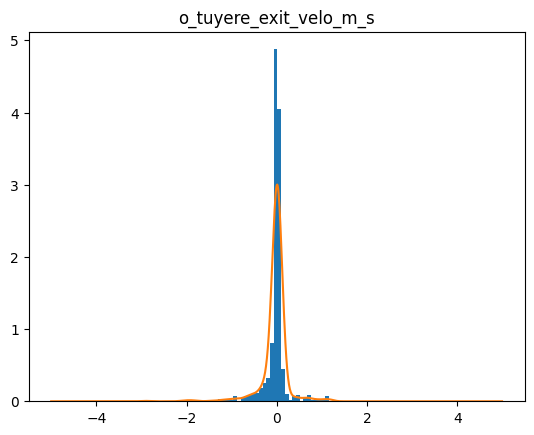

torch.Size([1000])
Epoch-15600 lr: 0.001
15601  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15605  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15607  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15608  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15612  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15613  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15616  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15618  loss=  tensor(0.0015, grad_fn=<Mea

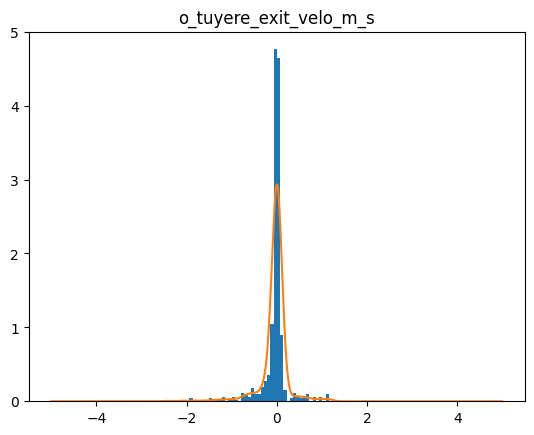

torch.Size([1000])
Epoch-15650 lr: 0.001
15651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15653  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15655  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15662  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15666  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15668  loss=  tensor(0.0017, grad_fn=<Mea

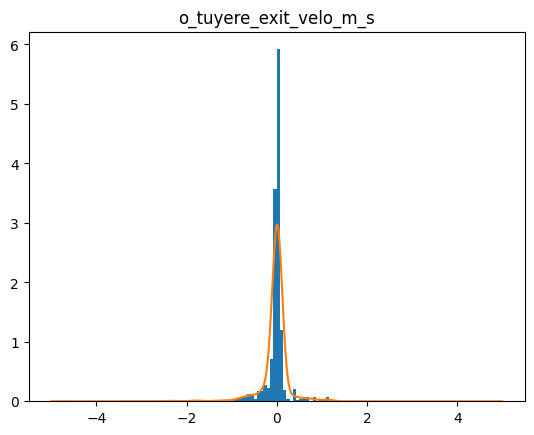

torch.Size([1000])
Epoch-15700 lr: 0.001
15701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15705  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15706  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15709  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15713  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15714  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15717  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15718  loss=  tensor(0.0016, grad_fn=<Mea

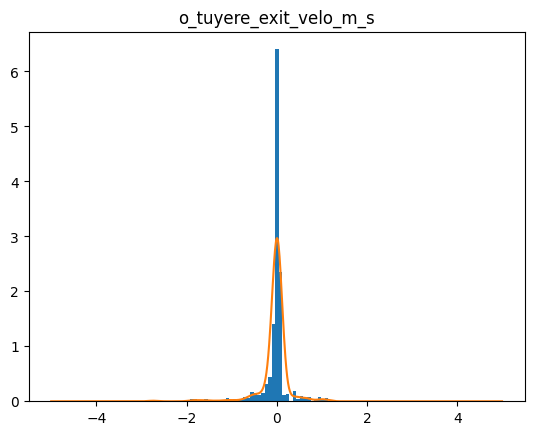

torch.Size([1000])
Epoch-15750 lr: 0.001
15751  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15752  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15753  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15754  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
15755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15764  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15765  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15768  loss=  tensor(0.0016, grad_fn=<Mea

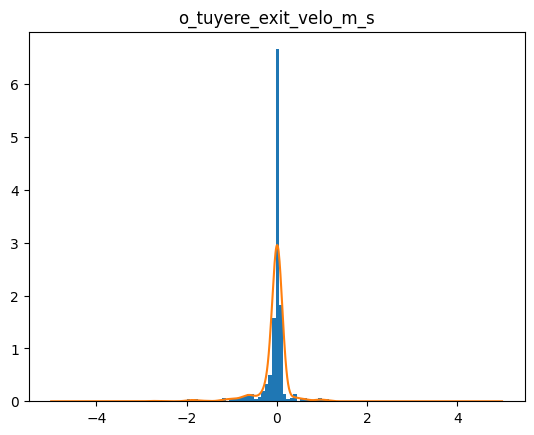

torch.Size([1000])
Epoch-15800 lr: 0.001
15801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15804  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15807  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15812  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15818  loss=  tensor(0.0016, grad_fn=<Mea

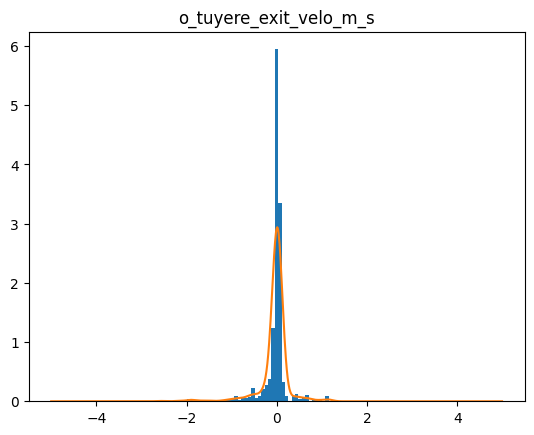

torch.Size([1000])
Epoch-15850 lr: 0.001
15851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15853  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15854  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15855  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15858  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15861  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15866  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15868  loss=  tensor(0.0016, grad_fn=<Mea

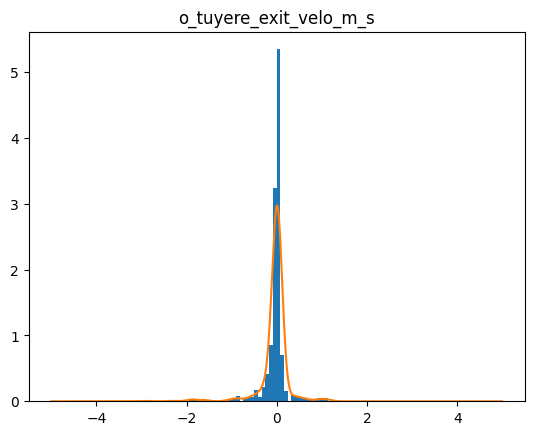

torch.Size([1000])
Epoch-15900 lr: 0.001
15901  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15903  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15907  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15915  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15918  loss=  tensor(0.0015, grad_fn=<Mea

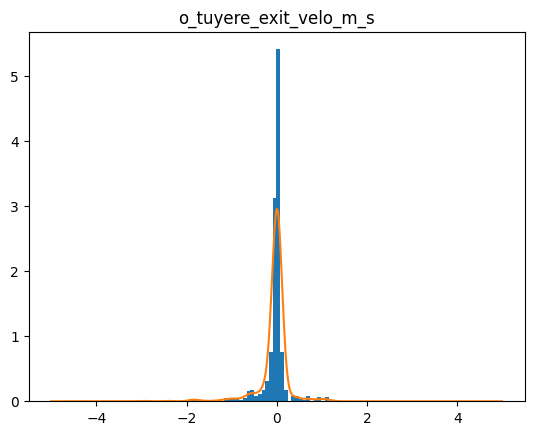

torch.Size([1000])
Epoch-15950 lr: 0.001
15951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15953  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15954  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15955  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15957  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15958  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15961  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15962  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15966  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
15967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
15968  loss=  tensor(0.0016, grad_fn=<Mea

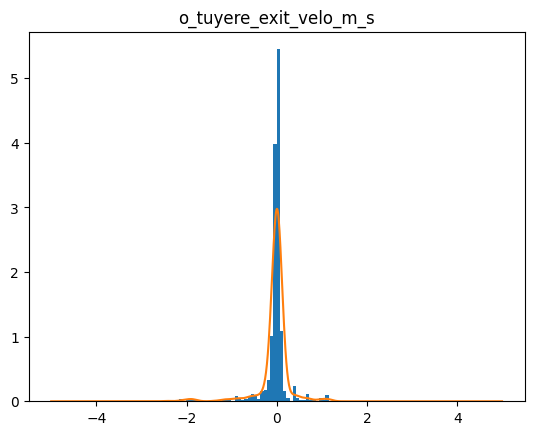

torch.Size([1000])
Epoch-16000 lr: 0.001
16001  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16005  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16008  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16009  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16010  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16011  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16012  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16016  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16018  loss=  tensor(0.0016, grad_fn=<Mea

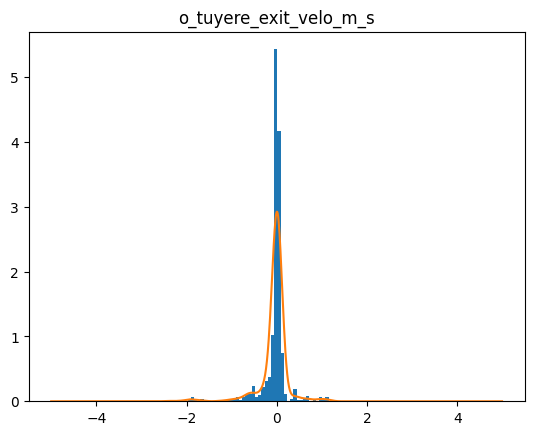

torch.Size([1000])
Epoch-16050 lr: 0.001
16051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16059  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16061  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16062  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16068  loss=  tensor(0.0016, grad_fn=<Mea

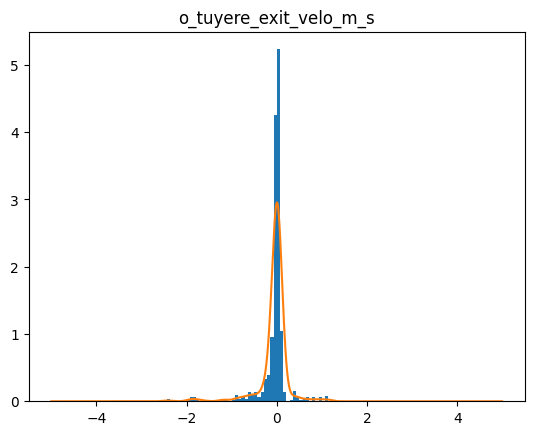

torch.Size([1000])
Epoch-16100 lr: 0.001
16101  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16102  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16103  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16108  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16117  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16118  loss=  tensor(0.0015, grad_fn=<Mea

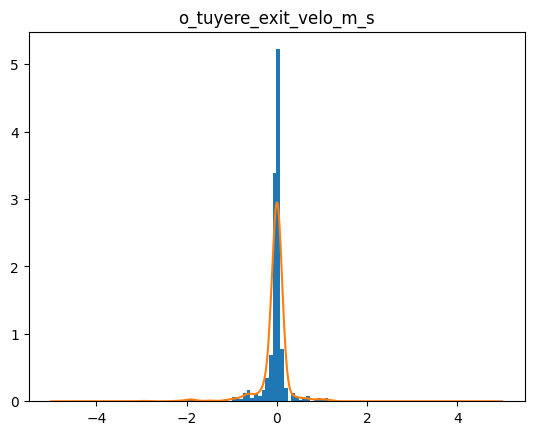

torch.Size([1000])
Epoch-16150 lr: 0.001
16151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16153  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16155  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16158  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16162  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16163  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16164  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16165  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16167  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16168  loss=  tensor(0.0015, grad_fn=<Mea

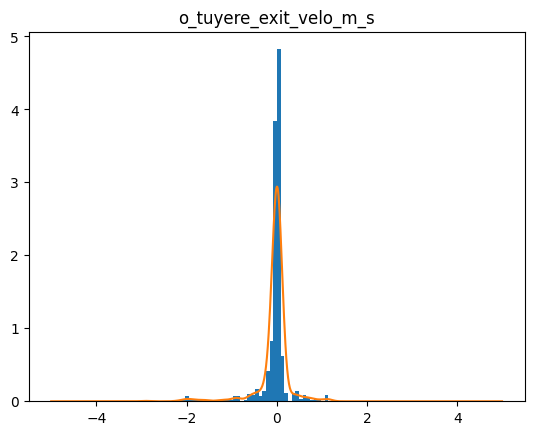

torch.Size([1000])
Epoch-16200 lr: 0.001
16201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16202  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16204  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16205  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16206  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16212  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16216  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16217  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16218  loss=  tensor(0.0016, grad_fn=<Mea

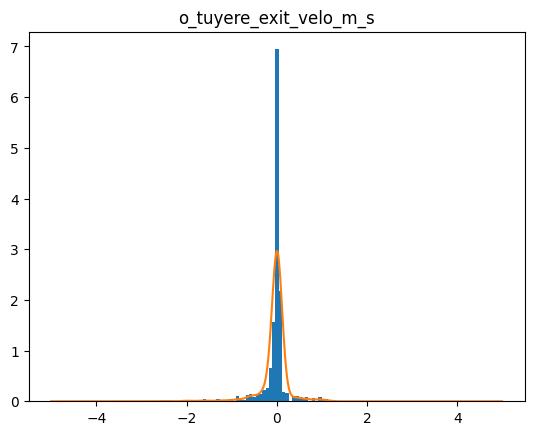

torch.Size([1000])
Epoch-16250 lr: 0.001
16251  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16252  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16253  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16254  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16259  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16263  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16265  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16267  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16268  loss=  tensor(0.0017, grad_fn=<Mea

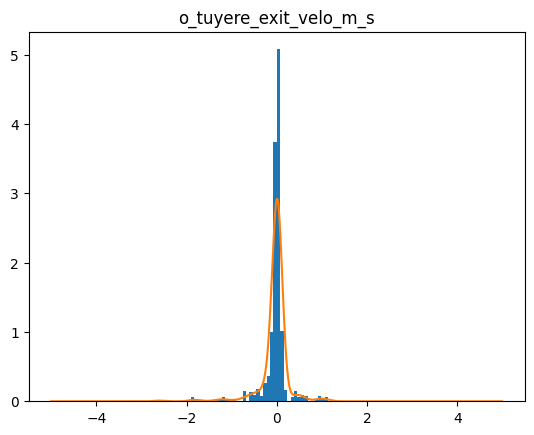

torch.Size([1000])
Epoch-16300 lr: 0.001
16301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16303  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16304  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16308  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16309  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16310  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16311  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16312  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16313  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16318  loss=  tensor(0.0016, grad_fn=<Mea

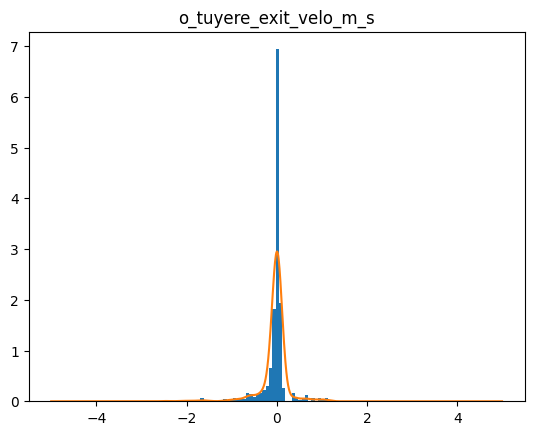

torch.Size([1000])
Epoch-16350 lr: 0.001
16351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16353  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16356  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16357  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16358  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16359  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16360  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16361  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16363  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16364  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16365  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16366  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16367  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16368  loss=  tensor(0.0015, grad_fn=<Mea

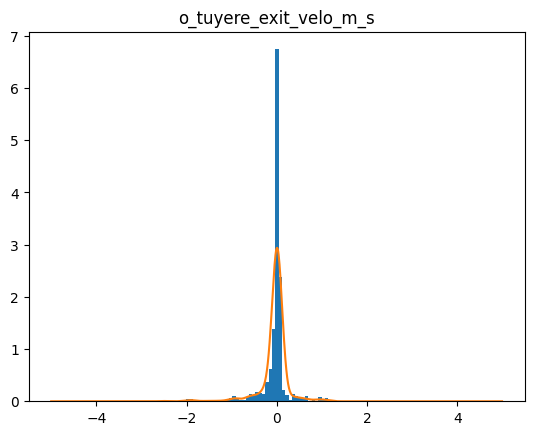

torch.Size([1000])
Epoch-16400 lr: 0.001
16401  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16404  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16406  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16407  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16409  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16410  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16412  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16414  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16415  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16417  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16418  loss=  tensor(0.0016, grad_fn=<Mea

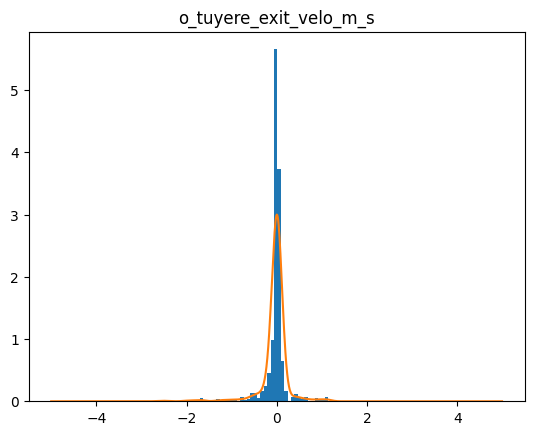

torch.Size([1000])
Epoch-16450 lr: 0.001
16451  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16453  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16455  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16458  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16463  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16464  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16465  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16468  loss=  tensor(0.0015, grad_fn=<Mea

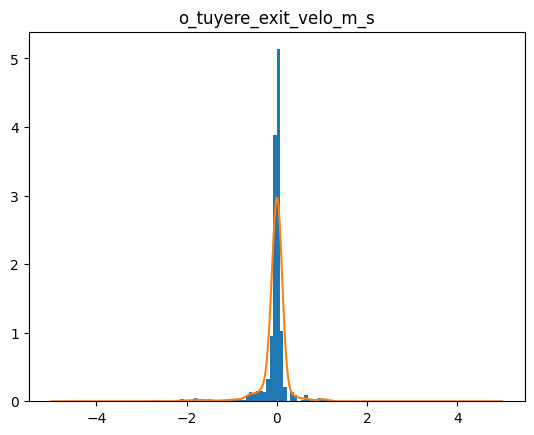

torch.Size([1000])
Epoch-16500 lr: 0.001
16501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16503  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16511  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16512  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16513  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16514  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16516  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16518  loss=  tensor(0.0016, grad_fn=<Mea

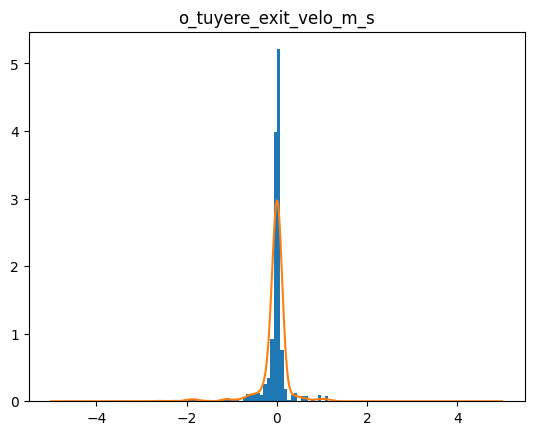

torch.Size([1000])
Epoch-16550 lr: 0.001
16551  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16553  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16558  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16565  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16567  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16568  loss=  tensor(0.0016, grad_fn=<Mea

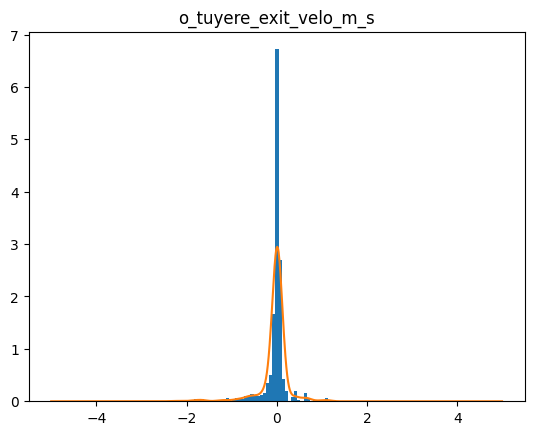

torch.Size([1000])
Epoch-16600 lr: 0.001
16601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16602  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16603  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16607  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16608  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16611  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16613  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16614  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16616  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16618  loss=  tensor(0.0015, grad_fn=<Mea

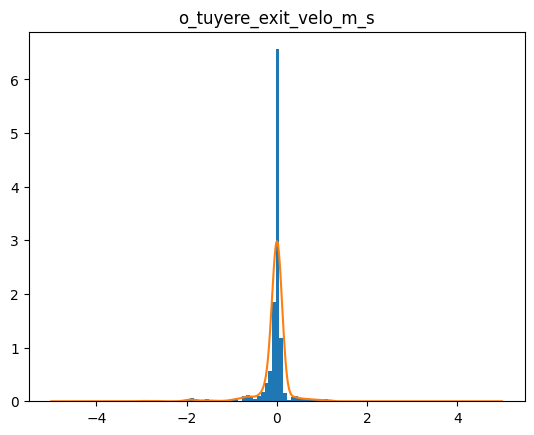

torch.Size([1000])
Epoch-16650 lr: 0.001
16651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16652  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16654  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16656  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16657  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16660  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16662  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16663  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16664  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16665  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16666  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16668  loss=  tensor(0.0015, grad_fn=<Mea

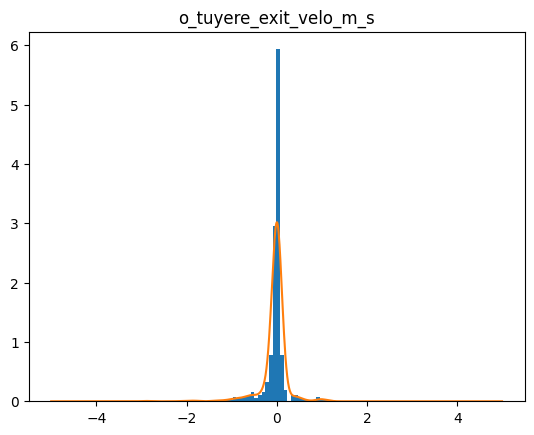

torch.Size([1000])
Epoch-16700 lr: 0.001
16701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16703  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16704  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16706  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16709  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16714  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16716  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16718  loss=  tensor(0.0015, grad_fn=<Mea

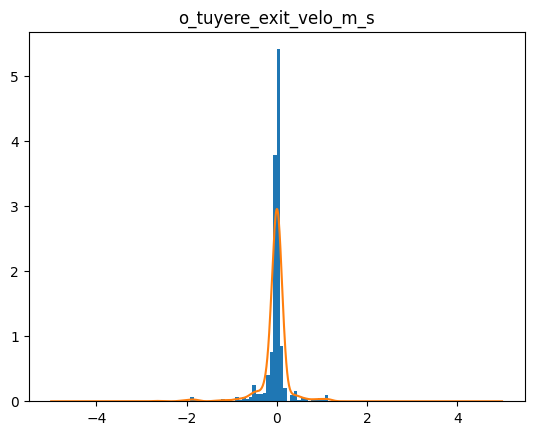

torch.Size([1000])
Epoch-16750 lr: 0.001
16751  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16752  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16760  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16761  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16767  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16768  loss=  tensor(0.0016, grad_fn=<Mea

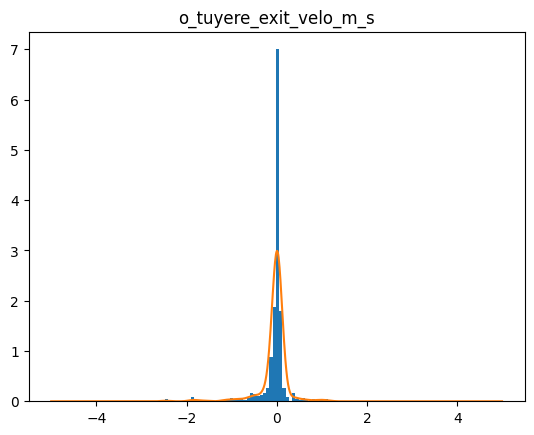

torch.Size([1000])
Epoch-16800 lr: 0.001
16801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16802  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16805  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16808  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16811  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16813  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16814  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16817  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16818  loss=  tensor(0.0015, grad_fn=<Mea

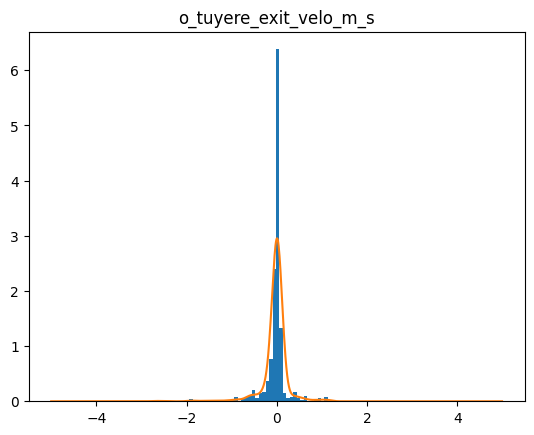

torch.Size([1000])
Epoch-16850 lr: 0.001
16851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16852  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16853  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16854  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16855  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16856  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16859  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16860  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16862  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16866  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16868  loss=  tensor(0.0015, grad_fn=<Mea

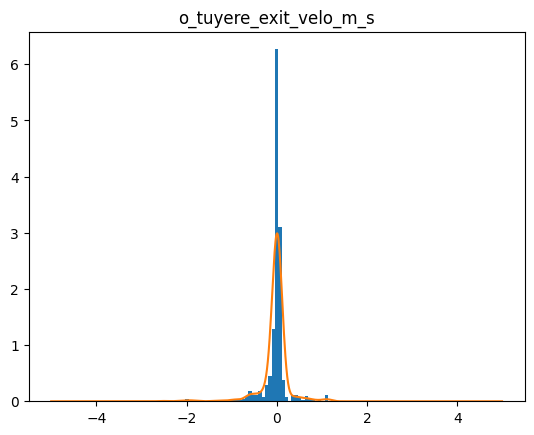

torch.Size([1000])
Epoch-16900 lr: 0.001
16901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16903  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16904  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16907  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16910  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16913  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16914  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16918  loss=  tensor(0.0016, grad_fn=<Mea

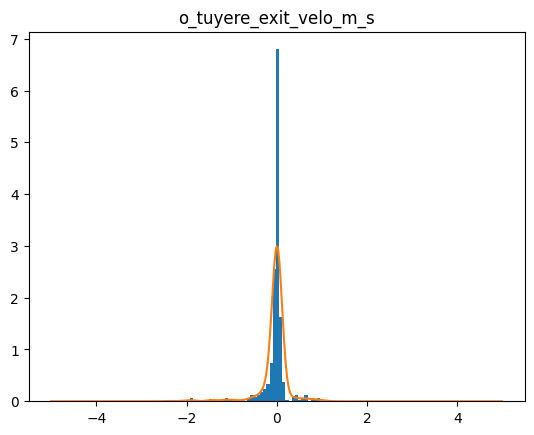

torch.Size([1000])
Epoch-16950 lr: 0.001
16951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16953  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
16954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16958  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16959  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16961  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16962  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
16966  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16967  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
16968  loss=  tensor(0.0016, grad_fn=<Mea

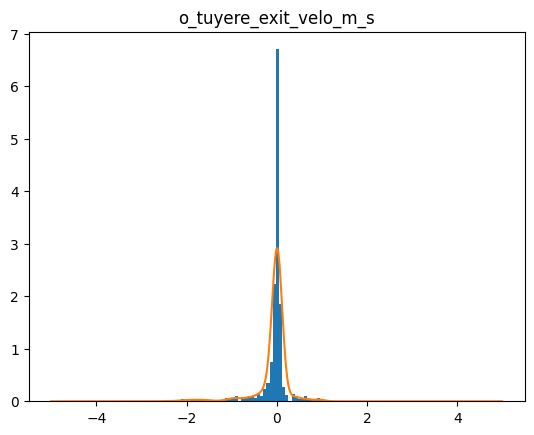

torch.Size([1000])
Epoch-17000 lr: 0.001
17001  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17002  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17003  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17005  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17006  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17009  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17010  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17011  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17012  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17013  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17016  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17017  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17018  loss=  tensor(0.0015, grad_fn=<Mea

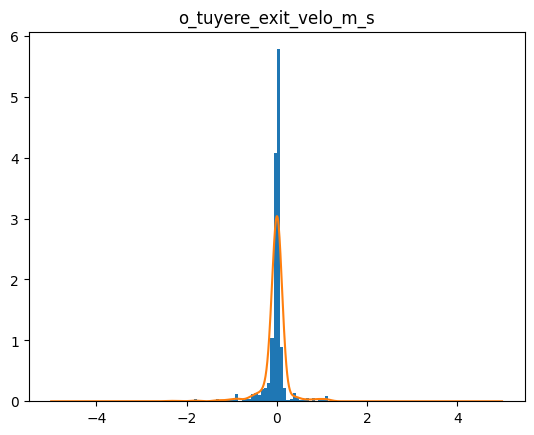

torch.Size([1000])
Epoch-17050 lr: 0.001
17051  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17054  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17059  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17061  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17062  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17064  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17065  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17067  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17068  loss=  tensor(0.0016, grad_fn=<Mea

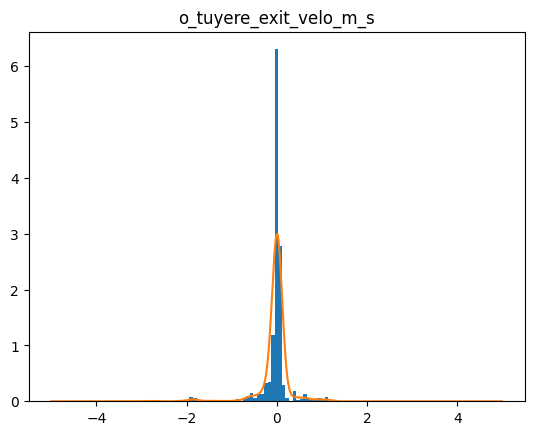

torch.Size([1000])
Epoch-17100 lr: 0.001
17101  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17102  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17104  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17108  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17109  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17110  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17113  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17114  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17116  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17118  loss=  tensor(0.0015, grad_fn=<Mea

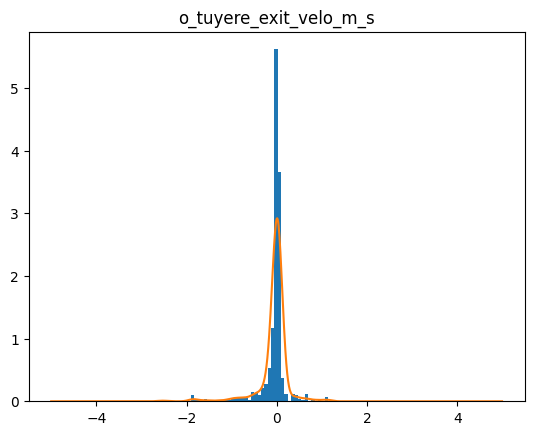

torch.Size([1000])
Epoch-17150 lr: 0.001
17151  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17152  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17154  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17156  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17158  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17160  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17161  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17162  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17163  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17164  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17165  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17166  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17168  loss=  tensor(0.0016, grad_fn=<Mea

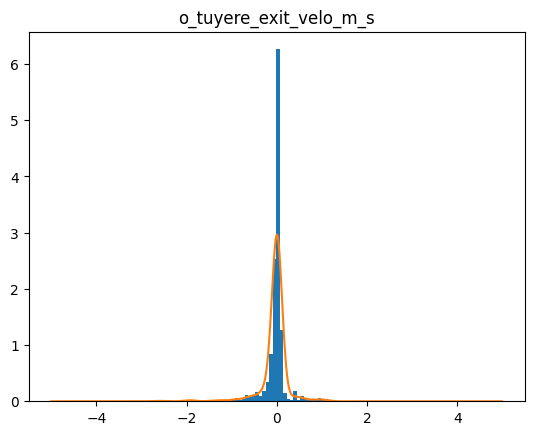

torch.Size([1000])
Epoch-17200 lr: 0.001
17201  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17202  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17204  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17205  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17206  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17209  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17210  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17212  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17213  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17214  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17216  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17217  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17218  loss=  tensor(0.0016, grad_fn=<Mea

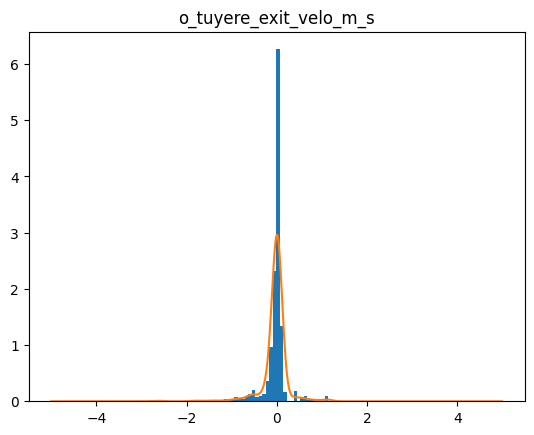

torch.Size([1000])
Epoch-17250 lr: 0.001
17251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17252  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17255  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17256  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17257  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17259  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17260  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17263  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17264  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17265  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17266  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17267  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17268  loss=  tensor(0.0016, grad_fn=<Mea

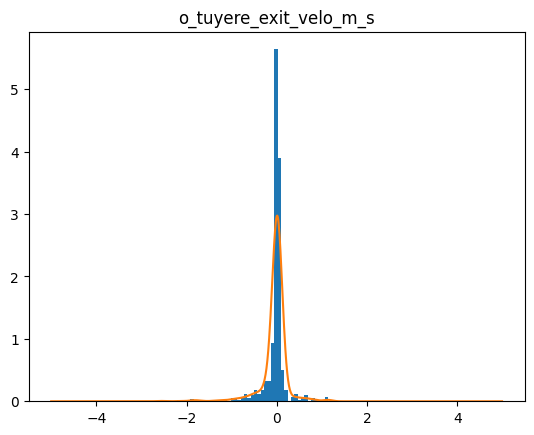

torch.Size([1000])
Epoch-17300 lr: 0.001
17301  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17302  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17303  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17304  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17305  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17308  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17309  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17310  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17311  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17312  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17313  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17315  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17316  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17317  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17318  loss=  tensor(0.0015, grad_fn=<Mea

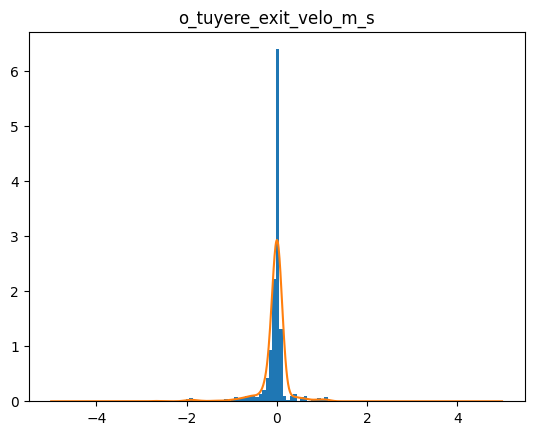

torch.Size([1000])
Epoch-17350 lr: 0.001
17351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17353  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17354  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17355  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17357  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17358  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17359  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17360  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17361  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17362  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17363  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17364  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17365  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17367  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17368  loss=  tensor(0.0015, grad_fn=<Mea

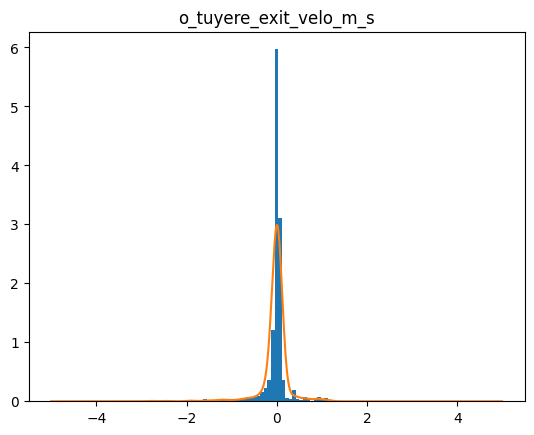

torch.Size([1000])
Epoch-17400 lr: 0.001
17401  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17403  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17405  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17406  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17407  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17408  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17410  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17411  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17413  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17414  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17418  loss=  tensor(0.0015, grad_fn=<Mea

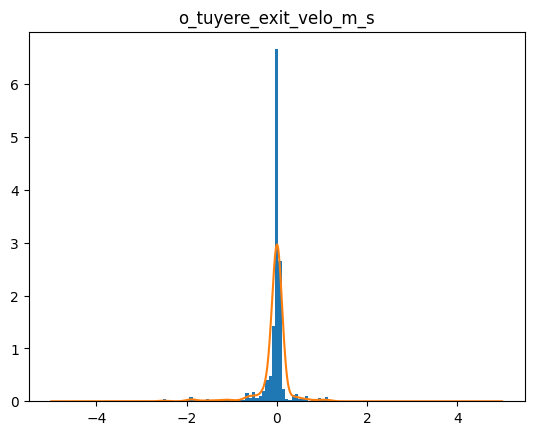

torch.Size([1000])
Epoch-17450 lr: 0.001
17451  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17453  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17454  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17455  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17456  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17457  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17458  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17459  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17460  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17461  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17462  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17463  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17465  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17467  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17468  loss=  tensor(0.0016, grad_fn=<Mea

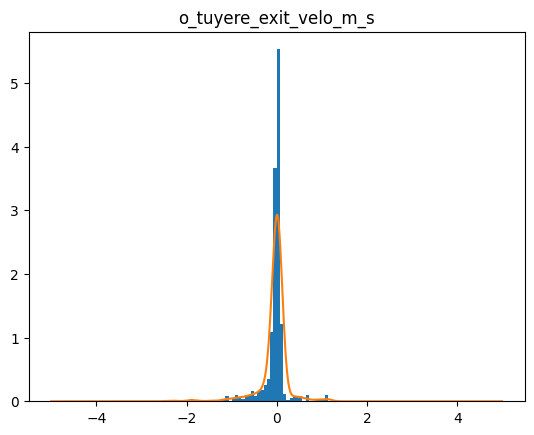

torch.Size([1000])
Epoch-17500 lr: 0.001
17501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17502  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17505  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17506  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17507  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17508  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17511  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17512  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17516  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17518  loss=  tensor(0.0015, grad_fn=<Mea

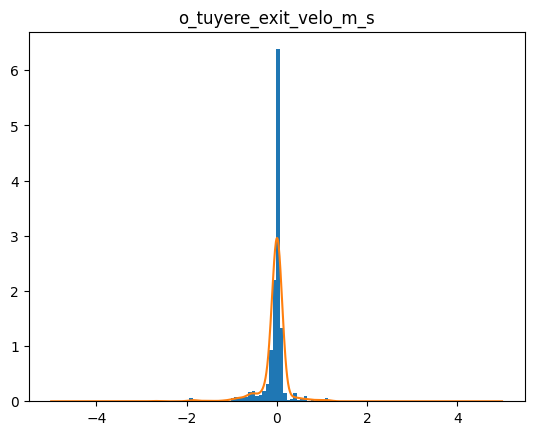

torch.Size([1000])
Epoch-17550 lr: 0.001
17551  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17552  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17557  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17558  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17560  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17563  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17564  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17565  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17567  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17568  loss=  tensor(0.0015, grad_fn=<Mea

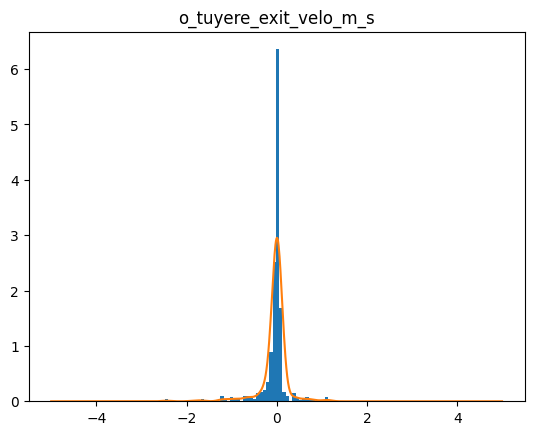

torch.Size([1000])
Epoch-17600 lr: 0.001
17601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17602  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17603  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17605  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17606  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17607  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17608  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17609  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17610  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17612  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17613  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17616  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17617  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17618  loss=  tensor(0.0015, grad_fn=<Mea

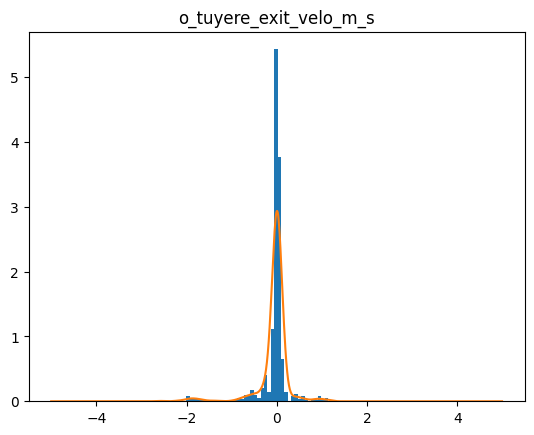

torch.Size([1000])
Epoch-17650 lr: 0.001
17651  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17654  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17655  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17656  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17658  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17659  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17661  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17662  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17663  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17664  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17665  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17666  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17667  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17668  loss=  tensor(0.0016, grad_fn=<Mea

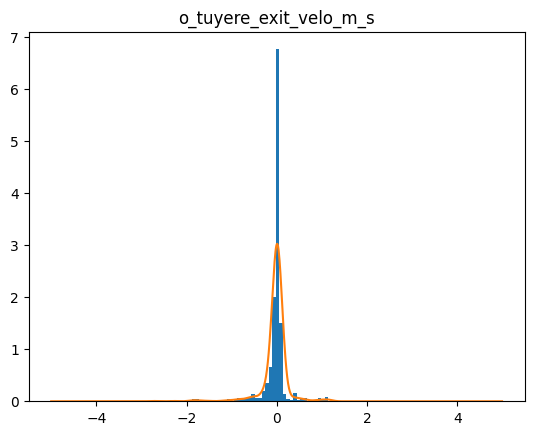

torch.Size([1000])
Epoch-17700 lr: 0.001
17701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17702  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17703  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17704  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17708  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17710  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17711  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17712  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17713  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17715  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17718  loss=  tensor(0.0016, grad_fn=<Mea

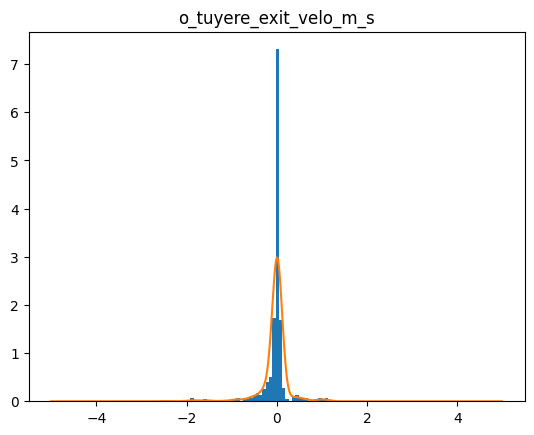

torch.Size([1000])
Epoch-17750 lr: 0.001
17751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17752  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17753  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17757  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17761  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17762  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17763  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17764  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17765  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17766  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17768  loss=  tensor(0.0016, grad_fn=<Mea

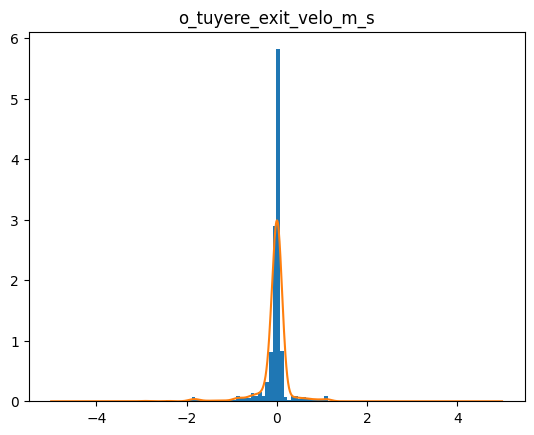

torch.Size([1000])
Epoch-17800 lr: 0.001
17801  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17804  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17805  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17807  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17809  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17810  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17811  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17813  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17814  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17815  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17816  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17817  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17818  loss=  tensor(0.0015, grad_fn=<Mea

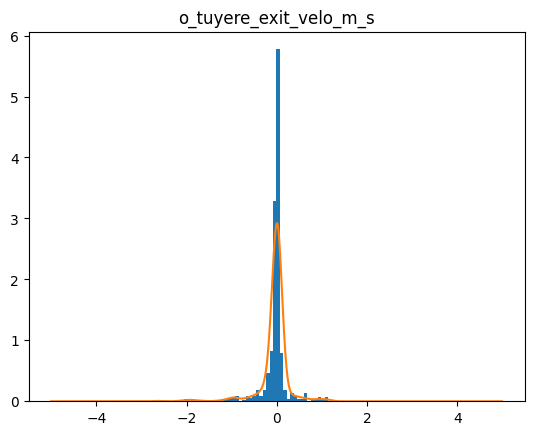

torch.Size([1000])
Epoch-17850 lr: 0.001
17851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17852  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17855  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17857  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17858  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17859  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17862  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17863  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17864  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17866  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17868  loss=  tensor(0.0016, grad_fn=<Mea

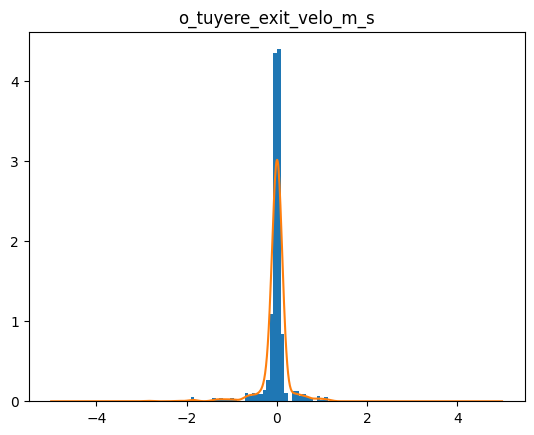

torch.Size([1000])
Epoch-17900 lr: 0.001
17901  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17903  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17904  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17908  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17910  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17912  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17913  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17914  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17916  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17917  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17918  loss=  tensor(0.0016, grad_fn=<Mea

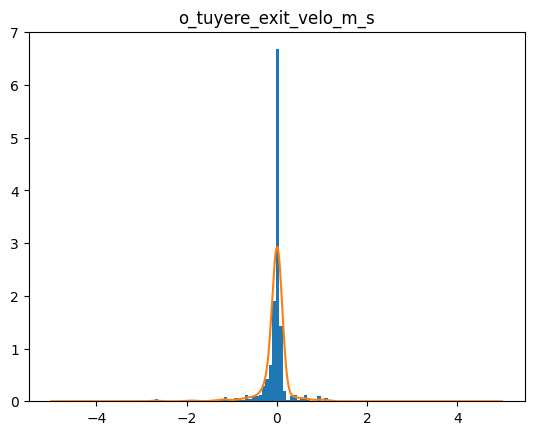

torch.Size([1000])
Epoch-17950 lr: 0.001
17951  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17952  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17953  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17954  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17955  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17959  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17960  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17961  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17962  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17963  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17964  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17965  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
17967  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
17968  loss=  tensor(0.0015, grad_fn=<Mea

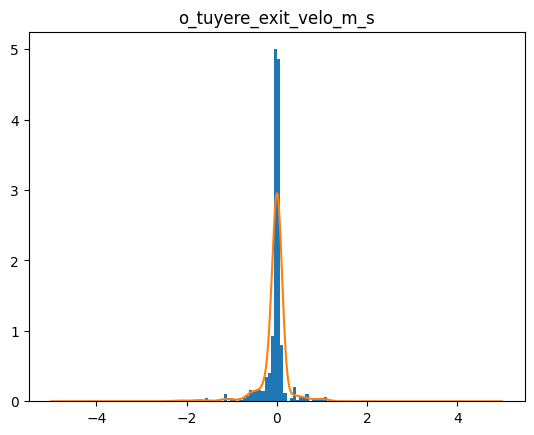

torch.Size([1000])
Epoch-18000 lr: 0.001
18001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18002  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18004  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18005  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18007  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18008  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18009  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18010  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18011  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18012  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18016  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18017  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18018  loss=  tensor(0.0016, grad_fn=<Mea

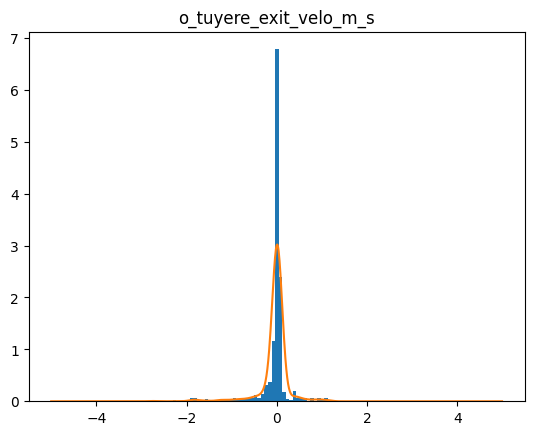

torch.Size([1000])
Epoch-18050 lr: 0.001
18051  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18053  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18054  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18055  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18056  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18057  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18058  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18059  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18060  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18061  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18062  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18063  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18065  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18066  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18067  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18068  loss=  tensor(0.0015, grad_fn=<Mea

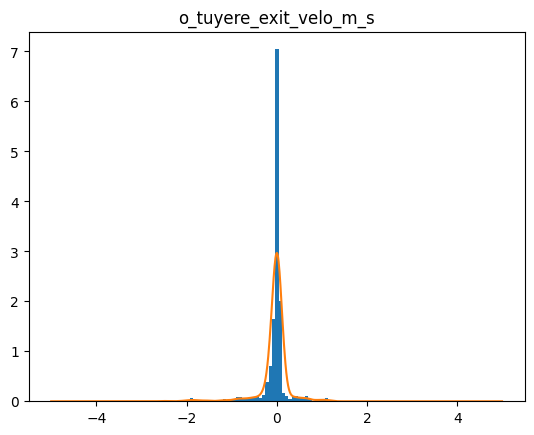

torch.Size([1000])
Epoch-18100 lr: 0.001
18101  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18102  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18105  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18107  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18108  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18109  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18110  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18111  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18112  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18116  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18118  loss=  tensor(0.0016, grad_fn=<Mea

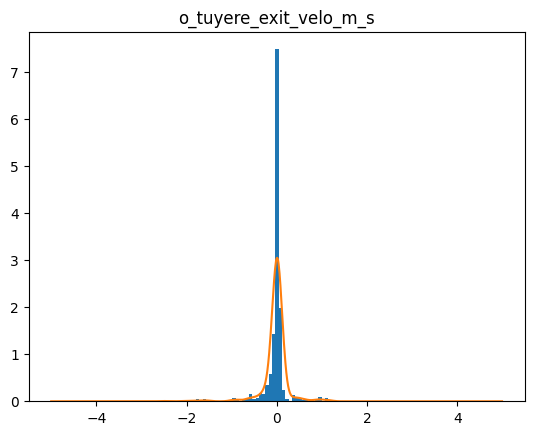

torch.Size([1000])
Epoch-18150 lr: 0.001
18151  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18152  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18153  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18154  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18156  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18157  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18158  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18159  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18160  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18161  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18163  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18165  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18166  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18168  loss=  tensor(0.0015, grad_fn=<Mea

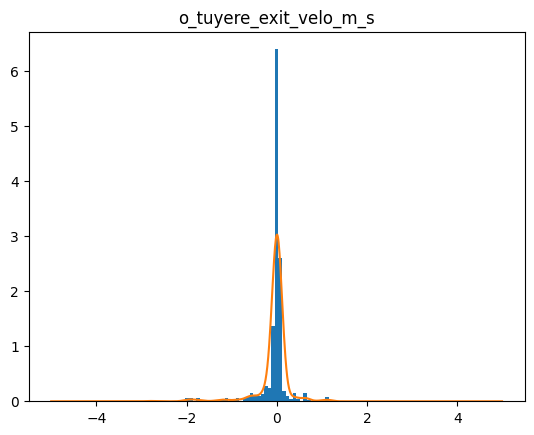

torch.Size([1000])
Epoch-18200 lr: 0.001
18201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18205  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18206  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18207  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18208  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18209  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18210  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18212  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18214  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18215  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18216  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18217  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18218  loss=  tensor(0.0016, grad_fn=<Mea

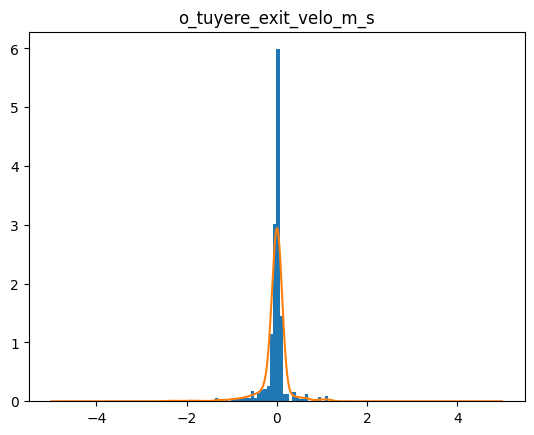

torch.Size([1000])
Epoch-18250 lr: 0.001
18251  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18252  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18253  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18254  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18255  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18256  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18257  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18259  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18260  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18261  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18262  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18263  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18264  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18265  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18266  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18267  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18268  loss=  tensor(0.0016, grad_fn=<Mea

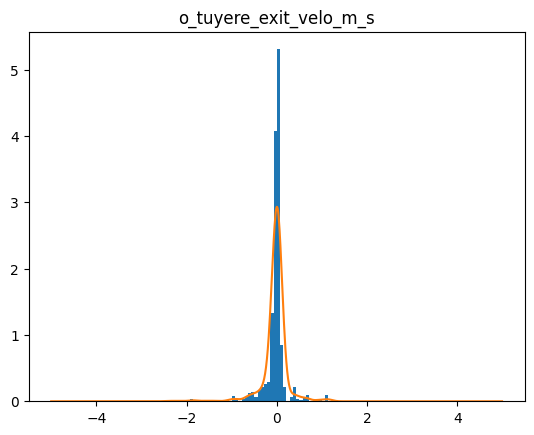

torch.Size([1000])
Epoch-18300 lr: 0.001
18301  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18303  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18304  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18305  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18306  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18307  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18308  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18309  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18310  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18311  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18312  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18313  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18314  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18315  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18316  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18317  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18318  loss=  tensor(0.0015, grad_fn=<Mea

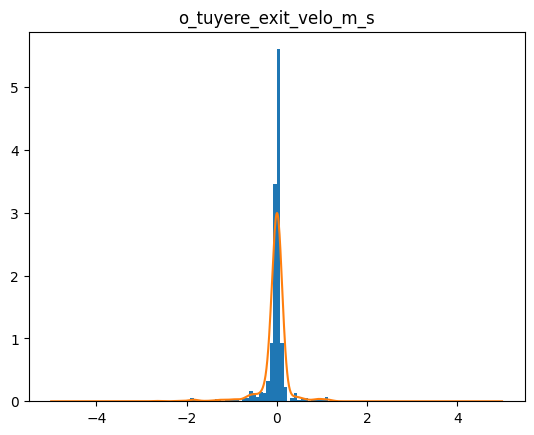

torch.Size([1000])
Epoch-18350 lr: 0.001
18351  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18352  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18354  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18355  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18356  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18358  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18359  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18360  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18361  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18362  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18363  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18364  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18365  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18367  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18368  loss=  tensor(0.0016, grad_fn=<Mea

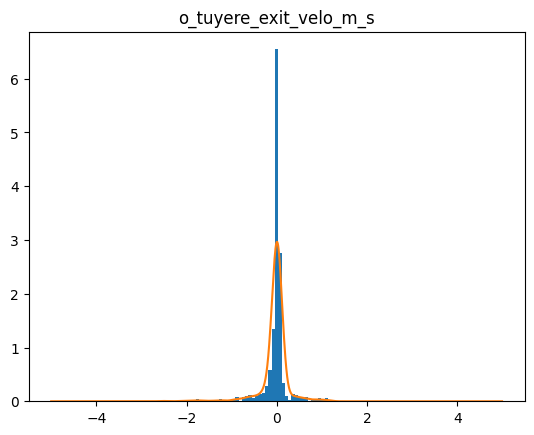

torch.Size([1000])
Epoch-18400 lr: 0.001
18401  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18402  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18403  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18404  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18405  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18406  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18408  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18409  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18410  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18411  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18412  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18413  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18414  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18416  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18417  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18418  loss=  tensor(0.0016, grad_fn=<Mea

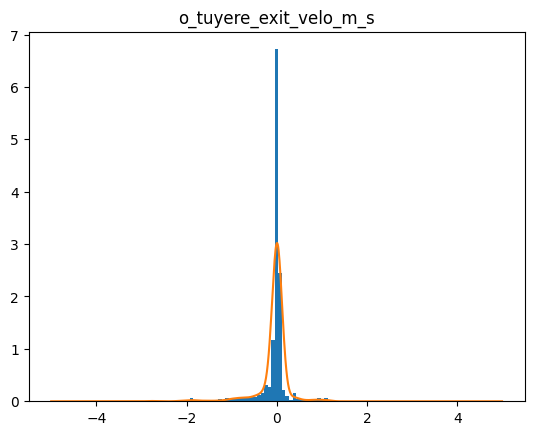

torch.Size([1000])
Epoch-18450 lr: 0.001
18451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18452  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18453  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18454  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18455  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18456  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18457  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18458  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18459  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18462  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18463  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18465  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18466  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18468  loss=  tensor(0.0016, grad_fn=<Mea

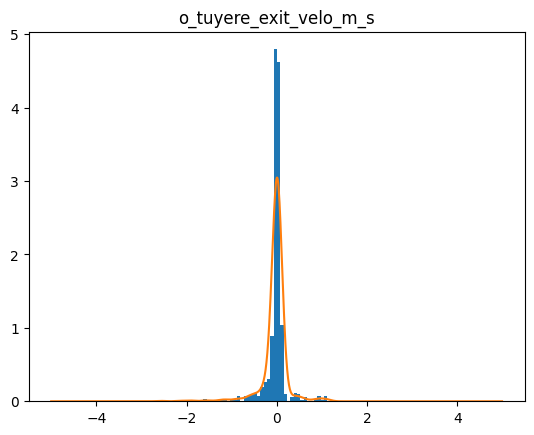

torch.Size([1000])
Epoch-18500 lr: 0.001
18501  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18502  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
18503  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18506  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18507  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18508  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18509  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18510  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18511  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18512  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18513  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18514  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18515  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18516  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18517  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18518  loss=  tensor(0.0015, grad_fn=<Mea

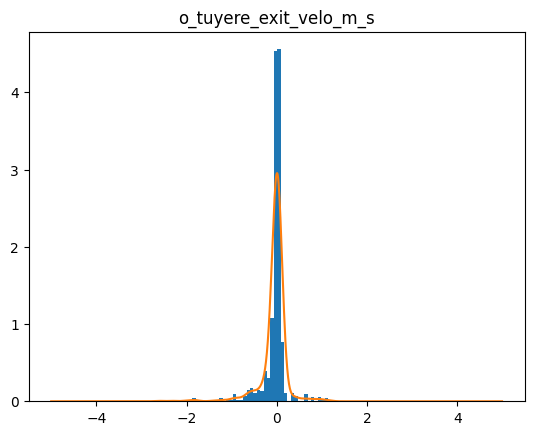

torch.Size([1000])
Epoch-18550 lr: 0.001
18551  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18552  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18553  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18556  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18557  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18558  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18559  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18560  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18562  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18564  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18565  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18566  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18567  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18568  loss=  tensor(0.0016, grad_fn=<Mea

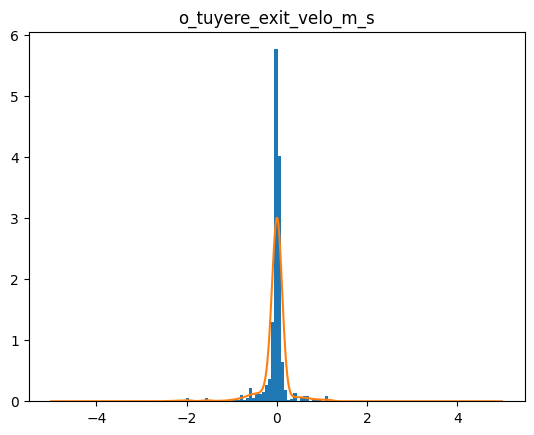

torch.Size([1000])
Epoch-18600 lr: 0.001
18601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18602  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18603  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18604  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18606  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18607  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18608  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18609  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18610  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18611  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18612  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18613  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18614  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18616  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18617  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18618  loss=  tensor(0.0015, grad_fn=<Mea

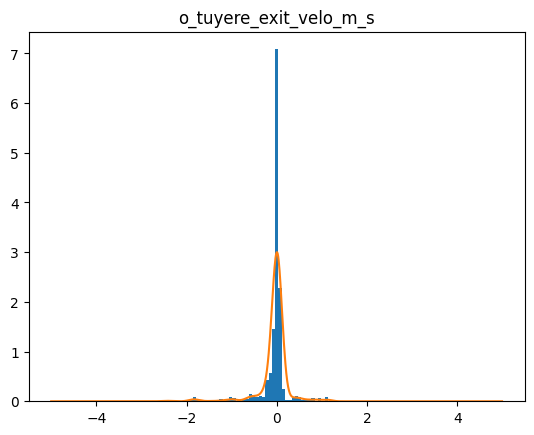

torch.Size([1000])
Epoch-18650 lr: 0.001
18651  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18652  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18654  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18655  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18656  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18657  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18659  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18660  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18661  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18662  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18663  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18664  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18665  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18666  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18667  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18668  loss=  tensor(0.0016, grad_fn=<Mea

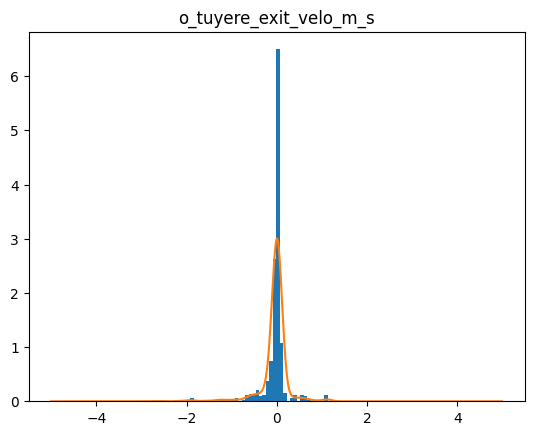

torch.Size([1000])
Epoch-18700 lr: 0.001
18701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18702  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18703  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18705  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18706  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18707  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18709  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18711  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18712  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18713  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18714  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18715  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18717  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18718  loss=  tensor(0.0015, grad_fn=<Mea

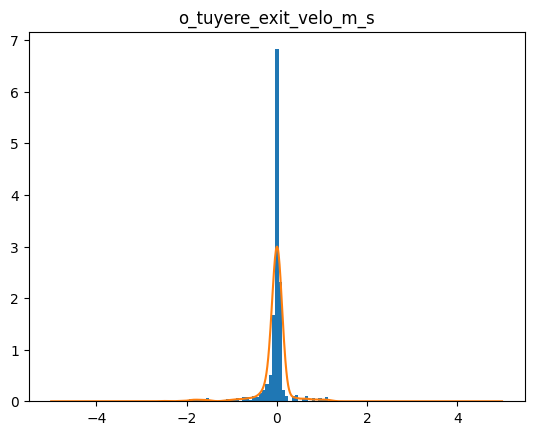

torch.Size([1000])
Epoch-18750 lr: 0.001
18751  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18753  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18754  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18755  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18756  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18757  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18758  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18759  loss=  tensor(0.0017, grad_fn=<MeanBackward0>)
18760  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18761  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18763  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18764  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18765  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18766  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18768  loss=  tensor(0.0017, grad_fn=<Mea

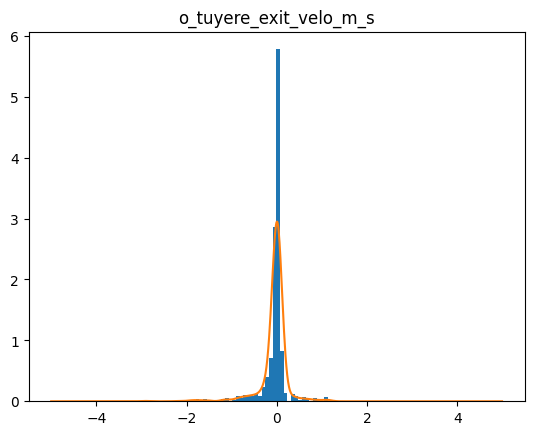

torch.Size([1000])
Epoch-18800 lr: 0.001
18801  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18802  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18803  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18804  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18805  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18807  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18808  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18809  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18810  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18811  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18812  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18813  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18814  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18815  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18816  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18817  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18818  loss=  tensor(0.0015, grad_fn=<Mea

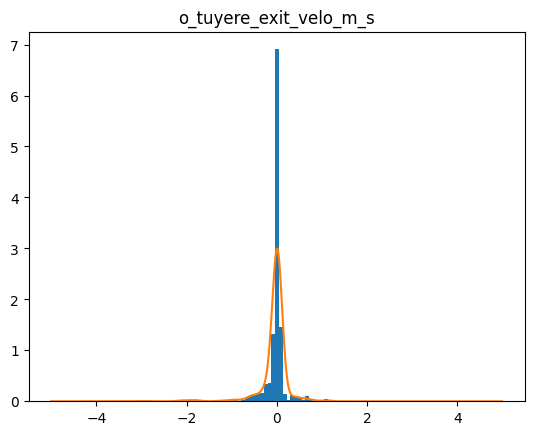

torch.Size([1000])
Epoch-18850 lr: 0.001
18851  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18852  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18853  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18854  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18856  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18857  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18858  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18859  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18860  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18862  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18863  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18864  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18865  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18866  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18868  loss=  tensor(0.0016, grad_fn=<Mea

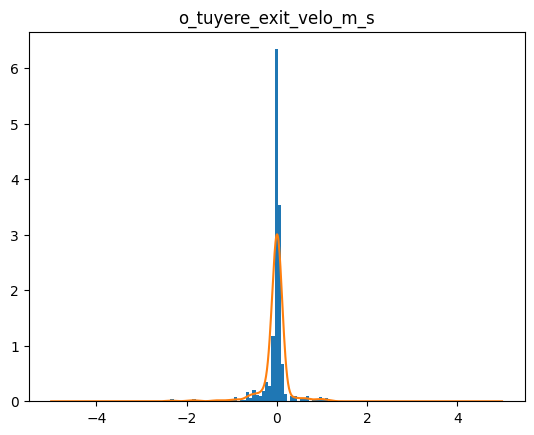

torch.Size([1000])
Epoch-18900 lr: 0.001
18901  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18902  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18903  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18905  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18906  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18907  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18909  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18911  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18912  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18913  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18914  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18915  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18916  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18917  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18918  loss=  tensor(0.0015, grad_fn=<Mea

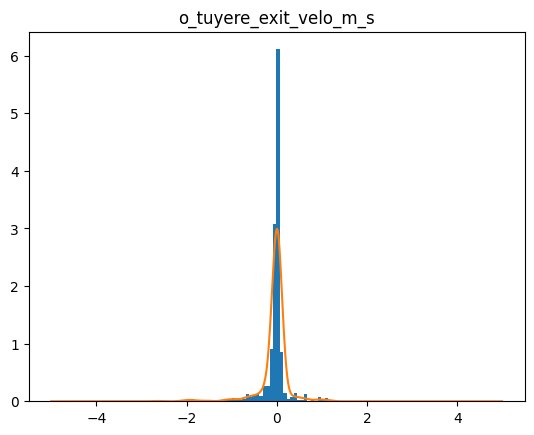

torch.Size([1000])
Epoch-18950 lr: 0.001
18951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18952  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18954  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18955  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18958  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18960  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18961  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18962  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18963  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18964  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18966  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
18967  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
18968  loss=  tensor(0.0015, grad_fn=<Mea

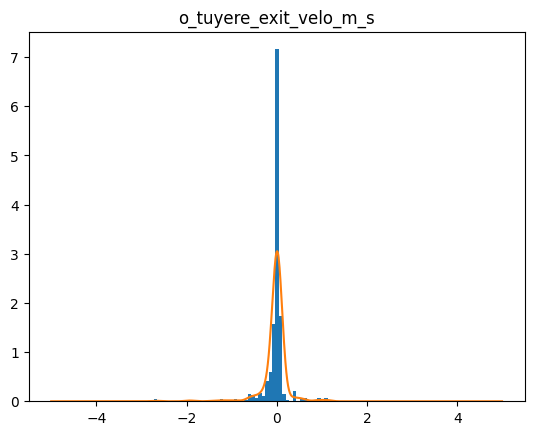

torch.Size([1000])
Epoch-19000 lr: 0.001
19001  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19002  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19003  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19004  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19005  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19006  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19007  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19008  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19009  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19010  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19011  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19012  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19013  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19014  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19015  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19016  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19017  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19018  loss=  tensor(0.0015, grad_fn=<Mea

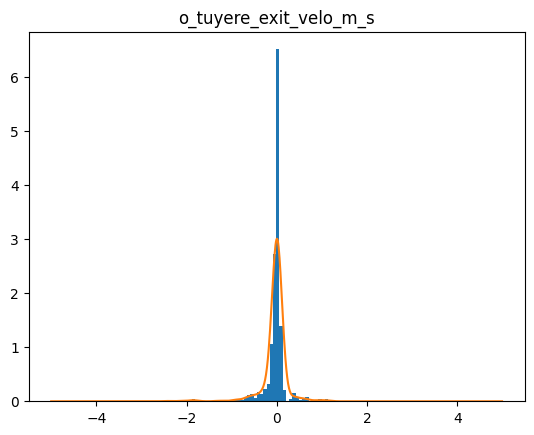

torch.Size([1000])
Epoch-19050 lr: 0.001
19051  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19052  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19053  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19054  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19055  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19056  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19057  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19058  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19059  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19060  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19061  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19062  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19063  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19064  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19065  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19066  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19067  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19068  loss=  tensor(0.0015, grad_fn=<Mea

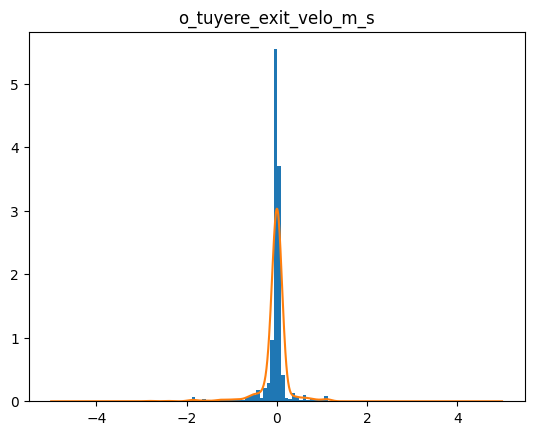

torch.Size([1000])
Epoch-19100 lr: 0.001
19101  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19102  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19103  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19104  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19105  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19106  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19107  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19108  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19109  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19110  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19111  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19112  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19113  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19114  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19115  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19116  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19117  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19118  loss=  tensor(0.0016, grad_fn=<Mea

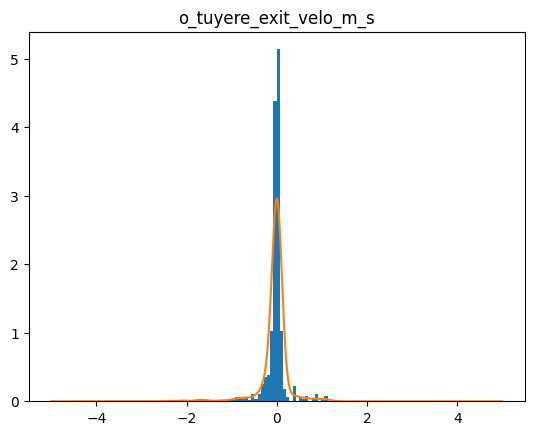

torch.Size([1000])
Epoch-19150 lr: 0.001
19151  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19152  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19153  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19154  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19155  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19156  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19157  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19158  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19159  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19160  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19161  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19162  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19163  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19164  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19165  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19166  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19167  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19168  loss=  tensor(0.0015, grad_fn=<Mea

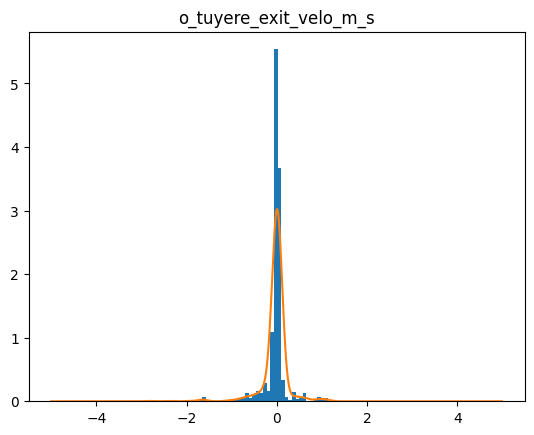

torch.Size([1000])
Epoch-19200 lr: 0.001
19201  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19202  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19203  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19204  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19205  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19206  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19207  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19208  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19209  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19210  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19211  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19212  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19213  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19214  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19215  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19216  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19217  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19218  loss=  tensor(0.0016, grad_fn=<Mea

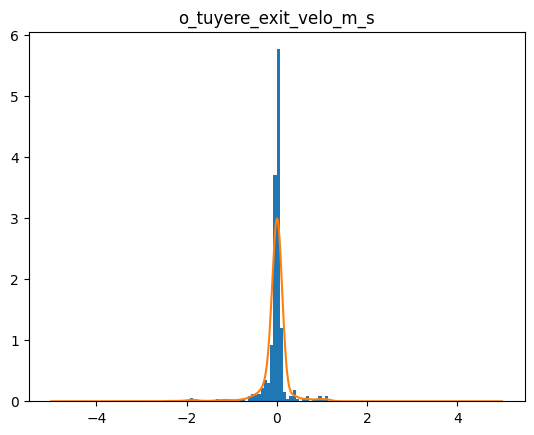

torch.Size([1000])
Epoch-19250 lr: 0.001
19251  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19252  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19253  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19254  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19255  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19256  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19257  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19258  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19259  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19260  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19261  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19262  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19263  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19264  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19265  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19266  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19267  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19268  loss=  tensor(0.0016, grad_fn=<Mea

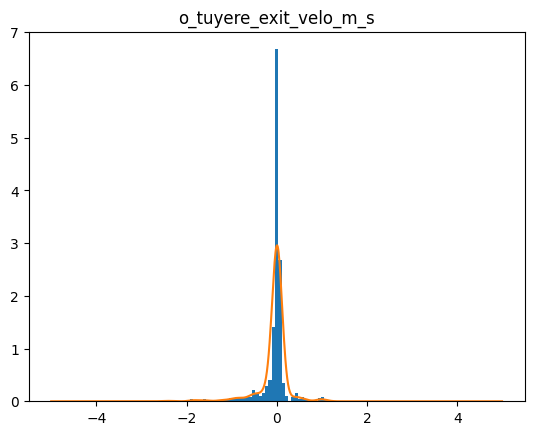

torch.Size([1000])
Epoch-19300 lr: 0.001
19301  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19302  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19303  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19304  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19305  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19306  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19307  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19308  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19309  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19310  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19311  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19312  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19313  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19314  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19315  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19316  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19317  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19318  loss=  tensor(0.0016, grad_fn=<Mea

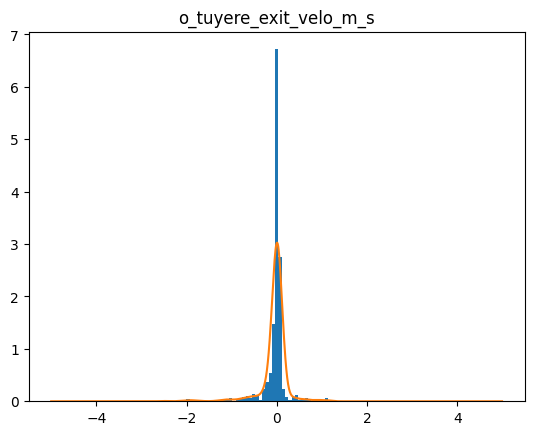

torch.Size([1000])
Epoch-19350 lr: 0.001
19351  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19352  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19353  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19354  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19355  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19356  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19357  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19358  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19359  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19360  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19361  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19362  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19363  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19364  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19365  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19366  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19367  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19368  loss=  tensor(0.0015, grad_fn=<Mea

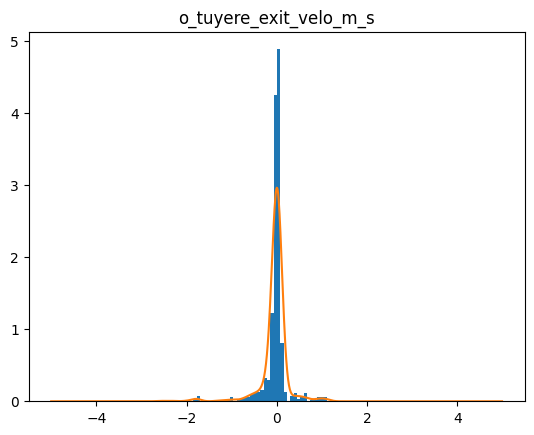

torch.Size([1000])
Epoch-19400 lr: 0.001
19401  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19402  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19403  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19404  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19405  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19406  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19407  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19408  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19409  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19410  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19411  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19412  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19413  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19414  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19415  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19416  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19417  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19418  loss=  tensor(0.0015, grad_fn=<Mea

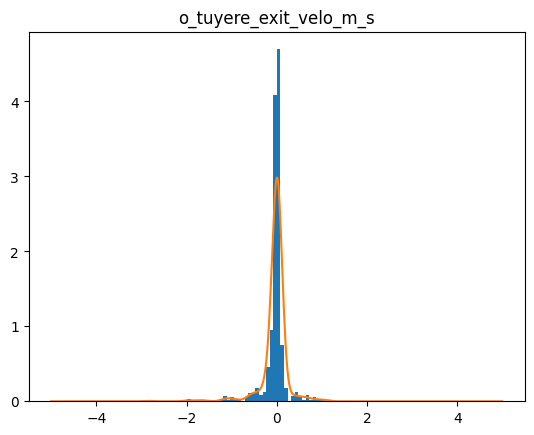

torch.Size([1000])
Epoch-19450 lr: 0.001
19451  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19452  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19453  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19454  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19455  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19456  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19457  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19458  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19459  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19460  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19461  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19462  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19463  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19464  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19465  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19466  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19467  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19468  loss=  tensor(0.0015, grad_fn=<Mea

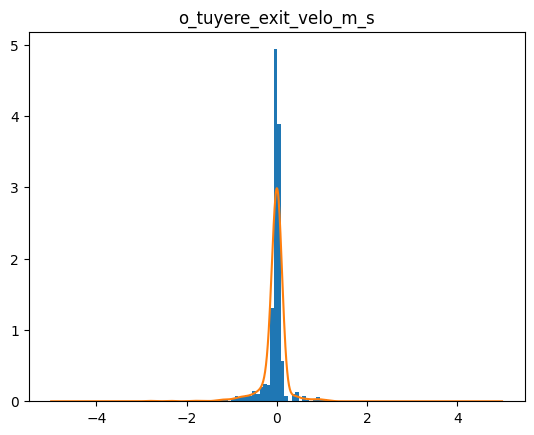

torch.Size([1000])
Epoch-19500 lr: 0.001
19501  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19502  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19503  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19504  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19505  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19506  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19507  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19508  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19509  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19510  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19511  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19512  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19513  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19514  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19515  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19516  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19517  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19518  loss=  tensor(0.0015, grad_fn=<Mea

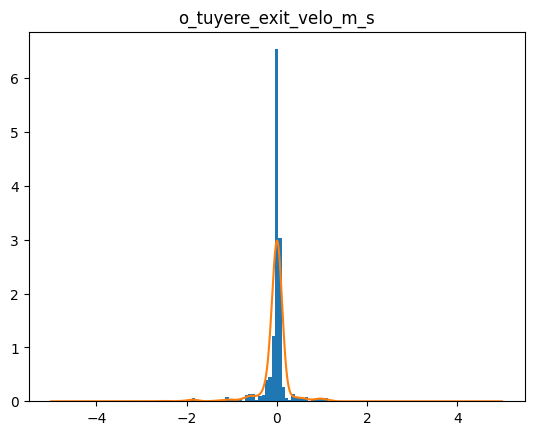

torch.Size([1000])
Epoch-19550 lr: 0.001
19551  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19552  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19553  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19554  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19555  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19556  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19557  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19558  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19559  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19560  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19561  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19562  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19563  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19564  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19565  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19566  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19567  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19568  loss=  tensor(0.0015, grad_fn=<Mea

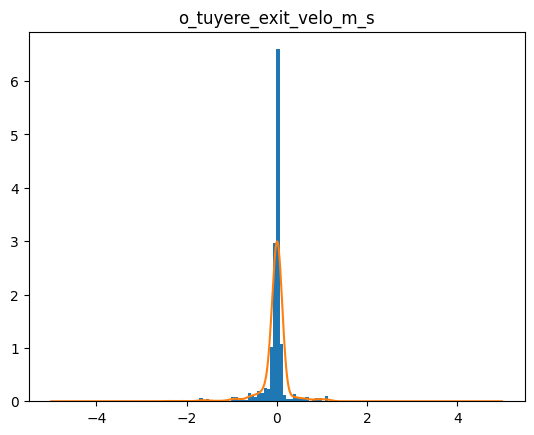

torch.Size([1000])
Epoch-19600 lr: 0.001
19601  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19602  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19603  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19604  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19605  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19606  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19607  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19608  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19609  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19610  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19611  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19612  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19613  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19614  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19615  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19616  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19617  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19618  loss=  tensor(0.0016, grad_fn=<Mea

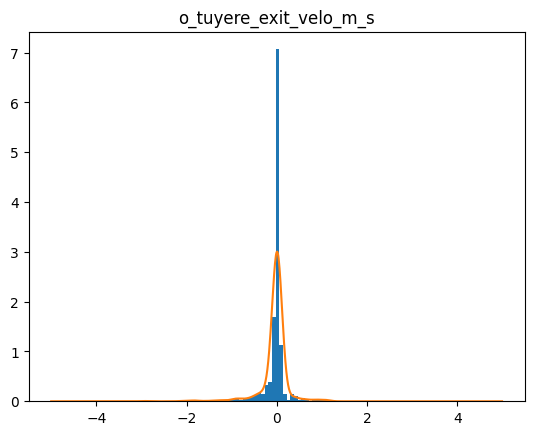

torch.Size([1000])
Epoch-19650 lr: 0.001
19651  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19652  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19653  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19654  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19655  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19656  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19657  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19658  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19659  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19660  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19661  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19662  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19663  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19664  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19665  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19666  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19667  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19668  loss=  tensor(0.0016, grad_fn=<Mea

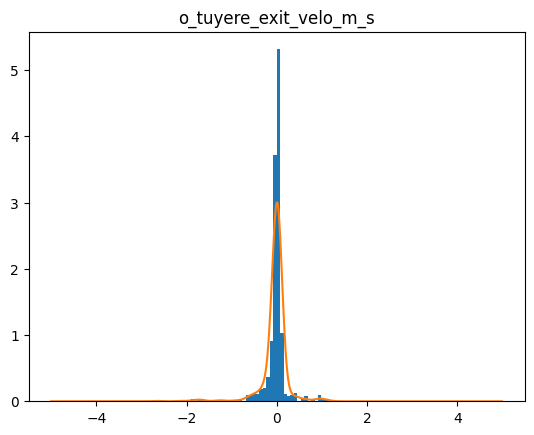

torch.Size([1000])
Epoch-19700 lr: 0.001
19701  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19702  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19703  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19704  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19705  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19706  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19707  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19708  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19709  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19710  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19711  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19712  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19713  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19714  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19715  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19716  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19717  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19718  loss=  tensor(0.0015, grad_fn=<Mea

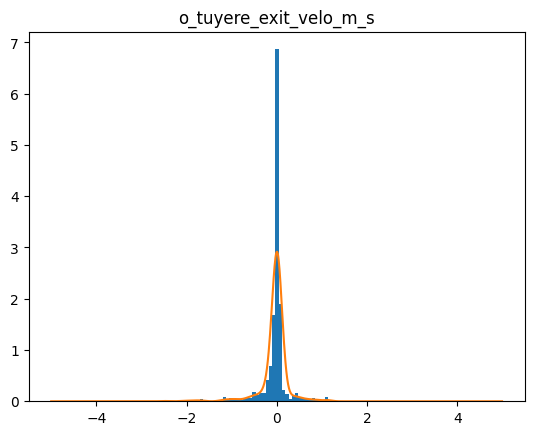

torch.Size([1000])
Epoch-19750 lr: 0.001
19751  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19752  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19753  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19754  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19755  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19756  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19757  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19758  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19759  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19760  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19761  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19762  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19763  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19764  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19765  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19766  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19767  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19768  loss=  tensor(0.0015, grad_fn=<Mea

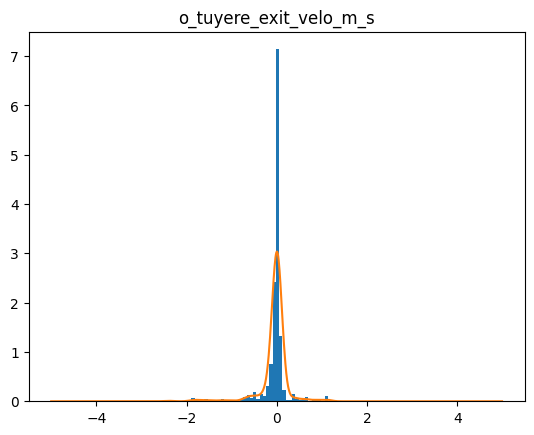

torch.Size([1000])
Epoch-19800 lr: 0.001
19801  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19802  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19803  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19804  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19805  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19806  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19807  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19808  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19809  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19810  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19811  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19812  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19813  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19814  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19815  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19816  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19817  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19818  loss=  tensor(0.0015, grad_fn=<Mea

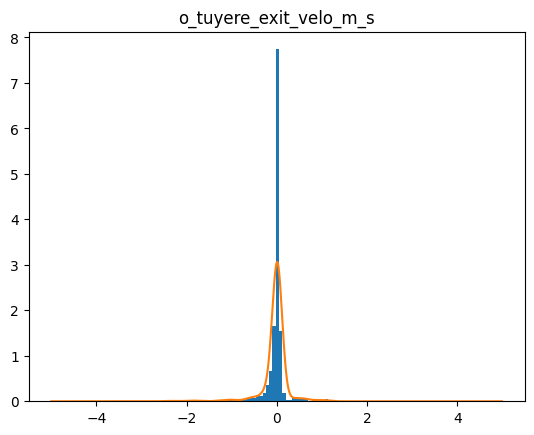

torch.Size([1000])
Epoch-19850 lr: 0.001
19851  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19852  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19853  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19854  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19855  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19856  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19857  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19858  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19859  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19860  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19861  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19862  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19863  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19864  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19865  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19866  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19867  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19868  loss=  tensor(0.0015, grad_fn=<Mea

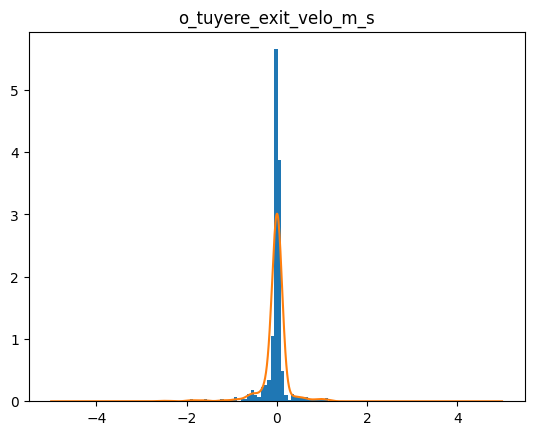

torch.Size([1000])
Epoch-19900 lr: 0.001
19901  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19902  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19903  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19904  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19905  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19906  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19907  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19908  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19909  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19910  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19911  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19912  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19913  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19914  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19915  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19916  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19917  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19918  loss=  tensor(0.0015, grad_fn=<Mea

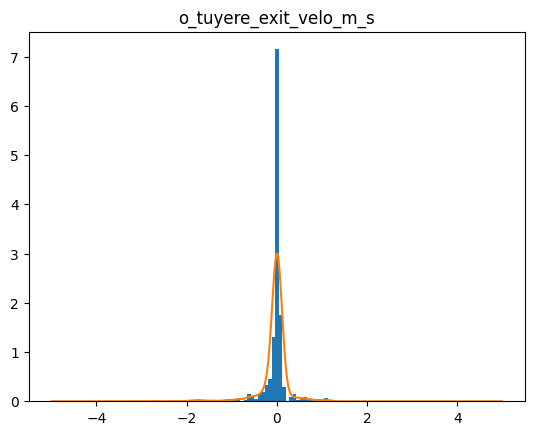

torch.Size([1000])
Epoch-19950 lr: 0.001
19951  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19952  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19953  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19954  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19955  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19956  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19957  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19958  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19959  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19960  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19961  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19962  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19963  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19964  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19965  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19966  loss=  tensor(0.0016, grad_fn=<MeanBackward0>)
19967  loss=  tensor(0.0015, grad_fn=<MeanBackward0>)
19968  loss=  tensor(0.0015, grad_fn=<Mea

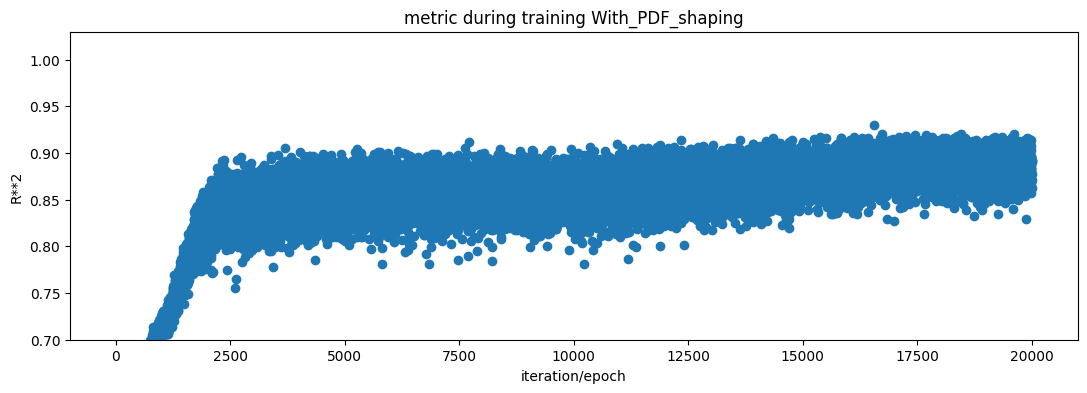

Training loss: tensor(0.0853, grad_fn=<MseLossBackward0>)
Training R**2: 0.9023046874060136
Test loss - scaled: tensor(0.0650, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(3.9560, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9118791432357934
Testing R**2 - descaled: 0.911879151764029
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.911879151764029


In [37]:


model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)



opt         = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate_pdfcontrol    )


step_size_scheduler = int(PDFshapingOBJ.N_EPOCHS_PDF / 3)
print(step_size_scheduler)
                          
scheduler   = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.1)



loss_fn      = F.mse_loss
kl_loss      = nn.KLDivLoss(reduction="batchmean")
loss_softmax = F.binary_cross_entropy


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt, kl_loss, scheduler)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)

In [38]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(151.63223, 150.8996)
**************************************************
preds, real
(143.26083, 143.5706)
**************************************************
preds, real
(135.18579, 134.7298)
**************************************************
preds, real
(132.19133, 132.48782)
**************************************************
preds, real
(129.15709, 129.11511)
**************************************************
preds, real
(129.12468, 129.21054)
**************************************************
preds, real
(135.35945, 135.0968)
**************************************************
preds, real
(135.36882, 135.0968)
**************************************************
preds, real
(141.8712, 148.57646)
**************************************************
preds, real
(129.71982, 129.84276)
**************************************************
preds, real
(143.33383, 143.62637)
**************************************************
preds, re

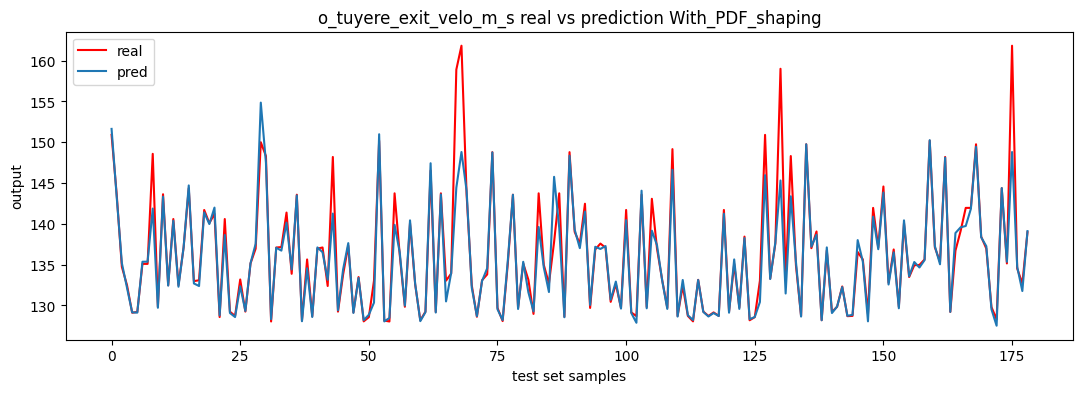

/Users/user/Desktop/DOE_CIVS/experiments/2023july/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


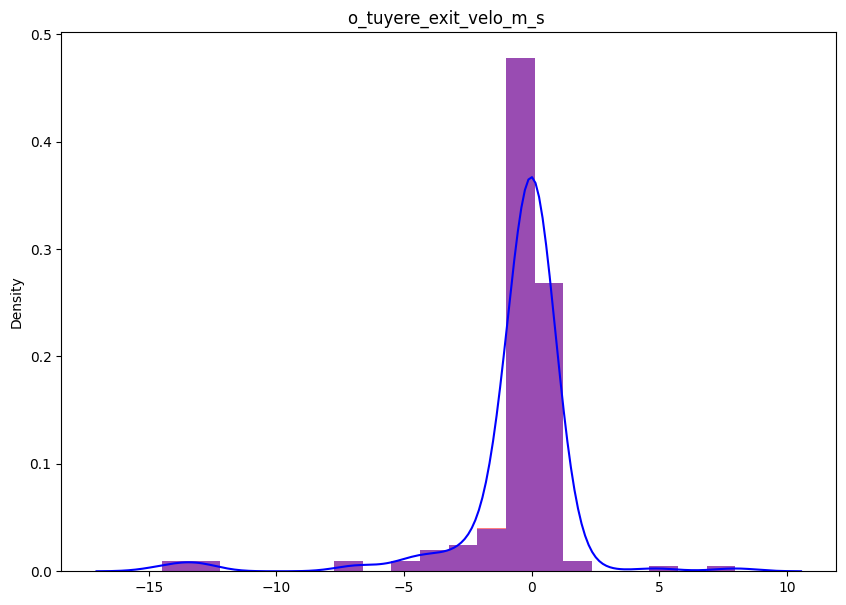

In [39]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## To compare to NNs to XGBoost


In [40]:

##      y_pred = regressor.predict(PDFshapingOBJ.X_test )

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)


In [41]:

## y_pred

pred_descaled


tensor([[151.6379],
        [143.4714],
        [135.1028],
        [132.2902],
        [129.2333],
        [129.2853],
        [136.0001],
        [135.3214],
        [148.4853],
        [130.0176],
        [143.8078],
        [132.5838],
        [140.3821],
        [132.2719],
        [136.4618],
        [143.7587],
        [132.7673],
        [133.2470],
        [140.6461],
        [140.2400],
        [142.7040],
        [128.7916],
        [138.2441],
        [129.2297],
        [128.6037],
        [132.5075],
        [129.2448],
        [135.1934],
        [137.2929],
        [154.0619],
        [148.3015],
        [128.0315],
        [136.8533],
        [137.4940],
        [140.7150],
        [134.4787],
        [143.5049],
        [128.0629],
        [135.3788],
        [128.5998],
        [137.2921],
        [135.8685],
        [133.1320],
        [148.7635],
        [129.4199],
        [134.5446],
        [137.6427],
        [129.2256],
        [133.4910],
        [128.1833],


In [42]:

## r2_score( PDFshapingOBJ.y_test, y_pred )

print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))


Testing R**2 - scaled: 0.9532966584755717
Testing R**2 - descaled: 0.953296631235707



## Export ONNX model


In [43]:

'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s894TuyereExitVeloMsPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''


'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 6)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/s894TuyereExitVeloMsPDFshapingRC.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'


## XGBoost


In [44]:

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)


In [45]:

regressor.fit(PDFshapingOBJ.X_train, PDFshapingOBJ.y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [46]:

print( len(PDFshapingOBJ.X_train  ))
print( len(PDFshapingOBJ.y_train  ))
  


715
715


In [47]:

columns_thing = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 
                 'i_o2_vol_perce', 'i_hot_blast_temp_k', ]



pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=columns_thing)


i_h2_inj_kg_thm  i_pul_coal_inj_kg_thm  i_nat_gas_inj_kg_thm  \
0         0.169897               0.025342              0.404338   

   i_nat_gas_t_k  i_o2_vol_perce  i_hot_blast_temp_k  
0       0.173856        0.010829            0.215738

In [48]:

y_pred = regressor.predict(PDFshapingOBJ.X_test )


In [49]:

y_pred


array([150.73523, 143.6169 , 134.70705, 132.59587, 129.05936, 129.21335,
       134.91461, 134.91461, 148.79782, 129.8482 , 143.49176, 132.43413,
       140.44203, 132.59587, 137.31291, 144.31827, 133.00566, 132.94608,
       141.78252, 139.90456, 141.25623, 128.60158, 140.44203, 129.24892,
       128.68538, 133.17667, 129.25243, 135.39996, 137.06308, 149.96788,
       148.74683, 128.07558, 137.20905, 136.97472, 141.18472, 133.88074,
       143.6169 , 128.13626, 135.63892, 128.64981, 137.06308, 137.31291,
       132.47197, 148.51212, 129.25243, 133.6767 , 137.42746, 129.20587,
       133.52113, 128.06035, 128.50304, 133.05704, 150.24097, 128.13626,
       128.07558, 143.6858 , 136.10815, 129.8482 , 139.90456, 132.4402 ,
       128.17183, 129.24892, 146.60945, 129.21335, 143.6858 , 133.05704,
       133.9019 , 159.13197, 161.84558, 143.6169 , 132.59587, 128.6394 ,
       132.94608, 133.6767 , 148.99995, 129.67458, 128.1152 , 134.91461,
       143.6169 , 129.67458, 135.39996, 133.15544, 

In [50]:

mean_squared_error(PDFshapingOBJ.y_test , y_pred)


0.121459484

In [51]:

r2_score( PDFshapingOBJ.y_test, y_pred )


0.997712463935736

In [52]:

len(y_pred) 


179

In [53]:

list_preds = []
list_reals = []

print( "preds, real"   )
  
for j in range(   len(y_pred)    ):
    print(   y_pred[j], PDFshapingOBJ.y_test[j][0]   )
    
    list_preds.append(   y_pred[j]   )
    list_reals.append(  PDFshapingOBJ.y_test[j][0]   )


preds, real
150.73523 150.8996
143.6169 143.5706
134.70705 134.7298
132.59587 132.48782
129.05936 129.11511
129.21335 129.21054
134.91461 135.0968
134.91461 135.0968
148.79782 148.57646
129.8482 129.84276
143.49176 143.62637
132.43413 132.47691
140.44203 140.59135
132.59587 132.48782
137.31291 137.10771
144.31827 144.36778
133.00566 132.986
132.94608 133.09
141.78252 141.70135
139.90456 140.08952
141.25623 141.22519
128.60158 128.58289
140.44203 140.59135
129.24892 129.24333
128.68538 128.71231
133.17667 133.18417
129.25243 129.25531
135.39996 135.15031
137.06308 136.96371
149.96788 149.9987
148.74683 148.30594
128.07558 128.04027
137.20905 137.0987
136.97472 137.1573
141.18472 141.38176
133.88074 133.88142
143.6169 143.5706
128.13626 128.15402
135.63892 135.6384
128.64981 128.67992
137.06308 136.96371
137.31291 137.10771
132.47197 132.38907
148.51212 148.19263
129.25243 129.2476
133.6767 133.80692
137.42746 137.33014
129.20587 129.151
133.52113 133.48071
128.06035 128.05579
128.50304 

In [54]:

len( list_preds )


179

In [55]:

len( list_reals )


179

In [56]:

PDFshapingOBJ.the_string           = "XGBoost"
PDFshapingOBJ.furnace_model_name   = "tuyere_exit_velo_m_s"


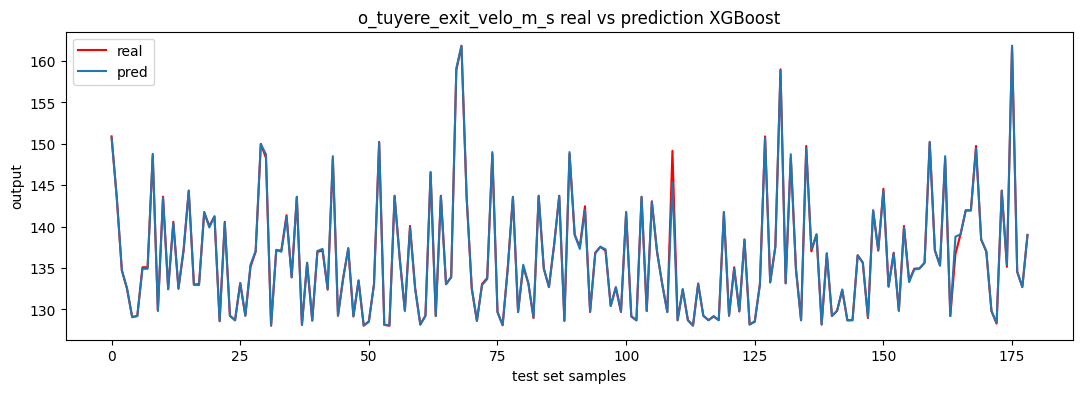

/Users/user/Desktop/DOE_CIVS/experiments/2023july/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


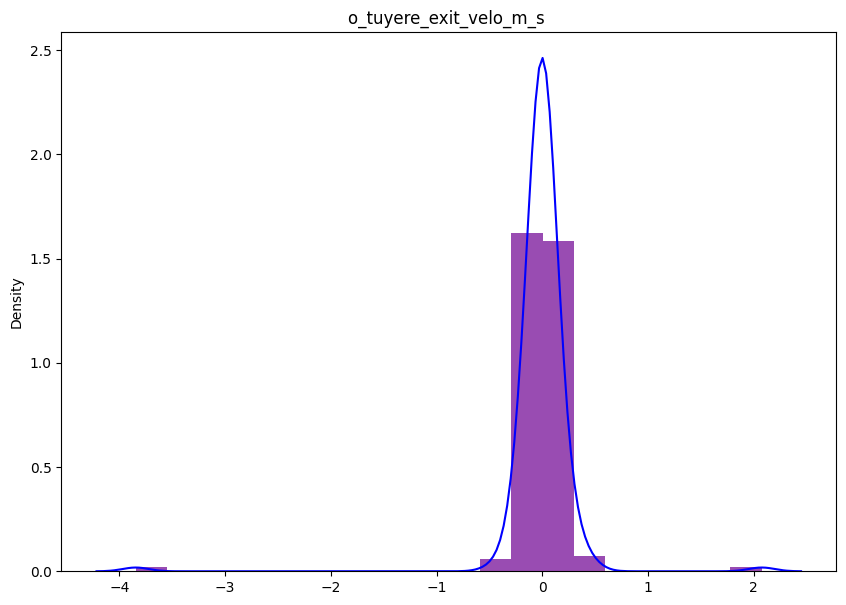

In [57]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## ONNX and XGboost


In [58]:

model = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)


In [59]:

print(model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=1, ...)


In [60]:

model.fit( PDFshapingOBJ.X_train, PDFshapingOBJ.y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [61]:

y_pred = model.predict(PDFshapingOBJ.X_test )


In [62]:

y_pred


array([150.73523, 143.6169 , 134.70705, 132.59587, 129.05936, 129.21335,
       134.91461, 134.91461, 148.79782, 129.8482 , 143.49176, 132.43413,
       140.44203, 132.59587, 137.31291, 144.31827, 133.00566, 132.94608,
       141.78252, 139.90456, 141.25623, 128.60158, 140.44203, 129.24892,
       128.68538, 133.17667, 129.25243, 135.39996, 137.06308, 149.96788,
       148.74683, 128.07558, 137.20905, 136.97472, 141.18472, 133.88074,
       143.6169 , 128.13626, 135.63892, 128.64981, 137.06308, 137.31291,
       132.47197, 148.51212, 129.25243, 133.6767 , 137.42746, 129.20587,
       133.52113, 128.06035, 128.50304, 133.05704, 150.24097, 128.13626,
       128.07558, 143.6858 , 136.10815, 129.8482 , 139.90456, 132.4402 ,
       128.17183, 129.24892, 146.60945, 129.21335, 143.6858 , 133.05704,
       133.9019 , 159.13197, 161.84558, 143.6169 , 132.59587, 128.6394 ,
       132.94608, 133.6767 , 148.99995, 129.67458, 128.1152 , 134.91461,
       143.6169 , 129.67458, 135.39996, 133.15544, 

In [63]:

r2_score( PDFshapingOBJ.y_test, y_pred )


0.997712463935736

In [64]:

initial_types = [(
         'float_input', 
         FloatTensorType(     [ None, PDFshapingOBJ.X.shape[1] ]       )
)]


In [65]:

onnx_model = onnxmltools.convert_xgboost(model, initial_types=initial_types)

onnxmltools.utils.save_model(onnx_model, 'ONNXmodels/xgboost_tuyere_exit_velo_m_s_ort.onnx')


In [66]:

# Setup runtime. This instantiates an ONNX inference session and loads the persisted model.
sess = rt.InferenceSession("ONNXmodels/xgboost_tuyere_exit_velo_m_s_ort.onnx")


In [67]:

# Get model metadata to enable mapping of new input to the runtime model
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name


In [68]:

input_name 


'float_input'

In [69]:

label_name


'variable'

In [70]:

# Create predictions. The inputs are the xtest values, and they are being casted as type float32.
pred_onnx = sess.run([label_name], {input_name: PDFshapingOBJ.X_test.astype(np.float32)})[0]


In [71]:

# Print first 10 predictions
print("Prediction:\n", pred_onnx[0:10])


Prediction:
 [[150.73524]
 [143.61688]
 [134.70702]
 [132.59581]
 [129.05939]
 [129.2134 ]
 [134.91458]
 [134.91458]
 [148.79778]
 [129.84824]]


In [72]:

test_count = 10
test_cases = PDFshapingOBJ.X_test[0:test_count]
local_pred = model.predict(test_cases)
print(f"Local predictions are: {local_pred}")


Local predictions are: [150.73523 143.6169  134.70705 132.59587 129.05936 129.21335 134.91461
 134.91461 148.79782 129.8482 ]


In [73]:

test_cases


array([[   0.   ,    0.   ,  150.   ,  300.   ,   30.   , 1485.   ],
       [   0.   ,    0.   ,  120.   ,  300.   ,   27.   , 1485.   ],
       [   0.   ,    0.   ,   70.   ,  300.   ,   27.   , 1459.817],
       [   0.   ,    0.   ,   37.9  ,  400.   ,   30.   , 1459.817],
       [   0.   ,   70.   ,    0.   ,  300.   ,   24.   , 1459.817],
       [   0.   ,  124.   ,    0.   ,  300.   ,   24.   , 1459.817],
       [   0.   ,    0.   ,   70.   ,  300.   ,   21.   , 1459.817],
       [   0.   ,    0.   ,   70.   ,  300.   ,   21.   , 1459.817],
       [   0.   ,    0.   ,  120.   ,  500.   ,   24.   , 1459.817],
       [   0.   ,  200.   ,    0.   ,  300.   ,   21.   , 1459.817]],
      dtype=float32)